In [2]:
from pyprojroot import here
root = here()
import sys
sys.path.append(str(root))

import pandas as pd
import json
import numpy as np

from molmass import Formula
import cirpy

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map 
tqdm.pandas()

from food_database.utils.parallel import *
from food_database.utils.utils import *
from food_database.density.food_match import *

import re
from pathlib import Path

import multiprocessing as mp
import requests
import pickle

import os

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
food_df = pd.read_csv('../data/datasets/molecule/foodb_2020/Food.csv', index_col='id')
compound_df = pd.read_csv('../data/datasets/molecule/foodb_2020/Compound.csv', index_col='id')
content_df = pd.read_csv('../data/datasets/molecule/foodb_2020/Content.csv', index_col=['food_id', 'source_id'])
nutrients_df = pd.read_csv('../data/datasets/molecule/foodb_2020/Nutrient.csv', index_col='id')

/tmp/ipykernel_10599/938653583.py:2: DtypeWarning: Columns (3,4,5,6,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  compound_df = pd.read_csv('../data/datasets/molecule/foodb_2020/Compound.csv', index_col='id')


/tmp/ipykernel_10599/938653583.py:3: DtypeWarning: Columns (4,5,6,7,8,9,13,14,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  content_df = pd.read_csv('../data/datasets/molecule/foodb_2020/Content.csv', index_col=['food_id', 'source_id'])


In [6]:
food_df = food_df.convert_dtypes()
compound_df = compound_df.convert_dtypes()
content_df = content_df.convert_dtypes()
nutrients_df = nutrients_df.convert_dtypes()

In [7]:
content_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5145532 entries, (4, 1) to (624, 139988)
Data columns (total 24 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   id                         Int64  
 1   source_type                string 
 2   orig_food_id               object 
 3   orig_food_common_name      string 
 4   orig_food_scientific_name  string 
 5   orig_food_part             string 
 6   orig_source_id             object 
 7   orig_source_name           string 
 8   orig_content               Float64
 9   orig_min                   Float64
 10  orig_max                   Float64
 11  orig_unit                  string 
 12  orig_citation              string 
 13  citation                   string 
 14  citation_type              string 
 15  creator_id                 Int64  
 16  updater_id                 Int64  
 17  created_at                 string 
 18  updated_at                 string 
 19  orig_method                stri

In [8]:
food_df.head()

,name,name_scientific,description,itis_id,wikipedia_id,picture_file_name,picture_content_type,picture_file_size,picture_updated_at,legacy_id,food_group,food_subgroup,food_type,created_at,updated_at,creator_id,updater_id,export_to_afcdb,category,ncbi_taxonomy_id,export_to_foodb,public_id
id,,,,,,,,,,,,,,,,,,,,,,
1,Angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,<NA>,Angelica,1.jpg,image/jpeg,111325,2012-04-20 09:29:57 UTC,1,Herbs and Spices,Herbs,Type 1,2011-02-09 00:37:14 UTC,2019-05-14 18:04:13 UTC,<NA>,2,False,specific,357850,True,FOOD00001
2,Savoy cabbage,Brassica oleracea var. sabauda,Savoy cabbage (Brassica oleracea convar. capit...,<NA>,Savoy cabbage,2.jpg,image/jpeg,155178,2012-04-20 09:39:54 UTC,2,Vegetables,Cabbages,Type 1,2011-02-09 00:37:15 UTC,2019-05-14 18:04:13 UTC,<NA>,<NA>,False,specific,1216010,True,FOOD00002
3,Silver linden,Tilia argentea,Tilia tomentosa (Silver Lime in the UK and Sil...,845789,Tilia tomentosa,3.jpg,image/jpeg,56367,2012-04-20 09:41:25 UTC,3,Herbs and Spices,Herbs,Type 1,2011-02-09 00:37:15 UTC,2019-05-17 16:19:45 UTC,<NA>,<NA>,False,specific,<NA>,True,FOOD00003
4,Kiwi,Actinidia chinensis,"The kiwifruit, often shortened to kiwi in many...",506775,Kiwifruit,4.jpg,image/jpeg,110661,2012-04-20 09:32:21 UTC,4,Fruits,Tropical fruits,Type 1,2011-02-09 00:37:15 UTC,2019-05-14 18:04:13 UTC,<NA>,<NA>,False,specific,3625,True,FOOD00004
5,Allium,Allium,Allium haematochiton is a species of wild onio...,42634,Allium haematochiton,5.jpg,image/jpeg,341911,2012-04-20 09:37:44 UTC,5,Vegetables,Onion-family vegetables,Type 1,2011-02-09 00:37:15 UTC,2019-05-14 18:04:13 UTC,<NA>,<NA>,False,specific,4678,True,FOOD00005


In [9]:
food_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 992 entries, 1 to 1024
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  992 non-null    string 
 1   name_scientific       675 non-null    string 
 2   description           945 non-null    string 
 3   itis_id               610 non-null    Int64  
 4   wikipedia_id          853 non-null    string 
 5   picture_file_name     877 non-null    string 
 6   picture_content_type  877 non-null    string 
 7   picture_file_size     877 non-null    Int64  
 8   picture_updated_at    848 non-null    string 
 9   legacy_id             620 non-null    Int64  
 10  food_group            989 non-null    string 
 11  food_subgroup         985 non-null    string 
 12  food_type             992 non-null    string 
 13  created_at            992 non-null    string 
 14  updated_at            992 non-null    string 
 15  creator_id            253 n

In [10]:
content_df.head()

id source_type orig_food_id orig_food_common_name  \
food_id source_id                                                      
4       1           1    Nutrient           29                  Kiwi   
6       1           2    Nutrient           53                 Onion   
        1           3    Nutrient           53                 Onion   
9       1           4    Nutrient           55                Chives   
11      1           5    Nutrient           70                Cashew   

                                      orig_food_scientific_name  \
food_id source_id                                                 
4       1          Actinidia chinensis PLANCHON [Actinidiaceae]   
6       1                            Allium cepa L. [Liliaceae]   
        1                            Allium cepa L. [Liliaceae]   
9       1                   Allium schoenoprasum L. [Liliaceae]   
11      1             Anacardium occidentale L. [Anacardiaceae]   

                  orig_food_part orig_source_id orig_source_name  \
food_id source_id                                                  
4       1                  Fruit            FAT              FAT   
6       1                   Bulb            FAT              FAT   
        1                   Leaf            FAT              FAT   
9       1                   Leaf            FAT              FAT   
11      1                  Fruit            FAT              FAT   

                   orig_content  orig_min  orig_max orig_unit orig_citation  \
food_id source_id                                                             
4       1                1955.0      70.0    3840.0   mg/100g          <NA>   
6       1               1853.95     100.0    3607.9   mg/100g          <NA>   
        1                4150.0     600.0    7700.0   mg/100g          <NA>   
9       1                3900.0     300.0    7500.0   mg/100g          <NA>   
11      1                2500.0     100.0    4900.0   mg/100g          <NA>   

                  citation citation_type  creator_id  updater_id  \
food_id source_id                                                  
4       1             DUKE      DATABASE        <NA>        <NA>   
6       1             DUKE      DATABASE        <NA>        <NA>   
        1             DUKE      DATABASE        <NA>        <NA>   
9       1             DUKE      DATABASE        <NA>        <NA>   
11      1             DUKE      DATABASE        <NA>        <NA>   

                                created_at               updated_at  \
food_id source_id                                                     
4       1          2014-11-05 13:42:11 UTC  2019-12-11 20:23:57 UTC   
6       1          2014-11-05 13:42:11 UTC  2019-12-11 20:23:57 UTC   
        1          2014-11-05 13:42:11 UTC  2019-12-11 20:23:57 UTC   
9       1          2014-11-05 13:42:11 UTC  2019-12-11 20:23:57 UTC   
11      1          2014-11-05 13:42:11 UTC  2019-12-11 20:23:57 UTC   

                  orig_method orig_unit_expression  standard_content  \
food_id source_id                                                      
4       1                <NA>                 <NA>            1955.0   
6       1                <NA>                 <NA>           1853.95   
        1                <NA>                 <NA>            4150.0   
9       1                <NA>                 <NA>            3900.0   
11      1                <NA>                 <NA>            2500.0   

                  preparation_type  export  
food_id source_id                           
4       1                      raw       0  
6       1                      raw       0  
        1                      raw       0  
9       1                      raw       0  
11      1                    other       0

# Processing Food DF

In [11]:
food_df[food_df['name'].str.lower().str.contains('onion')]

,name,name_scientific,description,itis_id,wikipedia_id,picture_file_name,picture_content_type,picture_file_size,picture_updated_at,legacy_id,food_group,food_subgroup,food_type,created_at,updated_at,creator_id,updater_id,export_to_afcdb,category,ncbi_taxonomy_id,export_to_foodb,public_id
id,,,,,,,,,,,,,,,,,,,,,,
6,Garden onion,Allium cepa,The onion (Allium cepa) (Latin 'cepa' = onion)...,42720,Onion,6.jpg,image/jpeg,138437,2012-04-20 09:41:21 UTC,6,Vegetables,Onion-family vegetables,Type 1,2011-02-09 00:37:15 UTC,2019-05-14 18:04:13 UTC,<NA>,<NA>,True,specific,4679,True,FOOD00006
226,Garden onion (var.),Allium cepa var. cepa,<NA>,182638,<NA>,226.jpg,image/jpeg,138437,2012-04-23 10:45:33 UTC,241,Vegetables,Onion-family vegetables,Type 1,2011-02-09 00:37:27 UTC,2019-05-14 18:04:19 UTC,<NA>,2,False,specific,4679,True,FOOD00226
241,Welsh onion,Allium fistulosum,"Allium fistulosum L. (Welsh onion, Japanese bu...",185463,Welsh_onion,241.jpg,image/jpeg,15355,2012-04-20 09:33:35 UTC,256,Herbs and Spices,Herbs,Type 1,2011-02-09 00:37:28 UTC,2019-05-14 18:04:20 UTC,<NA>,<NA>,False,specific,35875,True,FOOD00241
885,Onion-family vegetables,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Vegetables,Onion-family vegetables,Unknown,2012-09-11 14:56:18 UTC,2019-12-11 19:38:51 UTC,2,2,False,generic,<NA>,False,FOOD00855
993,White onion,<NA>,"White onion (Allium cepa, 'sweet onion') is a ...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Vegetables,Onion-family vegetables,Type 1,2020-01-24 17:05:37 UTC,2020-03-12 21:00:51 UTC,<NA>,<NA>,False,<NA>,<NA>,False,FOOD00961
994,Red onion,<NA>,Red onions are cultivars of the onion (Allium ...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Vegetables,Onion-family vegetables,Type 1,2020-01-24 17:05:37 UTC,2020-01-24 17:05:37 UTC,<NA>,<NA>,False,<NA>,<NA>,True,FOOD00962
995,Green onion,<NA>,"Scallions (also known as green onions, spring ...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Vegetables,Onion-family vegetables,Type 1,2020-01-24 17:05:37 UTC,2020-01-24 17:05:37 UTC,<NA>,<NA>,False,<NA>,<NA>,True,FOOD00963


In [12]:
food_df[food_df['name'].str.lower().str.contains('bread')]

,name,name_scientific,description,itis_id,wikipedia_id,picture_file_name,picture_content_type,picture_file_size,picture_updated_at,legacy_id,food_group,food_subgroup,food_type,created_at,updated_at,creator_id,updater_id,export_to_afcdb,category,ncbi_taxonomy_id,export_to_foodb,public_id
id,,,,,,,,,,,,,,,,,,,,,,
269,Other bread,<NA>,"Bread is the staple food in Europe, European-d...",<NA>,Bread,269.jpg,image/jpeg,154670,2012-04-20 09:39:34 UTC,290,Cereals and cereal products,Other breads,Type 2,2011-02-09 00:37:29 UTC,2019-05-14 18:04:21 UTC,<NA>,2,False,specific,<NA>,False,FOOD00269
312,Breadfruit,Artocarpus altilis,Breadfruit (Artocarpus altilis) is a species o...,184181,Breadfruit,312.jpg,image/jpeg,69866,2012-04-20 09:30:15 UTC,339,Fruits,Tropical fruits,Type 1,2011-02-09 00:37:32 UTC,2019-05-14 18:04:22 UTC,<NA>,<NA>,False,specific,194251,True,FOOD00309
313,Breadnut tree seed,Brosimum alicastrum,"Brosimum alicastrum, the breadnut or Maya nut,...",19075,Brosimum alicastrum,313.jpg,image/jpeg,183286,2012-04-20 09:35:11 UTC,340,Herbs and Spices,Other seeds,Type 1,2011-02-09 00:37:32 UTC,2019-05-14 18:04:22 UTC,<NA>,2,False,specific,194253,True,FOOD00310
659,Crisp bread,<NA>,Crisp bread or hard bread (Swedish: knäckebröd...,<NA>,Crisp_bread,659.jpg,image/jpeg,101558,2012-04-20 09:29:04 UTC,<NA>,Cereals and cereal products,Flat breads,Type 2,2011-12-02 23:15:33 UTC,2019-05-14 18:05:29 UTC,2,2,False,specific,<NA>,False,FOOD00640
753,Frybread,<NA>,Frybread is a Native American food found throu...,<NA>,Frybread,753.jpg,image/jpeg,77041,2012-04-20 09:44:25 UTC,<NA>,Dishes,Other dishes,Type 2,2011-12-15 19:15:42 UTC,2019-05-14 18:05:30 UTC,2,2,False,specific,<NA>,False,FOOD00728
829,Pita bread,<NA>,Pita or pitta is a round pocket bread widely c...,<NA>,Pita_bread,829.jpg,image/jpeg,93898,2012-04-20 09:37:47 UTC,<NA>,Cereals and cereal products,Flat breads,Type 2,2011-12-20 17:24:04 UTC,2020-03-12 21:01:33 UTC,2,2,False,specific,<NA>,True,FOOD00802
832,Other bread product,<NA>,<NA>,<NA>,<NA>,832.jpg,image/jpeg,1978370,2012-04-20 09:43:45 UTC,<NA>,Cereals and cereal products,Bread products,Type 2,2011-12-20 18:04:17 UTC,2019-05-14 18:05:33 UTC,2,2,False,specific,<NA>,False,FOOD00805
834,Piki bread,<NA>,Piki (or piki bread) is a rolled bread made by...,<NA>,Piki,834.jpg,image/jpeg,14039,2012-04-20 09:31:18 UTC,<NA>,Cereals and cereal products,Flat breads,Type 2,2011-12-20 18:19:12 UTC,2020-03-12 21:01:35 UTC,2,2,False,specific,<NA>,True,FOOD00806
836,Wheat bread,<NA>,Brown bread is a designation often given to br...,<NA>,Wheat_bread,836.jpg,image/jpeg,52290,2012-04-20 09:43:44 UTC,<NA>,Cereals and cereal products,Leavened breads,Type 2,2011-12-20 20:35:18 UTC,2020-03-12 21:01:42 UTC,2,2,False,specific,<NA>,True,FOOD00808


## Manual Edits

Editting some food names which can cause confusion.

In [13]:
food_df[food_df['name'].str.contains('lake')]

,name,name_scientific,description,itis_id,wikipedia_id,picture_file_name,picture_content_type,picture_file_size,picture_updated_at,legacy_id,food_group,food_subgroup,food_type,created_at,updated_at,creator_id,updater_id,export_to_afcdb,category,ncbi_taxonomy_id,export_to_foodb,public_id
id,,,,,,,,,,,,,,,,,,,,,,


In [14]:
food_df.loc[596, 'name'] = 'freshwater trout'

In [15]:
food_df.drop(food_df.index[food_df['name'] == 'Onion-family vegetables'])

,name,name_scientific,description,itis_id,wikipedia_id,picture_file_name,picture_content_type,picture_file_size,picture_updated_at,legacy_id,food_group,food_subgroup,food_type,created_at,updated_at,creator_id,updater_id,export_to_afcdb,category,ncbi_taxonomy_id,export_to_foodb,public_id
id,,,,,,,,,,,,,,,,,,,,,,
1,Angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,<NA>,Angelica,1.jpg,image/jpeg,111325,2012-04-20 09:29:57 UTC,1,Herbs and Spices,Herbs,Type 1,2011-02-09 00:37:14 UTC,2019-05-14 18:04:13 UTC,<NA>,2,False,specific,357850,True,FOOD00001
2,Savoy cabbage,Brassica oleracea var. sabauda,Savoy cabbage (Brassica oleracea convar. capit...,<NA>,Savoy cabbage,2.jpg,image/jpeg,155178,2012-04-20 09:39:54 UTC,2,Vegetables,Cabbages,Type 1,2011-02-09 00:37:15 UTC,2019-05-14 18:04:13 UTC,<NA>,<NA>,False,specific,1216010,True,FOOD00002
3,Silver linden,Tilia argentea,Tilia tomentosa (Silver Lime in the UK and Sil...,845789,Tilia tomentosa,3.jpg,image/jpeg,56367,2012-04-20 09:41:25 UTC,3,Herbs and Spices,Herbs,Type 1,2011-02-09 00:37:15 UTC,2019-05-17 16:19:45 UTC,<NA>,<NA>,False,specific,<NA>,True,FOOD00003
4,Kiwi,Actinidia chinensis,"The kiwifruit, often shortened to kiwi in many...",506775,Kiwifruit,4.jpg,image/jpeg,110661,2012-04-20 09:32:21 UTC,4,Fruits,Tropical fruits,Type 1,2011-02-09 00:37:15 UTC,2019-05-14 18:04:13 UTC,<NA>,<NA>,False,specific,3625,True,FOOD00004
5,Allium,Allium,Allium haematochiton is a species of wild onio...,42634,Allium haematochiton,5.jpg,image/jpeg,341911,2012-04-20 09:37:44 UTC,5,Vegetables,Onion-family vegetables,Type 1,2011-02-09 00:37:15 UTC,2019-05-14 18:04:13 UTC,<NA>,<NA>,False,specific,4678,True,FOOD00005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,Cape gooseberry,Physalis peruviana,"Physalis peruviana, a plant species of the gen...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Fruits,Berries,Type 1,2020-01-24 17:05:37 UTC,2020-01-24 17:05:37 UTC,<NA>,<NA>,False,<NA>,<NA>,True,FOOD00988
1021,Herbal tea,<NA>,Herbal teas are the beverages made from the in...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Teas,Teas,Type 1,2020-03-12 20:55:17 UTC,2020-03-12 20:55:17 UTC,<NA>,<NA>,False,<NA>,<NA>,True,FOOD00989
1022,Fish oil,<NA>,Fish oil is oil derived from the tissues of oi...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Type 1,2020-03-12 21:00:02 UTC,2020-03-12 21:00:02 UTC,<NA>,<NA>,False,<NA>,<NA>,True,FOOD00990


## Dropping Columns

In [16]:
food_df = food_df[['name', 'name_scientific', 'description', 'wikipedia_id', 'food_group', 'food_subgroup', 'food_type', 'category']]

In [17]:
food_df

,name,name_scientific,description,wikipedia_id,food_group,food_subgroup,food_type,category
id,,,,,,,,
1,Angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,Angelica,Herbs and Spices,Herbs,Type 1,specific
2,Savoy cabbage,Brassica oleracea var. sabauda,Savoy cabbage (Brassica oleracea convar. capit...,Savoy cabbage,Vegetables,Cabbages,Type 1,specific
3,Silver linden,Tilia argentea,Tilia tomentosa (Silver Lime in the UK and Sil...,Tilia tomentosa,Herbs and Spices,Herbs,Type 1,specific
4,Kiwi,Actinidia chinensis,"The kiwifruit, often shortened to kiwi in many...",Kiwifruit,Fruits,Tropical fruits,Type 1,specific
5,Allium,Allium,Allium haematochiton is a species of wild onio...,Allium haematochiton,Vegetables,Onion-family vegetables,Type 1,specific
...,...,...,...,...,...,...,...,...
1020,Cape gooseberry,Physalis peruviana,"Physalis peruviana, a plant species of the gen...",<NA>,Fruits,Berries,Type 1,<NA>
1021,Herbal tea,<NA>,Herbal teas are the beverages made from the in...,<NA>,Teas,Teas,Type 1,<NA>
1022,Fish oil,<NA>,Fish oil is oil derived from the tissues of oi...,<NA>,<NA>,<NA>,Type 1,<NA>


## Formatting dtypes

In [18]:
food_df = food_df.convert_dtypes()
food_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 992 entries, 1 to 1024
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             992 non-null    string
 1   name_scientific  675 non-null    string
 2   description      945 non-null    string
 3   wikipedia_id     853 non-null    string
 4   food_group       989 non-null    string
 5   food_subgroup    985 non-null    string
 6   food_type        992 non-null    string
 7   category         901 non-null    string
dtypes: string(8)
memory usage: 102.0 KB


## Ordering Index

Considerable indexing efficiency improvements.

In [19]:
food_df = food_df.sort_index()

# Processing Compound DF

In [20]:
compound_df = compound_df.convert_dtypes()
compound_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70477 entries, 4 to 139988
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   public_id           70477 non-null  string 
 1   name                70477 non-null  string 
 2   moldb_iupac         8867 non-null   string 
 3   state               22589 non-null  string 
 4   annotation_quality  23650 non-null  string 
 5   description         15229 non-null  string 
 6   cas_number          70413 non-null  string 
 7   moldb_inchikey      70415 non-null  string 
 8   moldb_inchi         70409 non-null  Float64
 9   moldb_smiles        70415 non-null  string 
 10  moldb_mono_mass     45231 non-null  string 
 11  kingdom             4384 non-null   string 
 12  superklass          4384 non-null   string 
 13  klass               4350 non-null   string 
 14  subklass            3901 non-null   string 
dtypes: Float64(1), string(14)
memory usage: 8.7 MB


# Processing Content DF

#### Removing Nutrients

The contents df is split up into two types, compounds and nutrients. Compounds is what we are looking for here, but worth checking if Nutrients might also be useful.

In [21]:
nutrients_df.reset_index(0).join(nutrients_df, rsuffix='_Nutrients')['name_Nutrients'].unique()

<StringArray>
[                        <NA>,                        'Fat',
                   'Proteins',               'Carbohydrate',
                'Fatty acids',            'Fiber (dietary)',
                       '13:0',                       '14:1',
                       '15:1',                     '16:1 c',
                     '16:1 t',      '16:1 undifferentiated',
                       '17:1',                     '18:1 c',
                     '18:1 t',      '18:1 undifferentiated',
                  '18:2 CLAs',                     '18:2 i',
 '18:2 t not further defined',                   '18:2 t,t',
      '18:2 undifferentiated',      '18:3 undifferentiated',
                      '18:3i',                       '18:4',
                       '20:1',               '20:2 n-6 c,c',
                   '20:3 n-3',                   '20:3 n-6',
      '20:3 undifferentiated',      '20:4 undifferentiated',
                       '21:5',                       '22:0',
          

What are these ratio numbers?

In [22]:
nutrients_df.reset_index(0).join(nutrients_df, rsuffix='_Nutrients').query('name_Nutrients == "16:1 undifferentiated"')

,id,legacy_id,type,public_id,name,export,state,annotation_quality,description,wikipedia_id,comments,dfc_id,duke_id,eafus_id,dfc_name,compound_source,metabolism,synthesis_citations,general_citations,creator_id,updater_id,created_at,updated_at,legacy_id_Nutrients,type_Nutrients,public_id_Nutrients,name_Nutrients,export_Nutrients,state_Nutrients,annotation_quality_Nutrients,description_Nutrients,wikipedia_id_Nutrients,comments_Nutrients,dfc_id_Nutrients,duke_id_Nutrients,eafus_id_Nutrients,dfc_name_Nutrients,compound_source_Nutrients,metabolism_Nutrients,synthesis_citations_Nutrients,general_citations_Nutrients,creator_id_Nutrients,updater_id_Nutrients,created_at_Nutrients,updated_at_Nutrients
11,12,58899,<NA>,FDBN00012,17:1,False,<NA>,low,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,TABLES,<NA>,<NA>,<NA>,<NA>,<NA>,2014-11-05 13:51:16 UTC,2014-11-05 13:51:16 UTC,58898,<NA>,FDBN00011,16:1 undifferentiated,False,<NA>,low,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,TABLES,<NA>,<NA>,<NA>,<NA>,<NA>,2014-11-05 13:50:04 UTC,2014-11-05 13:50:04 UTC


These don't look useful to us here.

In [23]:
content_df = content_df[~(content_df['source_type'] == 'Nutrient')]

## Syncing DFs

In [24]:
content_df.index.get_level_values(0).nunique(), food_df.index.nunique()

(987, 992)

In [25]:
content_df.index.get_level_values(1).nunique(), compound_df.index.nunique()

(65134, 70477)

In [26]:
content_df[~(content_df.index.get_level_values(1).isin(compound_df.index.unique()))].index.get_level_values(1).unique()

Index([ 21594,  21595,   3513,  13393,  21468,   3519,  12065,   2890,  11682,
         2942,
       ...
        29902,  21957,  22088,  22682, 125014, 125015, 125017,   2676, 117142,
        31523],
      dtype='int64', name='source_id', length=3765)

In [27]:
content_df[~(content_df.index.get_level_values(1).isin(compound_df.index.unique()))]

id source_type orig_food_id  \
food_id source_id                                     
287     21594       128665    Compound          868   
        21595       128666    Compound          868   
        21595       128667    Compound          868   
        3513        128670    Compound          868   
        13393       128671    Compound          868   
...                    ...         ...          ...   
632     10976      2320450    Compound          NaN   
        12769      2320499    Compound          NaN   
        12769      2320500    Compound          NaN   
        882        2320619    Compound          NaN   
        882        2320620    Compound          NaN   

                         orig_food_common_name orig_food_scientific_name  \
food_id source_id                                                          
287     21594                    Alfalfa seeds                      <NA>   
        21595                    Alfalfa seeds                      <NA>   
        21595                    Alfalfa seeds                      <NA>   
        3513                     Alfalfa seeds                      <NA>   
        13393                    Alfalfa seeds                      <NA>   
...                                        ...                       ...   
632     10976                             Milk                      <NA>   
        12769                      Milk, whole                      <NA>   
        12769      Milk, 3.9% fat, pasteurized                      <NA>   
        882                               Milk                      <NA>   
        882                    Milk, 3.25% fat                      <NA>   

                  orig_food_part orig_source_id  \
food_id source_id                                 
287     21594               <NA>              4   
        21595               <NA>              5   
        21595               <NA>              6   
        3513                <NA>             12   
        13393               <NA>             13   
...                          ...            ...   
632     10976               <NA>            NaN   
        12769               <NA>            NaN   
        12769               <NA>            NaN   
        882                 <NA>            NaN   
        882                 <NA>            NaN   

                                      orig_source_name  orig_content  \
food_id source_id                                                      
287     21594             Fatty acids, total saturated           0.0   
        21595      Fatty acids, total mono-unsaturated           0.0   
        21595      Fatty acids, total poly-unsaturated           0.0   
        3513                                       Ash        3100.0   
        13393                                 Moisture        7400.0   
...                                                ...           ...   
632     10976                                     <NA>          <NA>   
        12769                                     <NA>          <NA>   
        12769                                     <NA>          <NA>   
        882                                       <NA>          <NA>   
        882                                       <NA>          <NA>   

                   orig_min  orig_max orig_unit orig_citation  citation  \
food_id source_id                                                         
287     21594          <NA>      <NA>   mg/100g          <NA>       DTU   
        21595          <NA>      <NA>   mg/100g          <NA>       DTU   
        21595          <NA>      <NA>   mg/100g          <NA>       DTU   
        3513           <NA>      <NA>   mg/100g          <NA>       DTU   
        13393          <NA>      <NA>   mg/100g          <NA>       DTU   
...                     ...       ...       ...           ...       ...   
632     10976          <NA>      <NA>      <NA>          <NA>  23438684   
        12769          <NA>      <NA>      

There are a number of entries in the contents_df without corresponding compounds in the compounds_df. Should these be removed?

I suppose not, although they don't have a name we're not necessarily concerned with *which* specific compounds are present, we're instead looking for anything that may have correlations between foods. However these do raise issues in processing, specifically when filtering from one dataframe, we want to also be able to filter from the corresponding one. ie. removing a series of foods based on a condition from the content_df. We want to also remove these in the food_df. We can solve this by each time by keeping the indexes of the filtered components and applyin the filter to each dataframe. However this is slightly complicated, and we're not sure if it's needed. #TODO: Assess benefits of this.

## Manual Additions

Some common and easy-to-add contents are missing here. Let's do this manually.

In [28]:
print(list(food_df['food_subgroup'].unique()))

['Herbs', 'Cabbages', 'Tropical fruits', 'Onion-family vegetables', 'Nuts', 'Spices', 'Root vegetables', 'Shoot vegetables', 'Cereals', 'Leaf vegetables', 'Oilseed crops', 'Peas', 'Teas', 'Fruit vegetables', 'Gourds', 'Citrus', 'Coffee', 'Pomes', 'Berries', 'Other fruits', 'Soy', 'Tubers', 'Lentils', 'Other pulses', 'Beans', 'Drupes', 'Stalk vegetables', 'Cocoa', 'Fermented beverages', 'Other breads', 'Cereal products', 'Soy products', 'Doughs', 'Distilled beverages', 'Fortified wines', 'Alcoholic beverages', 'Mollusks', 'Seaweed', 'Crustaceans', 'Fishes', 'Cetaceans', 'Bovines', 'Swine', 'Other seeds', 'Other vegetables', 'Poultry', 'Venison', 'Equines', 'Other aquatic foods', 'Pinnipeds', 'Lagomorphs', 'Ovis', 'Caprae', 'Mushrooms', 'Amphibians', 'Fermented milk products', 'Unfermented milks', 'Eggs', 'Frozen desserts', 'Other confectioneries', 'Candies', 'Seasonings', 'Desserts', 'Other dishes', 'Snack foods', 'Flat breads', 'Dressings', 'Sauces', 'Other milk products', 'Substitutes

In [29]:
with open('../data/globals/molecule/manual_entries.json', 'r') as f:
    manual_entries = json.load(f)

content_df.reset_index(inplace=True) # multi-index confusion in adding entries
for entry_key, entry in manual_entries.items():
    food_id = food_df.index.max()+1
    food_df.loc[food_id] = entry['food_df']
    for content_entry in entry['content_df']:
        content_entry['food_id'] = food_id
        content_entry['citation'] = 'MANUAL_HAND'
        content_id = content_df.index.max()+1
        content_df.loc[content_id] = content_entry
content_df.set_index(['food_id', 'source_id'], drop=True, inplace=True)

/tmp/ipykernel_10599/3342307694.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  food_df.loc[food_id] = entry['food_df']
/tmp/ipykernel_10599/3342307694.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  content_df.loc[content_id] = content_entry


/tmp/ipykernel_10599/3342307694.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  food_df.loc[food_id] = entry['food_df']
/tmp/ipykernel_10599/3342307694.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  content_df.loc[content_id] = content_entry
/tmp/ipykernel_10599/3342307694.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. T

In [30]:
food_df.tail()

,name,name_scientific,description,wikipedia_id,food_group,food_subgroup,food_type,category
id,,,,,,,,
1022,Fish oil,<NA>,Fish oil is oil derived from the tissues of oi...,<NA>,<NA>,<NA>,Type 1,<NA>
1023,Taco shell,<NA>,The hard-shell or crispy taco is a tradition t...,<NA>,<NA>,<NA>,Type 2,<NA>
1024,Tostada shell,<NA>,<NA>,<NA>,<NA>,<NA>,Type 2,<NA>
1025,baking soda,<NA>,alkaline leavening agent,<NA>,Baking goods,<NA>,<NA>,<NA>
1026,baking powder,<NA>,acid+alkaline leavening agent,<NA>,Baking goods,<NA>,<NA>,<NA>


In [31]:
content_df.tail()

id source_type orig_food_id  \
food_id source_id                                     
611     139988     5594461    Compound          NaN   
624     139988     5594462    Compound          NaN   
1025    15423         <NA>        <NA>          NaN   
1026    15423         <NA>        <NA>          NaN   
        13358         <NA>        <NA>          NaN   

                                    orig_food_common_name  \
food_id source_id                                           
611     139988     Endogenous compounds from human (HMDB)   
624     139988     Endogenous compounds from human (HMDB)   
1025    15423                                        <NA>   
1026    15423                                        <NA>   
        13358                                        <NA>   

                  orig_food_scientific_name orig_food_part orig_source_id  \
food_id source_id                                                           
611     139988                         <NA>           <NA>            NaN   
624     139988                         <NA>           <NA>            NaN   
1025    15423                          <NA>           <NA>            NaN   
1026    15423                          <NA>           <NA>            NaN   
        13358                          <NA>           <NA>            NaN   

                  orig_source_name  orig_content  orig_min  orig_max  \
food_id source_id                                                      
611     139988                <NA>          <NA>      <NA>      <NA>   
624     139988                <NA>          <NA>      <NA>      <NA>   
1025    15423                 <NA>      100000.0      <NA>      <NA>   
1026    15423                 <NA>       30000.0      <NA>      <NA>   
        13358                 <NA>       10000.0      <NA>      <NA>   

                  orig_unit orig_citation     citation citation_type  \
food_id source_id                                                      
611     139988         <NA>          <NA>         HMDB     PREDICTED   
624     139988         <NA>          <NA>         HMDB     PREDICTED   
1025    15423       mg/100g          <NA>  MANUAL_HAND          <NA>   
1026    15423       mg/100g          <NA>  MANUAL_HAND          <NA>   
        13358       mg/100g          <NA>  MANUAL_HAND          <NA>   

                   creator_id  updater_id               created_at  \
food_id source_id                                                    
611     139988           <NA>        <NA>  2020-04-07 02:56:16 UTC   
624     139988           <NA>        <NA>  2020-04-07 02:56:16 UTC   
1025    15423            <NA>        <NA>                     <NA>   
1026    15423            <NA>        <NA>                     <NA>   
        13358            <NA>        <NA>                     <NA>   

                                updated_at orig_method orig_unit_expression  \
food_id source_id                                                             
611     139988     2020-04-07 02:56:16 UTC        <NA>                 <NA>   
624     139988     2020-04-07 02:56:16 UTC        <NA>                 <NA>   
1025    15423                         <NA>        <NA>                 <NA>   
1026    15423                         <NA>        <NA>                 <NA>   
        13358                         <NA>        <NA>                 <NA>   

                   standard_content preparation_type  export  
food_id source_id                                             
611     139988                 <NA>            other       1  
624     139988                 <NA>            other       1  
1025    15423                  <NA>             <NA>    <NA>  
1026    15423                  <NA>             <NA>    <NA>  
        13358                  <NA>             <NA>    <NA>

In [32]:
assert not food_df[food_df['name'].str.lower() == 'baking soda'].empty
assert content_df[content_df.index.get_level_values(1) == 15423].shape[0] > 1

## Manual Filters

Occasional blips in the data that need to be filtered.

In [33]:
_ = content_df[content_df['orig_source_name'] == 'Ac-Orn']
_

,,id,source_type,orig_food_id,orig_food_common_name,orig_food_scientific_name,orig_food_part,orig_source_id,orig_source_name,orig_content,orig_min,orig_max,orig_unit,orig_citation,citation,citation_type,creator_id,updater_id,created_at,updated_at,orig_method,orig_unit_expression,standard_content,preparation_type,export
food_id,source_id,,,,,,,,,,,,,,,,,,,,,,,,
921,23315,757169,Compound,NaN,<NA>,<NA>,<NA>,NaN,Ac-Orn,<NA>,0.305,0.325,uM,Saleem F. et al. Chemical Composition of Cow's...,MANUAL,EXPERIMENTAL,<NA>,<NA>,2015-03-22 22:16:31 UTC,2018-06-25 01:15:25 UTC,<NA>,<NA>,0.315,other,1
922,23315,757911,Compound,NaN,<NA>,<NA>,<NA>,NaN,Ac-Orn,<NA>,0.488,0.512,uM,Saleem F. et al. Chemical Composition of Cow's...,MANUAL,EXPERIMENTAL,<NA>,<NA>,2015-03-22 22:22:04 UTC,2015-10-21 23:04:29 UTC,<NA>,<NA>,0.5,<NA>,1
923,23315,758653,Compound,NaN,<NA>,<NA>,<NA>,NaN,Ac-Orn,<NA>,0.611,0.653,uM,Saleem F. et al. Chemical Composition of Cow's...,MANUAL,EXPERIMENTAL,<NA>,<NA>,2015-03-22 22:27:39 UTC,2015-10-21 23:04:34 UTC,<NA>,<NA>,0.632,<NA>,1
924,23315,759395,Compound,NaN,<NA>,<NA>,<NA>,NaN,Ac-Orn,<NA>,0.4,0.462,uM,Saleem F. et al. Chemical Composition of Cow's...,MANUAL,EXPERIMENTAL,<NA>,<NA>,2015-03-22 22:33:16 UTC,2015-10-21 23:04:40 UTC,<NA>,<NA>,0.431,<NA>,1


In [34]:
_.index[0] in compound_df.index

False

-> no source in compound_df. Think this is just trolling. Let's remove.

In [35]:
content_df = content_df[(content_df['orig_source_name'].isnull()) | ~(content_df['orig_source_name'] == 'Ac-Orn')]
content_df.shape

(5007499, 24)

### Problematic Misc Foods

In [36]:
food_df['name'].loc[893] # generic and cuasing problems

'Milk and milk products'

In [37]:
food_df = food_df.drop(893)
content_df = content_df.drop(893)

## Merging Columns

In [38]:
food_df['name'].dtype

dtype('O')

In [39]:
content_df = content_df.join(food_df['name'], on=['food_id']).rename({'name': 'food_name'}, axis=1)
content_df = content_df.join(compound_df['name'], on=['source_id']).rename({'name': 'source_name'}, axis=1)

In [40]:
content_df.columns

Index(['id', 'source_type', 'orig_food_id', 'orig_food_common_name',
       'orig_food_scientific_name', 'orig_food_part', 'orig_source_id',
       'orig_source_name', 'orig_content', 'orig_min', 'orig_max', 'orig_unit',
       'orig_citation', 'citation', 'citation_type', 'creator_id',
       'updater_id', 'created_at', 'updated_at', 'orig_method',
       'orig_unit_expression', 'standard_content', 'preparation_type',
       'export', 'food_name', 'source_name'],
      dtype='object')

## Syncing DFs

### Content & Food DF Sync

In [41]:
content_df_foods = content_df.index.get_level_values(0).unique()
food_df_foods = food_df.index.unique()

missing_content_df_foods = [food for food in content_df_foods if food not in food_df_foods]
missing_food_df_foods = [food for food in food_df_foods if food not in content_df_foods]

print(len(missing_content_df_foods), missing_content_df_foods)
print(len(missing_food_df_foods), missing_food_df_foods)

5 [678, 554, 539, 899, 16420]
10 [278, 512, 628, 794, 828, 932, 934, 966, 980, 993]


We should remove these as we need the information from all tables.

In [42]:
content_df['orig_food_common_name'].loc[missing_content_df_foods].index.unique()

MultiIndex([(  678, 21594),
            (  678, 21595),
            (  678,  1131),
            (  678,   753),
            (  678,  3513),
            (  678, 13393),
            (  678, 13831),
            (  678, 14616),
            (  678, 21596),
            (  678, 12735),
            ...
            (  899, 20553),
            (  899, 20994),
            (  899, 21170),
            (  899, 21276),
            (  899, 21477),
            (  899, 21567),
            (16420,  2608),
            (16420, 11831),
            (16420,   698),
            (16420,  5583)],
           names=['food_id', 'source_id'], length=2383)

In [43]:
food_df['name'].loc[missing_food_df_foods].unique()

array(['Fortified wine', 'Coalfish pollock', 'Other wine',
       'Veggie burger', 'Dough', 'Asparagus racemosus', 'Asparagus fern',
       'Plain cream cheese', 'Monterey Jack cheese', 'White onion'],
      dtype=object)

These foods are a case of being too specific, each of which has alternate more generic entries in the food_df. We are safe to remove these.

In [44]:
print("Before: ", content_df.shape, food_df.shape)
food_df.drop(missing_food_df_foods, axis=0, inplace=True)
content_df.drop(missing_content_df_foods, axis=0, inplace=True)
print("After: ", content_df.shape, food_df.shape)

Before:  (5007293, 26) (993, 8)


After:  (5004548, 26) (983, 8)


### Content & Compounds DF Sync

In [45]:
content_df_compounds = content_df.index.get_level_values(1).unique()
compound_df_compounds = compound_df.index.unique()

missing_content_df_compounds = [compound for compound in content_df_compounds if compound not in compound_df_compounds]
missing_compound_df_compounds = [compound for compound in compound_df_compounds if compound not in content_df_compounds]

print(len(missing_content_df_compounds), missing_content_df_compounds)
print(len(missing_compound_df_compounds), missing_compound_df_compounds)

3721 [21594, 21595, 3513, 13393, 21468, 3519, 12065, 2890, 11682, 2942, 2928, 21981, 11678, 21632, 14708, 465, 21633, 12384, 6299, 11787, 2749, 2576, 17709, 123, 688, 16482, 16503, 16627, 16396, 17099, 17104, 882, 847, 866, 2582, 18779, 456, 11817, 21909, 21908, 360, 11941, 14577, 12698, 13150, 3516, 8426, 10397, 3358, 3609, 3642, 3682, 7633, 7838, 7839, 7840, 7841, 7842, 7846, 7849, 7850, 7851, 7858, 7859, 7860, 7861, 7862, 7863, 7864, 7865, 7866, 7868, 7869, 7870, 7871, 7872, 7875, 7876, 7878, 7879, 7883, 7885, 7886, 7894, 7897, 7900, 7901, 7902, 7903, 7912, 7913, 7916, 7917, 7918, 7919, 7920, 7921, 7922, 7923, 7924, 7926, 7927, 7928, 7929, 7930, 7931, 8281, 8300, 12202, 12589, 12961, 15392, 15589, 18625, 3733, 3743, 3744, 3747, 3751, 3755, 3757, 3773, 3782, 3792, 8083, 1924, 3796, 3797, 3799, 3800, 3804, 3810, 3811, 3815, 8076, 8938, 16878, 3818, 3819, 3825, 3829, 3833, 3836, 3837, 3848, 3850, 3851, 3863, 3865, 3867, 3872, 3875, 3878, 10899, 14369, 14632, 15974, 3885, 14489, 3891, 3

There are many compounds without an entry in the compound_df. 

Are they still useful? If there is any way of identifying them then they still can be useful.

In [46]:
content_df[(content_df.index.get_level_values(1).isin(missing_content_df_compounds) & ~(content_df['orig_source_name'].isnull() | (content_df['orig_source_name'] == '')))].shape[0] / \
    content_df[(content_df.index.get_level_values(1).isin(missing_content_df_compounds) & (content_df['orig_source_name'].isnull() | (content_df['orig_source_name'] == '')))].shape[0]

0.459669859558222

It looks like the only way of identifying them is through their orig_source_name, which is null half of the time. These will be no use to us so lets remove them

In [47]:
content_df[(content_df.index.get_level_values(1).isin(missing_content_df_compounds) & (content_df['orig_source_name'].isnull() | (content_df['orig_source_name'] == '')))].shape[0] / content_df.shape[0]

0.046894944358611405

In [48]:
content_df[(content_df.index.get_level_values(1).isin(missing_content_df_compounds) & (content_df['orig_source_name'].isnull() | (content_df['orig_source_name'] == '')))].shape

(234688, 26)

In [49]:
content_df = content_df[~(content_df.index.get_level_values(1).isin(missing_content_df_compounds) & (content_df['orig_source_name'].isnull() | (content_df['orig_source_name'] == '')))]
content_df.shape

(4769860, 26)

## Compiling Source Names

In the previous section we kept some of the missing compounds in the content_df, those which did contain identifiers through there their 'orig_source_name.' 

Lets compile those with a standard `source_name` with those with an `orig_source_name` in a single column.

In [50]:
content_df_compounds = content_df.index.get_level_values(1).unique()
compound_df_compounds = compound_df.index.unique()

missing_content_df_compounds = [compound for compound in content_df_compounds if compound not in compound_df_compounds]
missing_compound_df_compounds = [compound for compound in compound_df_compounds if compound not in content_df_compounds]

print(len(missing_content_df_compounds), missing_content_df_compounds)
print(len(missing_compound_df_compounds), missing_compound_df_compounds)

1891 [21594, 21595, 3513, 13393, 21468, 3519, 12065, 2890, 11682, 2942, 2928, 21981, 11678, 21632, 14708, 465, 21633, 12384, 6299, 11787, 2749, 2576, 17709, 123, 688, 16482, 16503, 16627, 16396, 17099, 17104, 882, 847, 866, 2582, 18779, 456, 11817, 21909, 21908, 360, 11941, 14577, 12698, 13150, 3516, 8426, 10397, 3358, 3609, 3642, 3682, 7633, 7838, 7839, 7840, 7841, 7842, 7846, 7849, 7850, 7851, 7858, 7859, 7860, 7861, 7862, 7863, 7864, 7865, 7866, 7868, 7869, 7870, 7871, 7872, 7875, 7876, 7878, 7879, 7883, 7885, 7886, 7894, 7897, 7900, 7901, 7902, 7903, 7912, 7913, 7916, 7917, 7918, 7919, 7920, 7921, 7922, 7923, 7924, 7926, 7927, 7928, 7929, 7930, 7931, 8281, 8300, 12202, 12589, 12961, 15392, 15589, 18625, 3733, 3743, 3744, 3747, 3751, 3755, 3757, 3773, 3782, 3792, 8083, 1924, 3796, 3797, 3799, 3800, 3804, 3810, 3811, 3815, 8076, 8938, 16878, 3818, 3819, 3825, 3829, 3833, 3836, 3837, 3848, 3850, 3851, 3863, 3865, 3867, 3872, 3875, 3878, 10899, 14369, 14632, 15974, 3885, 14489, 3891, 3

In [51]:
def get_source_names(compound_id):
    source_names = content_df['orig_source_name'][(content_df.index.get_level_values(1) == compound_id) & (content_df['orig_source_name'].notnull())].unique()
    return source_names

In [52]:
missing_compound_names = process_map(get_source_names, missing_content_df_compounds, max_workers=14)
missing_compound_names[:2]

/tmp/ipykernel_10599/1456219215.py:1: TqdmWarning: Iterable length 1891 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  missing_compound_names = process_map(get_source_names, missing_content_df_compounds, max_workers=14)


  0%|          | 0/1891 [00:00<?, ?it/s]

[<StringArray>
 ['Fatty acids, total saturated', 'SFA', 'SATURATED-FATTY-ACIDS']
 Length: 3, dtype: string,
 <StringArray>
 ['Fatty acids, total mono-unsaturated', 'Fatty acids, total poly-unsaturated',
   'Fatty acids, total monounsaturated',  'Fatty acids, total polyunsaturated',
              'UNSATURATED-FATTY-ACIDS']
 Length: 5, dtype: string]

It can be seen that many of these can actually be matched with a value in the compound_df. It might even become easier when looking through corrleations. #TODO

In [53]:
missing_compound_names = pd.Series(missing_compound_names, index=missing_content_df_compounds, name='orig_source_name')

In [54]:
assert missing_compound_names[missing_compound_names.apply(lambda x: len(x) == 0)].empty

In [55]:
missing_compound_selected_name = missing_compound_names.apply(lambda x: x[0])
missing_compound_selected_name.rename('selected_source_name', inplace=True)

21594           Fatty acids, total saturated
21595    Fatty acids, total mono-unsaturated
3513                                     Ash
13393                               Moisture
21468      Vitamin C, L-dehydroascorbic acid
                        ...                 
3721                           THIAMACORNINE
3722                            THIAMAMIDINE
3006                            C 22:1, n-11
9295                    1,3-Dihydroxyacetone
511                                Carnosine
Name: selected_source_name, Length: 1891, dtype: object

In [56]:
content_df[content_df.index.get_level_values(1).isin(missing_compound_selected_name.index)].join(missing_compound_selected_name, on='source_id')

id source_type orig_food_id orig_food_common_name  \
food_id source_id                                                           
287     21594       128665    Compound          868         Alfalfa seeds   
        21595       128666    Compound          868         Alfalfa seeds   
        21595       128667    Compound          868         Alfalfa seeds   
        3513        128670    Compound          868         Alfalfa seeds   
        13393       128671    Compound          868         Alfalfa seeds   
...                    ...         ...          ...                   ...   
85      2890       2268399    Compound        43299  Soybean, curd cheese   
        11682      2268400    Compound        43299  Soybean, curd cheese   
        2942       2268401    Compound        43299  Soybean, curd cheese   
        21595      2268404    Compound        43299  Soybean, curd cheese   
        21595      2268405    Compound        43299  Soybean, curd cheese   

                  orig_food_scientific_name orig_food_part orig_source_id  \
food_id source_id                                                           
287     21594                          <NA>           <NA>              4   
        21595                          <NA>           <NA>              5   
        21595                          <NA>           <NA>              6   
        3513                           <NA>           <NA>             12   
        13393                          <NA>           <NA>             13   
...                                     ...            ...            ...   
85      2890                           <NA>           <NA>          612.0   
        11682                          <NA>           <NA>          613.0   
        2942                           <NA>           <NA>          614.0   
        21595                          <NA>           <NA>          645.0   
        21595                          <NA>           <NA>          646.0   

                                      orig_source_name  orig_content  \
food_id source_id                                                      
287     21594             Fatty acids, total saturated           0.0   
        21595      Fatty acids, total mono-unsaturated           0.0   
        21595      Fatty acids, total poly-unsaturated           0.0   
        3513                                       Ash        3100.0   
        13393                                 Moisture        7400.0   
...                                                ...           ...   
85      2890                                      14:0          22.0   
        11682                                     16:0         860.0   
        2942                                      18:0         289.0   
        21595       Fatty acids, total monounsaturated        1789.0   
        21595       Fatty acids, total polyunsaturated        4572.0   

                   orig_min  orig_max orig_unit orig_citation citation  \
food_id source_id                                                        
287     21594          <NA>      <NA>   mg/100g          <NA>      DTU   
        21595          <NA>      <NA>   mg/100g          <NA>      DTU   
        21595          <NA>      <NA>   mg/100g          <NA>      DTU   
        3513           <NA>      <NA>   mg/100g          <NA>      DTU   
        13393          <NA>      <NA>   mg/100g          <NA>      DTU   
...                     ...       ...       ...           ...      ...   
85      2890           <NA>      <NA>   mg/100g          <NA>     USDA   
        11682          <NA>      <NA>   mg/100g          <NA>     USDA   
        2942           <NA>      <NA>   mg/100g          <NA>     USDA   
        21595          <NA>      <NA>   mg/100g          <NA>     USDA   
        21595          <NA>      <NA>   mg/100g          <NA>     USDA   

                  citation_type  creator_id  updater_id  \
food_id source_id                                         
28

In [57]:
content_df = content_df.join(missing_compound_selected_name, on='source_id')
content_df.head()

id source_type orig_food_id orig_food_common_name  \
food_id source_id                                                          
287     21594      128665    Compound          868         Alfalfa seeds   
        21595      128666    Compound          868         Alfalfa seeds   
        21595      128667    Compound          868         Alfalfa seeds   
        1131       128668    Compound          868         Alfalfa seeds   
        753        128669    Compound          868         Alfalfa seeds   

                  orig_food_scientific_name orig_food_part orig_source_id  \
food_id source_id                                                           
287     21594                          <NA>           <NA>              4   
        21595                          <NA>           <NA>              5   
        21595                          <NA>           <NA>              6   
        1131                           <NA>           <NA>              9   
        753                            <NA>           <NA>             11   

                                       orig_source_name  orig_content  \
food_id source_id                                                       
287     21594              Fatty acids, total saturated           0.0   
        21595       Fatty acids, total mono-unsaturated           0.0   
        21595       Fatty acids, total poly-unsaturated           0.0   
        1131       Carbohydrates, added sugar (sucrose)           0.0   
        753                           Alcohol (ethanol)           0.0   

                   orig_min  orig_max orig_unit orig_citation citation  \
food_id source_id                                                        
287     21594          <NA>      <NA>   mg/100g          <NA>      DTU   
        21595          <NA>      <NA>   mg/100g          <NA>      DTU   
        21595          <NA>      <NA>   mg/100g          <NA>      DTU   
        1131           <NA>      <NA>   mg/100g          <NA>      DTU   
        753            <NA>      <NA>   mg/100g          <NA>      DTU   

                  citation_type  creator_id  updater_id  \
food_id source_id                                         
287     21594          DATABASE        <NA>        <NA>   
        21595          DATABASE        <NA>        <NA>   
        21595          DATABASE        <NA>        <NA>   
        1131           DATABASE        <NA>        <NA>   
        753            DATABASE        <NA>        <NA>   

                                created_at               updated_at  \
food_id source_id                                                     
287     21594      2014-11-05 14:54:39 UTC  2019-12-11 20:28:23 UTC   
        21595      2014-11-05 14:54:39 UTC  2019-12-11 20:28:23 UTC   
        21595      2014-11-05 14:54:39 UTC  2019-12-11 20:28:23 UTC   
        1131       2014-11-05 14:54:39 UTC  2019-12-11 20:28:23 UTC   
        753        2014-11-05 14:54:39 UTC  2019-12-11 20:28:23 UTC   

                  orig_method orig_unit_expression  standard_content  \
food_id source_id                                                      
287     21594            <NA>                 <NA>               0.0   
        21595            <NA>                 <NA>               0.0   
        21595            <NA>                 <NA>               0.0   
        1131             <NA>                 <NA>               0.0   
        753              <NA>                 <NA>               0.0   

                  preparation_type  export food_name source_name  \
food_id source_id                                                  
287     21594                other       0   Alfalfa        <NA>   
        21595                other       0   Alfalfa        <NA>   
        21595                other       0   Alfalfa        <NA>   
        1131                 other       0   Alfalfa     Sucrose   
        753                  other       0   Alfalfa     Ethanol   

                         

In [58]:
def select_source_name(content):
    for col in ['selected_source_name', 'source_name', 'orig_source_name']:
        if pd.notnull(content[col]):
            return content[col]
    return pd.NA

In [59]:
content_df['selected_source_name'] = parallel_apply(content_df[['selected_source_name', 'source_name', 'orig_source_name']], select_source_name, 
                                                    meta=pd.Series(dtype='string'))

[18/03/2024 16:01:24] [INFO] [food_database.utils.parallel] [parallel_apply():47] [PID:10599 TID:140525638406976] Commencing parallel apply
[18/03/2024 16:01:24] [INFO] [food_database.utils.parallel] [parallel_apply():48] [PID:10599 TID:140525638406976] DF shape: (4769860, 3) | DF size: 186.52 MB


In [60]:
assert content_df['selected_source_name'].isnull().sum() == 0

## Rearranging Columns

We don't want to remove any columns just yet (done at the end of this chapter before exporting) in case there is something useful that we are missing. However lets arrange them so the useful information is at the beginning.

In [61]:
rearranged_cols = list(dict.fromkeys(['food_name', 'source_name', 'orig_content', 'orig_unit', 'orig_min', 
            'orig_max', 'orig_citation', 'citation', 'citation_type', *content_df.columns]))
print(rearranged_cols)

['food_name', 'source_name', 'orig_content', 'orig_unit', 'orig_min', 'orig_max', 'orig_citation', 'citation', 'citation_type', 'id', 'source_type', 'orig_food_id', 'orig_food_common_name', 'orig_food_scientific_name', 'orig_food_part', 'orig_source_id', 'orig_source_name', 'creator_id', 'updater_id', 'created_at', 'updated_at', 'orig_method', 'orig_unit_expression', 'standard_content', 'preparation_type', 'export', 'selected_source_name']


In [62]:
content_df = content_df[rearranged_cols]

In [63]:
content_df.head()

food_name source_name  orig_content orig_unit  orig_min  \
food_id source_id                                                           
287     21594       Alfalfa        <NA>           0.0   mg/100g      <NA>   
        21595       Alfalfa        <NA>           0.0   mg/100g      <NA>   
        21595       Alfalfa        <NA>           0.0   mg/100g      <NA>   
        1131        Alfalfa     Sucrose           0.0   mg/100g      <NA>   
        753         Alfalfa     Ethanol           0.0   mg/100g      <NA>   

                   orig_max orig_citation citation citation_type      id  \
food_id source_id                                                          
287     21594          <NA>          <NA>      DTU      DATABASE  128665   
        21595          <NA>          <NA>      DTU      DATABASE  128666   
        21595          <NA>          <NA>      DTU      DATABASE  128667   
        1131           <NA>          <NA>      DTU      DATABASE  128668   
        753            <NA>          <NA>      DTU      DATABASE  128669   

                  source_type orig_food_id orig_food_common_name  \
food_id source_id                                                  
287     21594        Compound          868         Alfalfa seeds   
        21595        Compound          868         Alfalfa seeds   
        21595        Compound          868         Alfalfa seeds   
        1131         Compound          868         Alfalfa seeds   
        753          Compound          868         Alfalfa seeds   

                  orig_food_scientific_name orig_food_part orig_source_id  \
food_id source_id                                                           
287     21594                          <NA>           <NA>              4   
        21595                          <NA>           <NA>              5   
        21595                          <NA>           <NA>              6   
        1131                           <NA>           <NA>              9   
        753                            <NA>           <NA>             11   

                                       orig_source_name  creator_id  \
food_id source_id                                                     
287     21594              Fatty acids, total saturated        <NA>   
        21595       Fatty acids, total mono-unsaturated        <NA>   
        21595       Fatty acids, total poly-unsaturated        <NA>   
        1131       Carbohydrates, added sugar (sucrose)        <NA>   
        753                           Alcohol (ethanol)        <NA>   

                   updater_id               created_at  \
food_id source_id                                        
287     21594            <NA>  2014-11-05 14:54:39 UTC   
        21595            <NA>  2014-11-05 14:54:39 UTC   
        21595            <NA>  2014-11-05 14:54:39 UTC   
        1131             <NA>  2014-11-05 14:54:39 UTC   
        753              <NA>  2014-11-05 14:54:39 UTC   

                                updated_at orig_method orig_unit_expression  \
food_id source_id                                                             
287     21594      2019-12-11 20:28:23 UTC        <NA>                 <NA>   
        21595      2019-12-11 20:28:23 UTC        <NA>                 <NA>   
        21595      2019-12-11 20:28:23 UTC        <NA>                 <NA>   
        1131       2019-12-11 20:28:23 UTC        <NA>                 <NA>   
        753        2019-12-11 20:28:23 UTC        <NA>                 <NA>   

                   standard_content preparation_type  export  \
food_id source_id                                              
287     21594                   0.0            other       0   
        21595                   0.0            other       0   
        21595                   0.0            other       0   
        1131                    0.0            other       0   
        753                     0.0            other       0   

                    

## Filtering Ingredient-Exclusive Compounds 

Some compounds come from studies on single ingredients eg. compound study on milk.

These might be useful in some case, but for our purposes we are concerned with compounds that can link to other ingredients, so these "ingredient-exclusive' compounds won't help, and even cause hinderances for models to bias towards this exact ingredient.

We could do this by getting the distinct food count for each compound.

In [64]:
def get_paired_foods(compound_id):
    return list(content_df.index.get_level_values(0)[content_df.index.get_level_values(1) == compound_id].unique())

In [65]:
compounds = content_df.index.get_level_values(1).unique().to_series()
compounds

source_id
21594      21594
21595      21595
1131        1131
753          753
3513        3513
           ...  
139985    139985
139986    139986
139987    139987
139988    139988
13358      13358
Name: source_id, Length: 63143, dtype: int64

In [66]:
compounds = list(content_df.index.get_level_values(1).unique())
len(compounds)

63143

In [67]:
# processing time ~10 mins

fp = '../data/local/molecule/misc/compound_food_pairs.feather'

if Path(fp).exists():
    compound_food_pairs = pd.read_feather(fp)
else:
    compound_food_pairs = process_map(get_paired_foods, compounds, max_workers=14)
    compound_food_pairs = pd.Series(compound_food_pairs, name='food_pairs').to_frame()
    compound_food_pairs['food_count'] = compound_food_pairs['food_pairs'].apply(len)
    compound_food_pairs.to_feather(fp)

compound_food_pairs[:2]

,food_pairs,food_count
0,"[287, 148, 580, 105, 144, 277, 71, 21, 174, 13...",703
1,"[287, 148, 580, 105, 144, 277, 71, 21, 174, 13...",694


In [68]:
assert compound_food_pairs[compound_food_pairs['food_count'] == 0].empty

In [69]:
compound_food_pairs[compound_food_pairs['food_count'] == 1].shape

(8061, 2)

In [70]:
compound_food_pairs['singular_food'] = compound_food_pairs['food_pairs'].apply(lambda x: x[0])

In [71]:
compound_food_pairs[compound_food_pairs['food_count'] == 1].join(food_df['name'], on='singular_food').value_counts('name')

name
Milk (Cow)             1369
Fruits                 1089
Herbs and Spices        748
Green vegetables        314
Fats and oils           222
                       ... 
Cottonseed                1
Rowanberry                1
Garden onion (var.)       1
Soursop                   1
Sago palm                 1
Name: count, Length: 206, dtype: int64

There are in fact many compounds with only one food. Interesting, perhaps we have reasonably complex data; of course foods will have unique compounds exclusive to them, but not realising the dataset is refined enough to record this.

If there are exclusive compounds in the same databases then perhaps they can be useful to us, to serve the model in distinguishing foods. 

How will we decide if we should keep them or not? 

For each of these ingredient-exlusive compounds, we should see which dataset they come from. If these datasets have vairous foods, then that is an indication that these compounds could in fact have been found in other those other foods but haven't. 

In [72]:
ingredient_exclusive_compounds = content_df[content_df.index.get_level_values(1).isin(compound_food_pairs[compound_food_pairs['food_count'] <= 1].index)]
ingredient_exclusive_compounds

food_name              source_name  orig_content  \
food_id source_id                                                           
287     753                Alfalfa                  Ethanol           0.0   
        3513               Alfalfa                     <NA>        3100.0   
        12735              Alfalfa               Vitamin D3           0.0   
        12163              Alfalfa              Riboflavine          0.58   
        1014               Alfalfa           Nicotinic acid           1.8   
...                            ...                      ...           ...   
1020    5368       Cape gooseberry              Cardiolipin          <NA>   
1021    5368            Herbal tea              Cardiolipin          <NA>   
1023    5368            Taco shell              Cardiolipin          <NA>   
1024    5368         Tostada shell              Cardiolipin          <NA>   
1026    13358        baking powder  Calcium phosphate (1:1)       10000.0   

                  orig_unit  orig_min  orig_max orig_citation     citation  \
food_id source_id                                                            
287     753         mg/100g      <NA>      <NA>          <NA>          DTU   
        3513        mg/100g      <NA>      <NA>          <NA>          DTU   
        12735       mg/100g      <NA>      <NA>          <NA>          DTU   
        12163       mg/100g      <NA>      <NA>          <NA>          DTU   
        1014             NE      <NA>      <NA>          <NA>          DTU   
...                     ...       ...       ...           ...          ...   
1020    5368           <NA>      <NA>      <NA>          <NA>     PATHBANK   
1021    5368           <NA>      <NA>      <NA>          <NA>     PATHBANK   
1023    5368           <NA>      <NA>      <NA>          <NA>     PATHBANK   
1024    5368           <NA>      <NA>      <NA>          <NA>     PATHBANK   
1026    13358       mg/100g      <NA>      <NA>          <NA>  MANUAL_HAND   

                  citation_type       id source_type orig_food_id  \
food_id source_id                                                   
287     753            DATABASE   128669    Compound          868   
        3513           DATABASE   128670    Compound          868   
        12735          DATABASE   128676    Compound          868   
        12163          DATABASE   128682    Compound          868   
        1014           DATABASE   128683    Compound          868   
...                         ...      ...         ...          ...   
1020    5368          PREDICTED  3783227    Compound          NaN   
1021    5368          PREDICTED  3783228    Compound          NaN   
1023    5368          PREDICTED  3783229    Compound          NaN   
1024    5368          PREDICTED  3783230    Compound          NaN   
1026    13358              <NA>     <NA>        <NA>          NaN   

                               orig_food_common_name  \
food_id source_id                                      
287     753                            Alfalfa seeds   
        3513                           Alfalfa seeds   
        12735                          Alfalfa seeds   
        12163                          Alfalfa seeds   
        1014                           Alfalfa seeds   
...                                              ...   
1020    5368       Lipid from Arabidopsis (PathBank)   
1021    5368       Lipid from Arabidopsis (PathBank)   
1023    5368       Lipid from Arabidopsis (PathBank)   
1024    5368       Lipid from Arabidopsis (PathBank)   
1026    13358                                   <NA>   

                  orig_food_scientific_name orig_food_part orig_source_id  \
food_id source_id                                                           
287     753                            <NA>           <NA>             11   
        3513                           <NA>           <NA>             12   
        12735                          <NA>           <NA>             24

In [73]:
ingredient_exclusive_compounds.value_counts('citation')

citation
USDA                                                                                                                                                                                                                                        179598
DTU                                                                                                                                                                                                                                          69872
MANUAL                                                                                                                                                                                                                                       69340
DUKE                                                                                                                                                                                                                                         16062
DFC CODES          

This is a good sign. The vast majority of these results are coming from the same studies, indicating that the studies themselves are complex enough to identify unique compounds in foods, rather than searching for a predefined set of compounds.

## Cleaning Columns

### Cleaning Quantity (`content`)

Some quantites don't have a value, but have max/min values. Most of the data's quantity is simply just an average of these, so lets fill these in to be consistent.

In [74]:
content_df[(content_df['orig_content'].isnull()) & (content_df['orig_min'].notnull() | content_df['orig_max'].notnull())]

food_name  \
food_id source_id                                                      
912     14616                                        Red bell pepper   
        14728                                        Red bell pepper   
921     9295       Cow milk, pasteurized, vitamin A + D added, 0%...   
        3362       Cow milk, pasteurized, vitamin A + D added, 0%...   
        8300       Cow milk, pasteurized, vitamin A + D added, 0%...   
...                                                              ...   
924     3769       Cow milk, pasteurized, vitamin D added, 3.25% fat   
        3765       Cow milk, pasteurized, vitamin D added, 3.25% fat   
        3777       Cow milk, pasteurized, vitamin D added, 3.25% fat   
        4262       Cow milk, pasteurized, vitamin D added, 3.25% fat   
        3778       Cow milk, pasteurized, vitamin D added, 3.25% fat   

                              source_name  orig_content orig_unit  orig_min  \
food_id source_id                                                             
912     14616               beta-Carotene          <NA>      ug/g       5.1   
        14728                Violaxanthin          <NA>      ug/g       1.8   
921     9295                         <NA>          <NA>        uM    2539.0   
        3362       2-Oxopentanedioic acid          <NA>        uM      80.0   
        8300                         <NA>          <NA>        uM      36.0   
...                                   ...           ...       ...       ...   
924     3769                       Cesium          <NA>        uM   0.01279   
        3765                       Barium          <NA>        uM     1.403   
        3777                    Lanthanum          <NA>        uM   0.00167   
        4262                       Cerium          <NA>        uM   0.00444   
        3778                         Lead          <NA>        uM    0.0214   

                   orig_max  \
food_id source_id             
912     14616           6.8   
        14728           3.6   
921     9295         2743.0   
        3362          114.0   
        8300           42.0   
...                     ...   
924     3769        0.01579   
        3765          1.543   
        3777        0.00205   
        4262        0.00516   
        3778          0.025   

                                                       orig_citation  \
food_id source_id                                                      
912     14616      https://books.google.ca/books?id=_a9EAAAAQBAJ&...   
        14728      https://books.google.ca/books?id=_a9EAAAAQBAJ&...   
921     9295       Saleem F. et al. Chemical Composition of Cow's...   
        3362       Saleem F. et al. Chemical Composition of Cow's...   
        8300       Saleem F. et al. Chemical Composition of Cow's...   
...                                                              ...   
924     3769       Saleem F. et al. Chemical Composition of Cow's...   
        3765       Saleem F. et al. Chemical Composition of Cow's...   
        3777       Saleem F. et al. Chemical Composition of Cow's...   
        4262       Saleem F. et al. Chemical Composition of Cow's...   
        3778       Saleem F. et al. Chemical Composition of Cow's...   

                                                            citation  \
food_id source_id                                                      
912     14616      Edible Medicinal And Non-Medicinal Plants: Vol...   
        14728      Edible Medicinal And Non-Medicinal Plants: Vol...   
921     9295                                                  MANUAL   
        3362                                                  MANUAL   
        8300                                                  MANUAL   
...                                                              ...   
924     3769                                                  MANUAL   
        3765                                                  MANUAL   
        3777                     

In [75]:
content_df.loc[(content_df['orig_content'].isnull()) & (content_df['orig_min'].notnull() | content_df['orig_max'].notnull()), 'orig_content'] = \
    content_df.loc[(content_df['orig_content'].isnull()) & (content_df['orig_min'].notnull() | content_df['orig_max'].notnull())].apply(lambda x: np.mean(x[['orig_min', 'orig_max']]), axis=1)

In [76]:
content_df[(content_df['orig_content'].isnull()) & (content_df['orig_min'].notnull() | content_df['orig_max'].notnull())].shape

(0, 27)

### Cleaning Name Strings

In [77]:
food_df['name'] = food_df['name'].progress_apply(clean_ingredient_string)

100%|██████████| 983/983 [00:00<00:00, 1629.67it/s]


In [78]:
content_df['food_name'] = parallel_apply(content_df['food_name'], clean_ingredient_string, meta=pd.Series(dtype='string'))

[18/03/2024 16:01:52] [INFO] [food_database.utils.parallel] [parallel_apply():47] [PID:10599 TID:140525638406976] Commencing parallel apply
[18/03/2024 16:01:52] [INFO] [food_database.utils.parallel] [parallel_apply():48] [PID:10599 TID:140525638406976] DF shape: (4769860,) | DF size: 66.62 MB


In [79]:
content_df['orig_food_common_name'] = content_df['orig_food_common_name'].fillna('')
content_df['orig_food_common_name'] = parallel_apply(content_df['orig_food_common_name'], clean_ingredient_string, meta=pd.Series(dtype='string'))

[18/03/2024 16:02:13] [INFO] [food_database.utils.parallel] [parallel_apply():47] [PID:10599 TID:140525638406976] Commencing parallel apply
[18/03/2024 16:02:13] [INFO] [food_database.utils.parallel] [parallel_apply():48] [PID:10599 TID:140525638406976] DF shape: (4769860,) | DF size: 154.28 MB


## Generalising Food Names

Here we can do a similarity matrix to figure out which can be combined.

The reason for doing this is that some compounds are only given for specific foods, which also have a more general form|, making it possible to get more (and more consistent) nutritional information for foods.

-> Not required just yet. #TODO: Do these here instead of in the joining process?

### Misc Issues

Making slight changes to the parsings of food names from common issues found during the joining in later sections.

#### Lime

In the below example, for limes, we see that the USDA database has a seperate food name for its Lime.

In [80]:
food_df[food_df['name'].str.contains('lime')]

,name,name_scientific,description,wikipedia_id,food_group,food_subgroup,food_type,category
id,,,,,,,,
53,lime,Citrus aurantiifolia,The Key lime (Citrus × aurantiifolia) is a cit...,Citrus_aurantiifolia,Fruits,Citrus,Type 1,specific
557,persian lime,Citrus latifolia,Persian lime (Citrus ×latifolia) or Shiraz Lim...,Persian_lime,Fruits,Citrus,Type 1,specific


In [81]:
lime_content_1 = content_df.loc[53]
lime_content_2 = content_df.loc[557]

In [82]:
lime_content_1['citation'].value_counts()

citation
PATHBANK           3975
MANUAL             1581
DTU                 164
DUKE                108
KNAPSACK             37
PHENOL EXPLORER      13
PHYTOHUB             12
Name: count, dtype: int64

In [83]:
lime_content_2['citation'].value_counts()

citation
PATHBANK    3975
MANUAL      1585
USDA         205
Name: count, dtype: int64

In this case, the PATHBANK database is causing duplicate parsings of food. ie. it has values for both Lime and Persian Lime, which doesn't help us at all. This results in other foods being parsed as that unnecessary duplicate. The USDA database is a useful one as it contains consistent and detailed compound information, so it is worth fixing entries like these.

In [84]:
lime_content_2['orig_food_common_name'].value_counts()

orig_food_common_name
lipid arabidopsis pathbank               3975
                                         1591
lime juice raw                             85
lime raw                                   59
lime juice canned bottled unsweetened      55
Name: count, dtype: int64[pyarrow]

In [85]:
lime_content_2['preparation_type'].unique()

<StringArray>
['raw', 'beverage (juice)', <NA>, 'other']
Length: 4, dtype: string

Lets merge these specific names into the base name.

In [86]:
base_food_id = 53
duplicate_food_id = 557

food_df = food_df.drop(duplicate_food_id)

content_df = content_df.reset_index()
content_df.loc[content_df['food_id'] == duplicate_food_id, 'food_name'] = 'lime'
content_df.loc[content_df['food_id'] == duplicate_food_id, 'food_id'] = base_food_id
content_df = content_df.set_index(['food_id', 'source_id'])

In [87]:
assert food_df[food_df['name'] == 'persian lime'].empty 
assert content_df[content_df['food_name'] == 'persian lime'].empty

### Generalised Specificity Issues

Generalising the above misc issues to find them all.

In [88]:
def find_duplicate_foods(food_name):
    return list(food_df['name'][(food_df['name'].str.contains(food_name)) & (food_df['name'] != food_name)])
    
duplicate_foods = food_df['name'].apply(find_duplicate_foods)
duplicate_foods_df = duplicate_foods[duplicate_foods.apply(lambda x: len(x) > 0)].to_frame('duplicates').join(food_df['name'])
duplicate_foods_df

,duplicates,name
id,,
6,[garden onion var],garden onion
7,[wild leek],leek
8,[soft-necked garlic],garlic
9,[chinese chive],chive
13,"[sapodilla, quesadilla]",dill
...,...,...
945,[grapeseed oil],rapeseed oil
984,[bivalvia clam mussel oyster],clam
990,[french plantain],plantain


Before we make any changes, lets investigate to see where these duplicates are coming from.

In [89]:
content_df[content_df['food_name'] == 'wild leek'].value_counts('citation')

citation
PATHBANK    3975
MANUAL      1575
USDA         251
DUKE          97
KNAPSACK       1
Name: count, dtype: int64

In [90]:
content_df[content_df['food_name'] == 'leek'].value_counts('citation')

citation
PATHBANK    3975
MANUAL      1586
DTU          173
PHYTOHUB      14
KNAPSACK       2
Name: count, dtype: int64

In [91]:
content_df[content_df['food_name'] == 'french plantain'].value_counts('citation')

citation
PATHBANK    3975
MANUAL      1559
USDA         251
DUKE         236
DTU          173
KNAPSACK       9
Name: count, dtype: int64

In [92]:
content_df[content_df['food_name'] == 'plantain'].value_counts('citation')

citation
PATHBANK    3975
Name: count, dtype: int64

Looks like we have indeed found the same issue as the above lime. The PATHBANK source has entries for the base ingredient, as well as more specific ones, requiring a distinction in food_df entries for them. This then results in the contents being spread across these, and usually in the more specific version of the ingredient. Lets fix these by merging them all in the dataframe.

In [93]:
content_df[content_df['food_name'] == 'pepper']['citation'].value_counts()

citation
PATHBANK           3975
USDA               2525
MANUAL             1546
DTU                1097
DUKE                367
PHENOL EXPLORER      65
KNAPSACK             52
PHYTOHUB             13
Name: count, dtype: int64

In [94]:
content_df[content_df['food_name'] == 'pepper'].value_counts('citation')

citation
PATHBANK           3975
USDA               2525
MANUAL             1546
DTU                1097
DUKE                367
PHENOL EXPLORER      65
KNAPSACK             52
PHYTOHUB             13
Name: count, dtype: int64

Here we filter out the ones which don't follow this pattern manually (eg. red grape juice, red grape).

In [95]:
with open('../data/local/molecule/misc/duplicate_base_foods.json', 'w') as f:
    json.dump(dict(zip(duplicate_foods_df['name'],duplicate_foods_df['duplicates'])), f, ensure_ascii=False, indent=2)


In [96]:
with open('../data/local/molecule/misc/duplicate_base_foods_manual_filtered.json', 'r') as f:
    duplicate_base_foods = json.load(f)

In [97]:
base_food_mappings = {}
for base_food, specific_foods in duplicate_base_foods.items():
    for specific_food in specific_foods:
        base_food_mappings[specific_food] = base_food

print(base_food_mappings)

{'garden onion var': 'garden onion', 'wild leek': 'leek', 'soft-necked garlic': 'garlic', 'chinese chive': 'chive', 'horseradish tree': 'radish', 'prairie turnip': 'turnip', 'pepper c baccatum': 'pepper', 'pepper c chinense': 'pepper', 'pepper capsicum': 'pepper', 'pepper c frutescens': 'pepper', 'pepper c pubescens': 'pepper', 'green bell pepper': 'pepper', 'yellow bell pepper': 'pepper', 'orange bell pepper': 'pepper', 'red bell pepper': 'pepper', 'italian sweet red pepper': 'pepper', 'jalapeno pepper': 'pepper', 'cubanelle pepper': 'pepper', 'chinese chestnut': 'chestnut', 'chinese water chestnut': 'chestnut', 'european chestnut': 'chestnut', 'japanese chestnut': 'chestnut', 'chicory leaf': 'chicory', 'chicory root': 'chicory', 'grapefruit/pummelo hybrid': 'grapefruit', 'arabica coffee': 'coffee', 'robusta coffee': 'coffee', 'coffee substitute': 'coffee', 'coffee mocha': 'coffee', 'coffee coffee product': 'coffee', 'romaine lettuce': 'lettuce', 'iceberg lettuce': 'lettuce', 'green l

In [98]:
content_df = content_df.reset_index()

for specific_food, base_food in tqdm(base_food_mappings.items()):

    specific_food_id = food_df.index[food_df['name'] == specific_food][0]
    base_food_id = food_df.index[food_df['name'] == base_food][0]

    content_df.loc[content_df['food_id'] == specific_food_id, 'food_name'] = base_food
    content_df.loc[content_df['food_id'] == specific_food_id, 'food_id'] = base_food_id
    food_df = food_df.drop(specific_food_id)

content_df = content_df.set_index(['food_id', 'source_id'])

100%|██████████| 149/149 [01:21<00:00,  1.84it/s]


### USDA Specificity Issues

There is no mention of persian anywhere here, so it's not known where this alternate name came from.

How can we find out which other ingredients are going to be like this?

In [99]:
def usda_unique_filter(food_content):
    citations = food_content['citation'].unique()
    if 'USDA' in citations and len(citations) == 1:
        return True
    return False

In [100]:
filtered_idxs = content_df.index.get_level_values(0).unique()[content_df.groupby(['food_id'], sort=False).apply(usda_unique_filter)]
filtered_idxs

Index([785, 689, 739, 878, 871, 824, 855, 778, 779, 738,
       ...
       482, 475, 859, 858, 860, 822, 668, 763, 579, 726],
      dtype='int64', name='food_id', length=177)

In [101]:
print(list(content_df.loc[filtered_idxs]['food_name'].unique()))

['butterfat', 'beverage', 'topping', 'milk substitute', 'condensed milk', 'evaporated milk', 'milkshake', 'egg substitute', 'nutritional drink', 'dulce de leche', 'spread', 'shortening', 'atlantic menhaden', 'dripping', 'cooking oil', 'vegetarian food', 'adobo', 'meatloaf', 'scrapple', 'corn grit', 'snack bar', 'relish', 'fruit salad', 'salad', 'vegetable product', 'potato gratin', 'potato puff', 'succotash', 'pancake', 'cocktail', 'energy drink', 'fruit-flavor drink', 'horchata', 'european anchovy', 'percoidei bass others', 'striped bass', 'bluefish', 'roe', 'cisco', 'atlantic cod', 'pacific cod', 'atlantic croaker', 'cusk', 'freshwater drum', 'freshwater eel', 'gefilte fish', 'grouper', 'hippoglossus common halibut', 'pacific herring', 'lingcod', 'atlantic mackerel', 'pacific jack mackerel', 'king mackerel', 'spanish mackerel', 'milkfish', 'monkfish', 'striped mullet', 'painted comber', 'ocean pout', 'walleye', 'atlantic pollock', 'alaska pollock', 'florida pompano', 'pacific rockfis

For the most part these are obscure irrelevant ingredients. What we want though is a way of joining these together with related (or same) foods containing other sources.

In [102]:
usda_exclusive_foods = content_df.loc[filtered_idxs]['food_name'].unique()
non_usda_exclusive_foods = content_df[~content_df.index.get_level_values(0).isin(filtered_idxs)]['food_name'].unique()

results = {food: [] for food in usda_exclusive_foods}
for food in usda_exclusive_foods:
    for non_usda_food in non_usda_exclusive_foods:
        for f in [food, food.split(' ')[-1]]:
            if fuzzy_search(non_usda_food, f):
                results[food].append(non_usda_food)

For the above lime example, the general 'lime' didn't have a USDA entry, indicating that the general case can be directly substituted, as opposed to the database specifically recognising it as a different ingredient. We want to spot these cases and merge them into the more general case.

In [103]:
# only add if food doesn't have USDA citation
def check_usda_entries(foods):

    usda = []; non_usda = []

    for food in foods:
        df = content_df[(content_df['food_name'] == food)]
        df = df[df['citation'] == 'USDA']
        if df.empty: 
            non_usda.append(food)
        else:
            usda.append(food)

    return {'usda': usda, 'non_usda': non_usda}

In [104]:
results = {k:check_usda_entries(v) for k, v in results.items()}
{k: results[k] for k in list(results)[:5]}

{'butterfat': {'usda': [], 'non_usda': []},
 'beverage': {'usda': ['unclassified food beverage',
   'unclassified food beverage',
   'alcoholic beverage',
   'alcoholic beverage',
   'beverage',
   'beverage'],
  'non_usda': []},
 'topping': {'usda': [], 'non_usda': []},
 'milk substitute': {'usda': ['sugar substitute'], 'non_usda': []},
 'condensed milk': {'usda': ['milk mammal',
   'milk human',
   'dried milk',
   'milk cow',
   'soy milk',
   'cow milk pasteurized vitamin + added 0% fat',
   'cow milk pasteurized vitamin + added 1% fat',
   'cow milk pasteurized vitamin + added 2% fat',
   'cow milk pasteurized vitamin added 325% fat'],
  'non_usda': ['fermented milk']}}

In [105]:
results = {k:v for k, v in results.items() if len(v['usda']) == 0 and len(v['non_usda']) > 0 }
{k: results[k] for k in list(results)[:5]}

{'european anchovy': {'usda': [], 'non_usda': ['anchovy']},
 'hippoglossus common halibut': {'usda': [],
  'non_usda': ['atlantic halibut', 'pleuronectidae dab halibut plaice']},
 'atlantic mackerel': {'usda': [],
  'non_usda': ['scombridae bonito mackerel tuna']},
 'pacific jack mackerel': {'usda': [],
  'non_usda': ['scombridae bonito mackerel tuna']},
 'king mackerel': {'usda': [],
  'non_usda': ['scombridae bonito mackerel tuna']}}

In [106]:
# manually selecting which of these to merge
with open('../data/local/molecule/misc/duplicate_usda_exclusive_foods.json', 'w') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

For this merge we want to keep the following in mind:

- Only merge ingredients which are effectively the same

This can be done by asking:

- Does the USDA database have the more general food as well?
- Does the USDA database have another version of the food that isn't exclusive to it?

If both are no then those are the ingredients to merge to the more general case.

In [107]:
with open('../data/local/molecule/misc/duplicate_usda_exclusive_foods_manual_filtered.json', 'r') as f:
    results = json.load(f)

In [108]:
{k: v for k, v in results.items() if len(v['non_usda']) > 1 or len(v['usda']) > 0}

{'hippoglossus common halibut': {'usda': [],
  'non_usda': ['atlantic halibut', 'pleuronectidae dab halibut plaice']}}

In [109]:
food_replace_map = {k: v['non_usda'][0] for k, v in results.items()}
food_replace_map

{'hippoglossus common halibut': 'atlantic halibut',
 'eastern oyster': 'true oyster',
 'pacific oyster': 'true oyster'}

In [110]:
content_df = content_df.reset_index()

for food in tqdm(food_replace_map.keys()):

    df_food = food_df[food_df['name'] == food]
    if df_food.shape[0] != 1:
        print('Incorrect search result size', food, df_food.to_markdown(), sep='\n')
        continue
    food_id = df_food.iloc[0].name

    df_replacement = food_df[food_df['name'] == food_replace_map[food]]
    if df_food.shape[0] != 1:
        print('Incorrect search result size', food_replace_map[food], df_replacement.to_markdown(), sep='\n')
        continue
    replacement_id = df_replacement.iloc[0].name

    food_df.drop(food_id, axis=0, inplace=True)
    content_df.loc[content_df['food_id'] == food_id, 'food_name'] = food_replace_map[food]
    content_df.loc[content_df['food_id'] == food_id, 'food_id'] = replacement_id

content_df.set_index(['food_id', 'source_id'], inplace=True)

100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


### Manually Generalising

There are sometimes numerous entries for ultimately the same foods. 

One prime example of this is for milk, as there seems to be very in-depth studies done on it.

In [111]:
content_df[content_df['food_name'].str.lower().str.contains('milk') & content_df['food_name'].str.lower().str.contains('cow')].value_counts('food_name')

food_name
milk cow                                       20543
cow milk pasteurized vitamin + added 2% fat      836
cow milk pasteurized vitamin + added 1% fat      835
cow milk pasteurized vitamin added 325% fat      831
cow milk pasteurized vitamin + added 0% fat      828
Name: count, dtype: int64

As for how this merge is done, the we could select them manually, or we could have a basic mechanism to do so. Initial thoughts were to average the recorded contents between them, though this might be unnecessary, as all the contents would be averaged in the final calculation anyway. All we actually need to do is change their ID's to the homogenised one.

In [112]:
def homogenise_foods(content_df, food_ids, base_food_id):
    content_df_local = content_df.copy(deep=True) # not to mutate in function
    content_df_local = content_df_local.reset_index()
    selected_content_df = content_df_local[content_df_local['food_id'].isin(food_ids)]
    base_food_name = food_df['name'].loc[base_food_id]
    selected_content_df['food_id'], selected_content_df['food_name'] = base_food_id, base_food_name
    content_df_local.loc[content_df_local['food_id'].isin(food_ids)] = selected_content_df
    content_df_local = content_df_local.set_index(['food_id', 'source_id'])
    return content_df_local

In [113]:
content_df[content_df['food_name'].str.lower().str.contains('milk') & content_df['food_name'].str.lower().str.contains('cow')]['food_name'].drop_duplicates()

food_id  source_id
632      21594                                           milk cow
921      3513         cow milk pasteurized vitamin + added 0% fat
922      3513         cow milk pasteurized vitamin + added 1% fat
923      3513         cow milk pasteurized vitamin + added 2% fat
924      3513         cow milk pasteurized vitamin added 325% fat
Name: food_name, dtype: string

In [114]:
test_content_df = homogenise_foods(content_df, [921,922,923,924], 632)
assert test_content_df.shape == content_df.shape
assert test_content_df[test_content_df['food_name'].str.lower().str.contains('milk') & test_content_df['food_name'].str.lower().str.contains('cow')]['food_name'].nunique() == 1

In [115]:
content_df = test_content_df
test_content_df = None

## Zero Quantities 

Do 0 values mean that it definitely contains no trace of the compound, or does it mean that it hasn't been measured? 

- Zero values should correspond to a measurement of zero.
- NA values should correspond to no quantity measured, however still present.

What would be best is that NA would mark those which weren't measured, and 0 would distinctly mark those which measured 0. 
For each citation -> if it contains 0 values -> see if it contains NA values.

In [116]:
content_df[(content_df['orig_content'].isnull())]

food_name                    source_name  \
food_id source_id                                                          
4       1170                         kiwi                (-)-Quinic acid   
        1931                         kiwi                  Succinic acid   
        2190                         kiwi                 (S)-Actinidine   
        2593                         kiwi                p-Coumaric acid   
        2602                         kiwi                       Cyanidin   
...                                   ...                            ...   
555     139988                      quail  TG(a-17:0/a-21:0/a-25:0)[rac]   
590     139988                   anatidae  TG(a-17:0/a-21:0/a-25:0)[rac]   
595     139988              mountain hare  TG(a-17:0/a-21:0/a-25:0)[rac]   
611     139988             rock ptarmigan  TG(a-17:0/a-21:0/a-25:0)[rac]   
624     139988     columbidae dove pigeon  TG(a-17:0/a-21:0/a-25:0)[rac]   

                   orig_content orig_unit  orig_min  orig_max orig_citation  \
food_id source_id                                                             
4       1170               <NA>       NaN      <NA>      <NA>          <NA>   
        1931               <NA>       NaN      <NA>      <NA>          <NA>   
        2190               <NA>       NaN      <NA>      <NA>          <NA>   
        2593               <NA>       NaN      <NA>      <NA>          <NA>   
        2602               <NA>       NaN      <NA>      <NA>          <NA>   
...                         ...       ...       ...       ...           ...   
555     139988             <NA>       NaN      <NA>      <NA>          <NA>   
590     139988             <NA>       NaN      <NA>      <NA>          <NA>   
595     139988             <NA>       NaN      <NA>      <NA>          <NA>   
611     139988             <NA>       NaN      <NA>      <NA>          <NA>   
624     139988             <NA>       NaN      <NA>      <NA>          <NA>   

                  citation citation_type       id source_type orig_food_id  \
food_id source_id                                                            
4       1170          DUKE      DATABASE   687893    Compound           29   
        1931          DUKE      DATABASE   687895    Compound           29   
        2190          DUKE      DATABASE   687896    Compound           29   
        2593          DUKE      DATABASE   687897    Compound           29   
        2602          DUKE      DATABASE   687898    Compound           29   
...                    ...           ...      ...         ...          ...   
555     139988        HMDB     PREDICTED  5594458    Compound          NaN   
590     139988        HMDB     PREDICTED  5594459    Compound          NaN   
595     139988        HMDB     PREDICTED  5594460    Compound          NaN   
611     139988        HMDB     PREDICTED  5594461    Compound          NaN   
624     139988        HMDB     PREDICTED  5594462    Compound          NaN   

                            orig_food_common_name  \
food_id source_id                                   
4       1170                                 kiwi   
        1931                                 kiwi   
        2190                                 kiwi   
        2593                                 kiwi   
        2602                                 kiwi   
...                                           ...   
555     139988     endogenous compound human hmdb   
590     139988     endogenous compound human hmdb   
595     139988     endogenous compound human hmdb   
611     139988     endogenous compound human hmdb   
624     139988     endogenous compound human hmdb   

                                      orig_food_scientific_name  \
food_id source_id                                                 
4       1170       Actinidia chinensis PLANCHON [Actinidiaceae]   
        1931       Actinidia chinensis PLANCHON [Actinidiaceae]   
        2190       Actinidia chinensis PLA

In [117]:
results = {}
for citation in content_df['citation'].unique():
    results[citation] = {'zeros': False, 'nulls': False}
    df = content_df[content_df['citation'] == citation]
    df_zero = df[df['orig_content'] == 0]
    if not df_zero.empty: 
        results[citation]['zeros'] = True
    df_null = df[df['orig_content'].isnull()]
    if not df_null.empty:
        results[citation]['nulls'] = True

In [118]:
results = pd.DataFrame.from_dict(results, orient='index')
results

,zeros,nulls
DTU,True,True
USDA,True,False
PHENOL EXPLORER,True,False
DUKE,True,True
KNAPSACK,False,True
...,...,...
"Jinhui YANG, Nan ZHENG, Jiaqi WANG and Yongxin YANG. Comparative milk fatty acid analysis of different dairy species. International Journal of Dairy Technology (2018) 71(2) p.544-550. doi: 10.1111/1471-0307.12443",False,True
26950031,False,False
PATHBANK,False,True
HMDB,False,True


In [119]:
results[~(results['nulls'] == results['zeros'])]

,zeros,nulls
USDA,True,False
PHENOL EXPLORER,True,False
KNAPSACK,False,True
DFC CODES,False,True
Wikipedia,False,True
...,...,...
26675875,True,False
"Philip J. Spillman, Alan P. Pollnitz, Dimitra Liacopoulos, George K. Skouroumounis, and Mark A. Sefton. Accumulation of Vanillin during Barrel-Aging of White, Red, and Model Wines. J. Agric. Food Chem. 1997, 45, 2584-2589",True,False
"Jinhui YANG, Nan ZHENG, Jiaqi WANG and Yongxin YANG. Comparative milk fatty acid analysis of different dairy species. International Journal of Dairy Technology (2018) 71(2) p.544-550. doi: 10.1111/1471-0307.12443",False,True
PATHBANK,False,True


Here what we are trying to investigate is NA values. NA values can either represent:

1. Searched (found); Quantity not measured
2. Searched (not found); Quantity not measured
3. Not searched

The assumption would be that NA values would represent 1. However that might not be the case.

-> There's nothing unusual spotted here, zeros do mean zero measurements, and nulls do mean no measurement value (but still present).

## Standardising Units

The nature of this database containing information from various sources, means that the measurement units are varied. This section explores converting these into one unit.

### `standard_content`

The schemas mention the `orig_content` and `orig_unit` to determine the amounts of the compounds, however, the df also has a `standard_content` field here. Could this be exactly what we want?

In [120]:
content_df[['orig_source_name', 'orig_content', 'orig_unit', 'standard_content']][content_df['orig_content'] != content_df['standard_content']]

orig_source_name  orig_content orig_unit  standard_content
food_id source_id                                                           
667     14507          Folate, DFE         0.003   mg/100g               3.0
        14507          Folate, DFE         0.003   mg/100g               3.0
631     14507          Folate, DFE         0.036   mg/100g              36.0
        14507          Folate, DFE          0.02   mg/100g              20.0
        14507          Folate, DFE         0.065   mg/100g              65.0
...                            ...           ...       ...               ...
85      14507          Folate, DFE          0.34   mg/100g             340.0
        14507          Folate, DFE          0.34   mg/100g             340.0
        14507          Folate, DFE         0.176   mg/100g             176.0
        14507          Folate, DFE         0.176   mg/100g             176.0
        14507          Folate, DFE         0.022   mg/100g              22.0

[6019 rows x 4 columns]

Why are they e^3 x multiplied here?

In [121]:
extract = content_df[['orig_source_name', 'orig_content', 'orig_unit', 'standard_content']][
    (content_df['orig_content'] != content_df['standard_content']) & ~(content_df['orig_content'].isna()) & ~(content_df['standard_content'].isna())
]
extract

orig_source_name  orig_content orig_unit  standard_content
food_id source_id                                                           
667     14507          Folate, DFE         0.003   mg/100g               3.0
        14507          Folate, DFE         0.003   mg/100g               3.0
631     14507          Folate, DFE         0.036   mg/100g              36.0
        14507          Folate, DFE          0.02   mg/100g              20.0
        14507          Folate, DFE         0.065   mg/100g              65.0
...                            ...           ...       ...               ...
85      14507          Folate, DFE          0.34   mg/100g             340.0
        14507          Folate, DFE          0.34   mg/100g             340.0
        14507          Folate, DFE         0.176   mg/100g             176.0
        14507          Folate, DFE         0.176   mg/100g             176.0
        14507          Folate, DFE         0.022   mg/100g              22.0

[6019 rows x 4 columns]

In [122]:
extract.index.get_level_values(1).unique()

Index([14507, 14616, 12742,   511,   565, 12360, 27697, 28935, 27698, 25229,
       ...
       28226, 29574, 29607, 29632, 28934,  3524,  3654,  3719,  3765,  4262],
      dtype='int64', name='source_id', length=369)

-> This column is entirely incomplete and should be deleted. It only differs from the `orig_content` for one single compound.

### Cleaning Unit Strings

In [123]:
units = list(content_df['orig_unit'].unique())
print(units)

['mg/100g', 'RE', 'α-TE', 'NE', 'IU', <NA>, 'µg', 'ug/g', 'uM', 'mg/100 g', 'mg/kg fresh weight', 'ug/kg fresh weight', 'ug/g fresh weight', 'mg/kg fresh sample', 'mg/100 g fresh weight', 'mg/kg', 'umol/g Fresh weight', 'umol/g dry weight', 'mg/100 g of dry matter', 'ug/L', 'mg/l', 'mg/g dry weight', 'mg/kg puree', 'ppb', 'ug/kg dry weight', 'mg/100 g dry weight', 'mg/100 g freshweight', 'ug/ 100g fresh weight', 'g/kg fresh weight', 'IU/100 g']


In [124]:
def clean_unit(unit):
    unit = str(unit)
    for keyword in ['fresh', 'dry', 'weight', 'puree', 'sample', 'of', 'matter']:
        regex = keyword
        unit = re.sub(regex, '', unit, flags=re.I)
    unit = re.sub(r'\s', '', unit)
    unit = unit.strip()
    return unit

In [125]:
units_cleaned = [clean_unit(unit) for unit in units]
print(units_cleaned)

['mg/100g', 'RE', 'α-TE', 'NE', 'IU', '<NA>', 'µg', 'ug/g', 'uM', 'mg/100g', 'mg/kg', 'ug/kg', 'ug/g', 'mg/kg', 'mg/100g', 'mg/kg', 'umol/g', 'umol/g', 'mg/100g', 'ug/L', 'mg/l', 'mg/g', 'mg/kg', 'ppb', 'ug/kg', 'mg/100g', 'mg/100g', 'ug/100g', 'g/kg', 'IU/100g']


In [126]:
unit_clean_map = {element[0]: element[1] for element in list(zip(units, units_cleaned))}
print(unit_clean_map)

{'mg/100g': 'mg/100g', 'RE': 'RE', 'α-TE': 'α-TE', 'NE': 'NE', 'IU': 'IU', <NA>: '<NA>', 'µg': 'µg', 'ug/g': 'ug/g', 'uM': 'uM', 'mg/100 g': 'mg/100g', 'mg/kg fresh weight': 'mg/kg', 'ug/kg fresh weight': 'ug/kg', 'ug/g fresh weight': 'ug/g', 'mg/kg fresh sample': 'mg/kg', 'mg/100 g fresh weight': 'mg/100g', 'mg/kg': 'mg/kg', 'umol/g Fresh weight': 'umol/g', 'umol/g dry weight': 'umol/g', 'mg/100 g of dry matter': 'mg/100g', 'ug/L': 'ug/L', 'mg/l': 'mg/l', 'mg/g dry weight': 'mg/g', 'mg/kg puree': 'mg/kg', 'ppb': 'ppb', 'ug/kg dry weight': 'ug/kg', 'mg/100 g dry weight': 'mg/100g', 'mg/100 g freshweight': 'mg/100g', 'ug/ 100g fresh weight': 'ug/100g', 'g/kg fresh weight': 'g/kg', 'IU/100 g': 'IU/100g'}


In [127]:
content_df['unit_cleaned'] = content_df['orig_unit'].replace(unit_clean_map)

### Strategy

Here we are going to convert the measurements into a standard unit (makes sense to use the most common mg/100g measurement).

Most of the units are weight ratios as given, which can be directly converted. 

There are two primary issues of concern:

- odd unknown units
    - Units lacking concentration information (ug)
    - Specific units for compounds (IU)
- non-weight measurements
    - measurements of molecules (requiring molecular mass to be known)
    - measurements of volume concentration (requirining density to be known)

A backup note on default values: Molecular mass varies quite drastically, so there is no shortcutting this with a default average multiplier. Volume on the other hand is different, as most foods which are measured as volume are water-like, which could be averaged to be the density of water. 

In [128]:
content_df = content_df.drop('concentration', axis=1, errors='ignore')

### Unit Separation

In [129]:
standard_units = ['mg/100g', 'ug/100g', 'ug/g', 'mg/kg', 'ug/kg', 'mg/g', 'g/kg']
odd_units = [u for u in content_df['unit_cleaned'].unique() if u not in standard_units]
print(standard_units, odd_units, sep='\n')

['mg/100g', 'ug/100g', 'ug/g', 'mg/kg', 'ug/kg', 'mg/g', 'g/kg']
['RE', 'α-TE', 'NE', 'IU', '<NA>', 'µg', 'uM', 'umol/g', 'ug/L', 'mg/l', 'ppb', 'IU/100g']


### Odd Units

Firstly we will convert the odd units which require special attention.

#### µg

No sample size for this one unit entry.

In [130]:
content_df[content_df['unit_cleaned'] == 'µg']

,,food_name,source_name,orig_content,orig_unit,orig_min,orig_max,orig_citation,citation,citation_type,id,source_type,orig_food_id,orig_food_common_name,orig_food_scientific_name,orig_food_part,orig_source_id,orig_source_name,creator_id,updater_id,created_at,updated_at,orig_method,orig_unit_expression,standard_content,preparation_type,export,selected_source_name,unit_cleaned
food_id,source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
915,12360,green bean,Phytomenadione,14.4,µg,<NA>,<NA>,http://www.foodcomp.dk/v7/fcdb_details.asp?Foo...,DTU,DATABASE,756363,Compound,NaN,,<NA>,<NA>,NaN,Vitamin K,<NA>,<NA>,2015-03-03 17:42:09 UTC,2018-06-25 01:13:38 UTC,<NA>,<NA>,14.4,other,1,Phytomenadione,µg


In [131]:
content_df[content_df['unit_cleaned'] == 'µg']['orig_citation'].iloc[0]

'http://www.foodcomp.dk/v7/fcdb_details.asp?FoodId=0028'

-> Can see a sample size of 100g

In [132]:
content_df.loc[content_df['unit_cleaned'] == 'µg', 'unit_cleaned'] = 'ug/100g'

#### Milk uM

In [133]:
content_df[content_df['unit_cleaned'] == 'uM'].shape

(15963, 28)

In [134]:
content_df[content_df['unit_cleaned'] == 'uM']['food_name'].value_counts()

food_name
milk cow    15963
Name: count, dtype: int64[pyarrow]

-> Only measured for milk

##### Filtering Unique Compounds

To make things easier, we are filtering the compounds that are exclusive to milk. Considering we are looking for *relationships* between foods, this would be acceptable.

In [135]:
non_milk_compounds = content_df[~(content_df['food_name'].str.lower().str.contains('milk') & content_df['food_name'].str.lower().str.contains('cow'))].index.get_level_values(1).unique()
molar_mass_compounds = content_df[content_df['unit_cleaned'] == 'uM'].index.get_level_values(1).unique()

In [136]:
milk_exclusive_compounds = [compound for compound in molar_mass_compounds if compound not in non_milk_compounds]
print((len(milk_exclusive_compounds), len(molar_mass_compounds)))

(1515, 2042)


Many of these are exclusive to the milk studies, and bypassed our previous test because of the multiple food entries for milk. These can be removed.

In [137]:
content_df = content_df[~(content_df.index.get_level_values(1).isin(milk_exclusive_compounds))]
content_df.shape

(4759017, 28)

##### Finding Sample Sizes

The database doesn't contain info about the sample size here. It only gives us the molar count which is a mass; we need the volume for which this mass was measured.

In [138]:
content_df[content_df['orig_unit'] == 'uM']['citation'].value_counts()

citation
30994344                                                                                                                                                                                                                   2748
MANUAL                                                                                                                                                                                                                      504
Patricia Cava-Montesinos, M. Luisa Cervera Agust’n Pastor Miguel de la Guardia. 2005. Room temperature acid sonication ICP-MS multielemental analysis of milk.Analytica Chimica Acta Volume 531, Issue 1, Pages 111-123     300
29642378                                                                                                                                                                                                                    240
12463694                                                                                       

In [139]:
content_df[content_df['orig_unit'] == 'uM']['citation'].value_counts()

citation
30994344                                                                                                                                                                                                                   2748
MANUAL                                                                                                                                                                                                                      504
Patricia Cava-Montesinos, M. Luisa Cervera Agust’n Pastor Miguel de la Guardia. 2005. Room temperature acid sonication ICP-MS multielemental analysis of milk.Analytica Chimica Acta Volume 531, Issue 1, Pages 111-123     300
29642378                                                                                                                                                                                                                    240
12463694                                                                                       



This is too many to go through them all, we can make an assumption and test on a few examples to back it up. The assumption is that the database collectors used the standard mass spectromery measurement of uM/**L** (https://eu.idtdna.com/pages/education/decoded/article/units-of-measure-for-oligo-quantification).

Most of the others are some numeric string, which should be an ID of some sort. From a google search we can see that these correspond to PubMed ID's. From [one example](https://www.journalofdairyscience.org/article/S0022-0302(10)00127-X/fulltext) it can be seen that these concentrations are measured in uM/**L**. This data seems to all come from a similar compilation database [mcdb](https://www.mcdb.ca/), all of which follow the same format. I think it can be assumed that these are all done per L.

##### Weight Conversion

To convert this to a weight measurement, we need its molar mass (g/M).

In [140]:
content_df[(content_df['unit_cleaned'] == 'uM')]['selected_source_name'].unique()

<ArrowStringArray>
[         '2-Oxopentanedioic acid',                     'ACETIC-ACID',
                         'Acetone',                       'L-Alanine',
                        'Arginine',                         'Betaine',
                            'C4:0',                         'Choline',
                     'CITRIC-ACID',                        'Creatine',
 ...
  'TG(18:2(9Z,12Z)/18:1(9Z)/16:0)',   'TG(16:0/18:0/18:3(6Z,9Z,12Z))',
  'TG(16:0/18:0/18:3(9Z,12Z,15Z))', 'TG(20:1(11Z)/18:2(9Z,12Z)/16:0)',
  'TG(18:2(9Z,12Z)/18:1(9Z)/18:0)',   'TG(16:0/18:3(6Z,9Z,12Z)/20:0)',
  'TG(16:0/18:3(9Z,12Z,15Z)/20:0)',   'TG(18:0/18:0/18:3(6Z,9Z,12Z))',
  'TG(18:0/18:0/18:3(9Z,12Z,15Z))',      'TG(18:2(9Z,12Z)/16:0/16:0)']
Length: 527, dtype: string

##### Molar Masses

In [141]:
def get_molar_mass(compound):
    try:
        formula = cirpy.resolve(compound, 'formula')
        molar_mass = Formula(formula).mass
    except Exception as e:
        return None
    return molar_mass

In [142]:
save_dir = '../data/local/molecule/misc/molar_masses_milk_large.json'
if Path(save_dir).exists():
    with open(save_dir, 'r') as f:
        molar_masses_milk = json.load(f)
else:
    molar_masses_milk = {}
    for compound in tqdm(content_df[content_df['orig_unit'] == 'uM']['selected_source_name'].unique()):
        if pd.isnull(compound) or compound == '': continue
        molar_masses_milk[compound] = get_molar_mass(compound)
    with open(save_dir, 'w') as f:
        json.dump(molar_masses_milk, f, ensure_ascii=False, indent=2)

In [143]:
missing_compound_molar_masses = {compound: value for compound, value in molar_masses_milk.items() if not value or value == 'missing_compound_df_entry'}
len(missing_compound_molar_masses.keys())

0

Some are missing, in which case we need another API for this.

In [144]:
def get_molar_mass_pubchem(compound_name, compound_smiles):
    molar_mass = None
    response = requests.get(
        f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{compound_smiles}/property/molecularweight/json"
    )
    if response.status_code != 200:
        response = requests.get(
        f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{compound_name}/property/molecularweight/json"
    )
    if response.status_code == 200:
        molar_mass = float(response.json()['PropertyTable']['Properties'][0]['MolecularWeight'])
    return molar_mass

In [145]:
def get_molar_mass_chemspider(inchikey):

    query_result = requests.post(
        "https://api.rsc.org/compounds/v1/filter/inchi",
        json = { 'inchi': inchikey },
        headers = { 'apikey': os.getenv('CHEMSPIDER_API_KEY') }
    ).json()

    if 'queryId' in query_result:
        query_result = query_result['queryId']
    else:
        return None
    
    compound_result = requests.get(
        f"https://api.rsc.org/compounds/v1/filter/{query_result}/results",
        headers = { 'apikey': os.getenv('CHEMSPIDER_API_KEY') }
    ).json()

    if 'results' in compound_result:
        compound_result = compound_result['results']
        if len(compound_result):
            compound_result = compound_result[0]
        else:
            print("Query found 0 results")
            return None
    else:
        print("Results key not in payload")
        return None
    
    
    molar_mass = requests.get(
        f"https://api.rsc.org/compounds/v1/records/{compound_result}/details?fields=MolecularWeight",
        headers = { 'apikey': os.getenv('CHEMSPIDER_API_KEY') }
    ).json()['molecularWeight']

    return molar_mass

In [146]:
assert get_molar_mass_pubchem(compound_df.iloc[0]['name'], compound_df.iloc[0]['moldb_smiles'])
assert get_molar_mass_pubchem(compound_df.loc[25332]['name'], compound_df.loc[25332]['moldb_smiles']) == None

In [147]:
for compound in tqdm(missing_compound_molar_masses.keys()):
    if not (not missing_compound_molar_masses[compound] or missing_compound_molar_masses[compound] == 'missing_comound_df_entry'): continue
    compound_id = content_df[content_df['selected_source_name'] == compound].iloc[0].name[1]
    try:
        compound_smiles = compound_df.loc[compound_id]['moldb_smiles']
    except KeyError as e:
        compound_smiles = None
    missing_compound_molar_masses[compound] = get_molar_mass_pubchem(compound, compound_smiles)

0it [00:00, ?it/s]


In [148]:
molar_masses_milk.update(missing_compound_molar_masses)

with open(save_dir, 'w') as f:
    json.dump(molar_masses_milk, f, ensure_ascii=False, indent=2)

##### Conversion

Finally we do the conversion from uM/L to mg/100g.

In [149]:
# convert ug/L to mg/100g (density of milk is 1.033kg/L)
multiplier = 1e-3/(1.033*1e3*1e-2)

In [150]:
# conversion of molar mass in uM/mL to mg/100g
def convert_molar_measures(content, molar_masses, multiplier):
    compound, concentration = content[['selected_source_name', 'orig_content']]
    if any([pd.isnull(x) for x in [compound, concentration]]):
        return np.nan
    return concentration * molar_masses[compound] * multiplier

In [151]:
content_df.loc[content_df['unit_cleaned'] == 'uM', 'concentration'] = content_df[content_df['unit_cleaned'] == 'uM'].apply(convert_molar_measures, args=(molar_masses_milk, multiplier), axis=1)

In [152]:
assert content_df.loc[(content_df['unit_cleaned'] == 'uM') & (content_df['concentration'].isnull()) & (content_df['orig_content'].notnull())].empty
assert content_df.loc[(content_df['unit_cleaned'] == 'uM') & (content_df['concentration'] > 1e3/1e-2)].empty

In [153]:
content_df.loc[content_df['unit_cleaned'] == 'uM', 'concentration']

food_id  source_id
632      3362         1.371882
         8300         0.226721
         8302         0.112448
         556          0.327739
         2257         0.252954
                        ...   
         122207       7.764511
         121552       7.764511
         121553       7.764511
         8115         1.183164
         8115         1.204452
Name: concentration, Length: 5411, dtype: float64

#### Vitamin IU

In [154]:
[unit for unit in content_df['unit_cleaned'].unique() if 'IU' in unit]

['IU', 'IU/100g']

##### Correcting Units

Firstly, there are two units in this category, lets homogenise them.

In [155]:
content_df[content_df['unit_cleaned'] == 'IU']['citation'].value_counts()

citation
USDA             11722
DurableHealth        1
Wikipedia            1
All-Creatures        1
Name: count, dtype: int64

For the USDA sources, the measurement sample size can be found in its [own website API](https://fdc.nal.usda.gov/fdc-app.html#/food-details/170554/nutrients): All units are measured by 100g. What about the other misc entries?

In [156]:
content_df[(content_df['unit_cleaned'] == 'IU') & (content_df['citation'] != 'USDA')]

,,food_name,source_name,orig_content,orig_unit,orig_min,orig_max,orig_citation,citation,citation_type,id,source_type,orig_food_id,orig_food_common_name,orig_food_scientific_name,orig_food_part,orig_source_id,orig_source_name,creator_id,updater_id,created_at,updated_at,orig_method,orig_unit_expression,standard_content,preparation_type,export,selected_source_name,unit_cleaned,concentration
food_id,source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40,13831,pepper,Retinol,3131.0,IU,<NA>,<NA>,http://durablehealth.net/food-nutrition/orange...,DurableHealth,DATABASE,756544,Compound,NaN,,<NA>,<NA>,NaN,Vitamin A,<NA>,<NA>,2015-03-03 17:44:07 UTC,2018-06-25 01:14:18 UTC,<NA>,<NA>,3131.0,other,1,Retinol,IU,NaN
916,13831,saskatoon berry,Retinol,11.0,IU,<NA>,<NA>,http://en.wikipedia.org/wiki/Amelanchier_alnif...,Wikipedia,DATABASE,756568,Compound,NaN,,<NA>,<NA>,NaN,Vitamin A,<NA>,<NA>,2015-03-03 17:44:18 UTC,2018-06-25 01:14:24 UTC,<NA>,<NA>,11.0,other,1,Retinol,IU,NaN
40,13831,pepper,Retinol,3131.0,IU,<NA>,<NA>,http://www.all-creatures.org/recipes/i-pepper-...,All-Creatures,DATABASE,756607,Compound,NaN,,<NA>,<NA>,NaN,"Vitamin A, IU",<NA>,<NA>,2015-03-03 17:44:39 UTC,2018-06-25 01:14:34 UTC,<NA>,<NA>,3131.0,other,1,Retinol,IU,NaN


In [157]:
list(content_df[(content_df['unit_cleaned'] == 'IU') & (content_df['citation'] != 'USDA')]['orig_citation'])

['http://durablehealth.net/food-nutrition/orange-bell-pepper-nutrition-facts-health-benefits-recipes-pick/',
 'http://en.wikipedia.org/wiki/Amelanchier_alnifolia',
 'http://www.all-creatures.org/recipes/i-pepper-redital.html']

-> All these are per 100g.

In [158]:
content_df.loc[content_df['unit_cleaned'] == 'IU', 'unit_cleaned'] = 'IU/100g'

Again, IU is a measure of quantity not a measure of concentration. Will it be possible here to find the measurement size in the source?

In [159]:
content_df[content_df['unit_cleaned'] == 'IU/100g'].shape

(11805, 29)

In [160]:
content_df[content_df['unit_cleaned'] == 'IU/100g']['selected_source_name'].unique()

<ArrowStringArray>
[                  'Retinol',                 'Vitamin D',
 '24,25-Dihydroxyvitamin D3', '25-Hydroxycholecalciferol']
Length: 4, dtype: string

##### Checking Alternatives

Do each vitamin measures have a mg/100g measure along with them?

In [161]:
usda_df = content_df[content_df['citation'] == 'USDA']
usda_df.shape

(434776, 29)

In [162]:
usda_df = usda_df.reset_index().set_index(['orig_food_id', 'source_id'])
usda_df.head()

food_id food_name  source_name  orig_content  \
orig_food_id source_id                                                 
1001         3513           667    butter         <NA>        2110.0   
             753            667    butter      Ethanol           0.0   
             13393          667    butter         <NA>       15870.0   
             2100           667    butter     Caffeine           0.0   
             455            667    butter  Theobromine           0.0   

                       orig_unit  orig_min  orig_max orig_citation citation  \
orig_food_id source_id                                                        
1001         3513        mg/100g      <NA>      <NA>          <NA>     USDA   
             753         mg/100g      <NA>      <NA>          <NA>     USDA   
             13393       mg/100g      <NA>      <NA>          <NA>     USDA   
             2100        mg/100g      <NA>      <NA>          <NA>     USDA   
             455         mg/100g      <NA>      <NA>          <NA>     USDA   

                       citation_type      id source_type  \
orig_food_id source_id                                     
1001         3513           DATABASE  223164    Compound   
             753            DATABASE  223165    Compound   
             13393          DATABASE  223166    Compound   
             2100           DATABASE  223167    Compound   
             455            DATABASE  223168    Compound   

                       orig_food_common_name orig_food_scientific_name  \
orig_food_id source_id                                                   
1001         3513              butter salted                      <NA>   
             753               butter salted                      <NA>   
             13393             butter salted                      <NA>   
             2100              butter salted                      <NA>   
             455               butter salted                      <NA>   

                       orig_food_part orig_source_id orig_source_name  \
orig_food_id source_id                                                  
1001         3513                <NA>            207              Ash   
             753                 <NA>            221   Alcohol, ethyl   
             13393               <NA>            255            Water   
             2100                <NA>            262         Caffeine   
             455                 <NA>            263      Theobromine   

                        creator_id  updater_id               created_at  \
orig_food_id source_id                                                    
1001         3513             <NA>        <NA>  2014-11-05 15:19:41 UTC   
             753              <NA>        <NA>  2014-11-05 15:19:41 UTC   
             13393            <NA>        <NA>  2014-11-05 15:19:41 UTC   
             2100             <NA>        <NA>  2014-11-05 15:19:41 UTC   
             455              <NA>        <NA>  2014-11-05 15:19:42 UTC   

                                     updated_at orig_method  \
orig_food_id source_id                                        
1001         3513       2019-12-11 20:35:03 UTC        <NA>   
             753        2019-12-11 20:35:03 UTC        <NA>   
             13393      2019-12-11 20:35:03 UTC        <NA>   
             2100       2019-12-11 20:35:03 UTC        <NA>   
             455        2019-12-11 20:35:03 UTC        <NA>   

                       orig_unit_expression  standard_content  \
orig_food_id source_id                                          
1001         3513                      <NA>            2110.0   
             753                       <NA>               0.0   
             13393                     <NA>           15870.0   
             2100                      <NA>               0.0   
             455                       <NA>               0.0   

                       preparation_type  export selected_source_name  \
orig_food_id sour

In [163]:
vitamin_idxs = usda_df[usda_df['unit_cleaned'] == 'IU/100g'].index
vitamin_df = usda_df.loc[vitamin_idxs]
vitamin_df.head()

food_id food_name source_name  orig_content orig_unit  \
orig_food_id source_id                                                          
1001         13831          667    butter     Retinol        2499.0        IU   
             13831          667    butter     Retinol         0.671   mg/100g   
             13831          667    butter     Retinol         684.0        RE   
             21596          667    butter   Vitamin D          60.0        IU   
             21596          667    butter   Vitamin D        0.0015   mg/100g   

                        orig_min  orig_max orig_citation citation  \
orig_food_id source_id                                              
1001         13831          <NA>      <NA>          <NA>     USDA   
             13831          <NA>      <NA>          <NA>     USDA   
             13831          <NA>      <NA>          <NA>     USDA   
             21596          <NA>      <NA>          <NA>     USDA   
             21596          <NA>      <NA>          <NA>     USDA   

                       citation_type      id source_type  \
orig_food_id source_id                                     
1001         13831          DATABASE  223181    Compound   
             13831          DATABASE  223182    Compound   
             13831          DATABASE  223183    Compound   
             21596          DATABASE  223187    Compound   
             21596          DATABASE  223189    Compound   

                       orig_food_common_name orig_food_scientific_name  \
orig_food_id source_id                                                   
1001         13831             butter salted                      <NA>   
             13831             butter salted                      <NA>   
             13831             butter salted                      <NA>   
             21596             butter salted                      <NA>   
             21596             butter salted                      <NA>   

                       orig_food_part orig_source_id     orig_source_name  \
orig_food_id source_id                                                      
1001         13831               <NA>            318        Vitamin A, IU   
             13831               <NA>            319              Retinol   
             13831               <NA>            320       Vitamin A, RAE   
             21596               <NA>            324            Vitamin D   
             21596               <NA>            328  Vitamin D (D2 + D3)   

                        creator_id  updater_id               created_at  \
orig_food_id source_id                                                    
1001         13831            <NA>        <NA>  2014-11-05 15:19:42 UTC   
             13831            <NA>        <NA>  2014-11-05 15:19:42 UTC   
             13831            <NA>        <NA>  2014-11-05 15:19:42 UTC   
             21596            <NA>        <NA>  2014-11-05 15:19:42 UTC   
             21596            <NA>        <NA>  2014-11-05 15:19:42 UTC   

                                     updated_at orig_method  \
orig_food_id source_id                                        
1001         13831      2019-12-11 20:35:03 UTC        <NA>   
             13831      2019-12-11 20:35:03 UTC        <NA>   
             13831      2019-12-11 20:35:03 UTC        <NA>   
             21596      2019-12-11 20:35:03 UTC        <NA>   
             21596      2019-12-11 20:35:03 UTC        <NA>   

                       orig_unit_expression  standard_content  \
orig_food_id source_id                                          
1001         13831                     <NA>            2499.0   
             13831                     <NA>             0.671   
             13831                     <NA>             684.0   
             21596                     <NA>              60.0   
             21596                     <NA>            0.0015   

                       preparation_type  export selected_source_name

In [164]:
vitamin_df.drop(vitamin_df[vitamin_df['unit_cleaned'] != 'IU/100g'].index.unique()).shape, vitamin_df.shape

((814, 29), (29835, 29))

Here there are in fact some `orig_food_id`'s which don't have alternate measures for their IU vitamin. In this case we need to find the mass conversions for them (Vitamin A, Vitamin D)

##### Weight Conversion

So here what we need are conversions for vitamin A's IU to grams. (https://dsid.od.nih.gov/Conversions.php)

In [165]:
# IU/100g: mg/100g
IU_conversions = {
    'Vitamin D': 0.025*1e-3,
    'Retinol': 0.3*1e-3,
    '24,25-Dihydroxyvitamin D3': 0.025*1e-3,
    '25-Hydroxycholecalciferol': 0.025*1e-3
}

In [166]:
def convert_IU_measure(content):
    compound, measure = content[['source_name', 'orig_content']]
    return measure * IU_conversions[compound]

In [167]:
concentrations = content_df[content_df['unit_cleaned'] == 'IU/100g'].apply(convert_IU_measure, axis=1)
content_df.loc[content_df['unit_cleaned'] == 'IU/100g', 'concentration'] = concentrations

In [168]:
assert content_df.loc[(content_df['unit_cleaned'] == 'IU/100g') & (content_df['concentration'].isnull()) & (content_df['orig_content'].notnull())].empty
assert content_df.loc[(content_df['unit_cleaned'] == 'IU/100g') & (content_df['concentration'] > 1e3/1e-2)].empty

#### RE

In [169]:
content_df[content_df['unit_cleaned'] == 'RE'].shape

(7304, 29)

In [170]:
content_df[content_df['unit_cleaned'] == 'RE']['source_name'].value_counts()

source_name
Retinol    7304
Name: count, dtype: Int64

##### Sample Size

In [171]:
content_df[content_df['unit_cleaned'] == 'RE']['citation'].value_counts()

citation
USDA             6250
DTU              1053
All-Creatures       1
Name: count, dtype: int64

Again, in the [USDA]((https://fdc.nal.usda.gov/fdc-app.html#/food-details/170554/nutrients)) and [DTU](https://frida.fooddata.dk/food/2?) databases, these are given in sample sizes of 100g.

##### Weight Conversion

For the retinol unit, it is simple just equivalent to one ug.

In [172]:
content_df.loc[content_df['unit_cleaned'] == 'RE', 'concentration'] = content_df['orig_content'][content_df['unit_cleaned'] == 'RE'].apply(lambda x: x*1e-3)

In [173]:
assert content_df.loc[(content_df['unit_cleaned'] == 'RE') & (content_df['concentration'].isnull()) & (content_df['orig_content'].notnull())].empty
assert content_df.loc[(content_df['unit_cleaned'] == 'RE') & (content_df['concentration'] > 1e3/1e-2)].empty

#### α-TE

In [174]:
content_df[content_df['unit_cleaned'] == 'α-TE']['selected_source_name'].value_counts()

selected_source_name
alpha-Tocopherol    1053
VITAMIN-E              4
Name: count, dtype: int64[pyarrow]

##### Sample Size

In [175]:
content_df[content_df['unit_cleaned'] == 'α-TE']['citation'].value_counts()

citation
DTU    1057
Name: count, dtype: int64

Again, in the [USDA]((https://fdc.nal.usda.gov/fdc-app.html#/food-details/170554/nutrients)) and [DTU](https://frida.fooddata.dk/food/2?) databases, these are given in sample sizes of 100g.

##### Weight Conversion

Looks like this is equivalent to mg instead of ug.

In [176]:
content_df.loc[content_df['unit_cleaned'] == 'α-TE', 'concentration'] = content_df['orig_content'][content_df['unit_cleaned'] == 'α-TE'].astype("Float64")

/tmp/ipykernel_10599/65749954.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<FloatingArray>
[ 0.0,  0.0, 24.0,  0.9,  0.0, 0.01, 0.55,  0.0, 0.55, 0.55,
 ...
  0.5,  0.5, 0.25,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.0]
Length: 1057, dtype: Float64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  content_df.loc[content_df['unit_cleaned'] == 'α-TE', 'concentration'] = content_df['orig_content'][content_df['unit_cleaned'] == 'α-TE'].astype("Float64")


#### Misc Data Correction: Start

In [177]:
content_df[(content_df['orig_unit'] == 'α-TE') & (content_df['source_name'].isnull())]

food_name source_name  orig_content orig_unit  \
food_id source_id                                                       
915     5753           green bean        <NA>           0.3      α-TE   
40      5753               pepper        <NA>          0.55      α-TE   
        5753               pepper        <NA>           2.9      α-TE   
907     5753       green zucchini        <NA>          <NA>      α-TE   

                   orig_min  orig_max  \
food_id source_id                       
915     5753           <NA>      <NA>   
40      5753           <NA>      <NA>   
        5753           <NA>      <NA>   
907     5753           <NA>      <NA>   

                                                       orig_citation citation  \
food_id source_id                                                               
915     5753       http://www.foodcomp.dk/v7/fcdb_details.asp?Foo...      DTU   
40      5753       http://www.foodcomp.dk/v7/fcdb_details.asp?Foo...      DTU   
        5753       http://www.foodcomp.dk/v7/fcdb_details.asp?Foo...      DTU   
907     5753       http://www.foodcomp.dk/v7/fcdb_details.asp?Foo...      DTU   

                  citation_type      id source_type orig_food_id  \
food_id source_id                                                  
915     5753           DATABASE  756362    Compound          NaN   
40      5753           DATABASE  756404    Compound          NaN   
        5753           DATABASE  756463    Compound          NaN   
907     5753           DATABASE  756682    Compound          NaN   

                  orig_food_common_name orig_food_scientific_name  \
food_id source_id                                                   
915     5753                                                 <NA>   
40      5753                                                 <NA>   
        5753                                                 <NA>   
907     5753                                                 <NA>   

                  orig_food_part orig_source_id orig_source_name  creator_id  \
food_id source_id                                                              
915     5753                <NA>            NaN        Vitamin E        <NA>   
40      5753                <NA>            NaN        Vitamin E        <NA>   
        5753                <NA>            NaN        Vitamin E        <NA>   
907     5753                <NA>            NaN        Vitamin E        <NA>   

                   updater_id               created_at  \
food_id source_id                                        
915     5753             <NA>  2015-03-03 17:42:08 UTC   
40      5753             <NA>  2015-03-03 17:42:40 UTC   
        5753             <NA>  2015-03-03 17:43:19 UTC   
907     5753             <NA>  2015-03-03 17:45:19 UTC   

                                updated_at orig_method orig_unit_expression  \
food_id source_id                                                             
915     5753       2018-06-25 01:13:38 UTC        <NA>                 <NA>   
40      5753       2018-06-25 01:13:48 UTC        <NA>                 <NA>   
        5753       2018-06-25 01:14:03 UTC        <NA>                 <NA>   
907     5753       2018-06-25 01:14:54 UTC        <NA>                 <NA>   

                   standard_content preparation_type  export  \
food_id source_id                                              
915     5753                    0.3            other       1   
40      5753                   0.55            other       1   
        5753                    2.9            other       1   
907     5753                   <NA>            other       1   

                  selected_source_name unit_cleaned  concentration  
food_id source_id                                                   
915     5753                 VITAMIN-E         α-TE            0.3  
40      5753                 VITAMIN-E         α-TE           0.55  
        5753                 VITAMIN-E         α-TE          

There's a few missing datapoints here where it is important. This is a measurement of alpha-tocopherol (type of vitamin E), under the original name of Vitamin E, which doesn't have an entry in the compound_df. 

There is no direct entry in the compounds for vitamin E.

In [178]:
compound_df[compound_df['name'].str.contains('Vitamin')]

,public_id,name,moldb_iupac,state,annotation_quality,description,cas_number,moldb_inchikey,moldb_inchi,moldb_smiles,moldb_mono_mass,kingdom,superklass,klass,subklass
id,,,,,,,,,,,,,,,
1310,FDB001310,Vitamin K2,<NA>,low,Widely distributed in green leaves and vegetab...,863-61-6,CC(C)=CCC\C(C)=C\CC\C(C)=C\CC\C(C)=C\CC\C(C)=C...,InChI=1S/C41H56O2/c1-30(2)16-11-17-31(3)18-12-...,580.428031,PFRQBZFETXBLTP-RCIYGOBDSA-N,"2-[(2E,6E,10E,14E,18E)-3,7,11,15,19,23-hexamet...",Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Quinone and hydroquinone lipids
12735,FDB012732,Vitamin D3,Solid,low,"Constituent of fish-liver oil, especies tuna o...",67-97-0,CC(C)CCCC(C)C1CCC2\C(CCCC12C)=C\C=C1/CC(O)CCC1=C,InChI=1S/C27H44O/c1-19(2)8-6-9-21(4)25-15-16-2...,384.339216,QYSXJUFSXHHAJI-FWSOMWAYSA-N,(3E)-3-{2-[(4E)-7a-methyl-1-(6-methylheptan-2-...,<NA>,<NA>,<NA>,<NA>
14416,FDB014413,Vitamin A2 aldehyde,<NA>,low,Constituent fish of liver oils. Vitamin A2 ald...,472-87-7,C\C(\C=C\C=C(/C)\C=C\C1=C(C)C=CCC1(C)C)=C/C=O,InChI=1S/C20H26O/c1-16(8-6-9-17(2)13-15-21)11-...,282.198365,QHNVWXUULMZJKD-OVSJKPMPSA-N,"(2E,4E,6E,8E)-3,7-dimethyl-9-(2,6,6-trimethylc...",<NA>,<NA>,<NA>,<NA>
20376,FDB020368,Vitamin D5,<NA>,low,Synthetic vitamin with about 0.4% at the antir...,71761-06-3,CCC(CCC(C)C1CCC2\C(CCCC12C)=C/C=C1/CC(O)CCC1=C...,InChI=1S/C29H48O/c1-7-23(20(2)3)12-10-22(5)27-...,412.370516,RMDJVOZETBHEAR-YQTKFLBZSA-N,(3Z)-3-{2-[(4Z)-1-(5-ethyl-6-methylheptan-2-yl...,<NA>,<NA>,<NA>,<NA>
21596,FDB021586,Vitamin D,<NA>,low,"Vitamin d, also known as colecalciferol or cal...",1406-16-2,[H][C@@]1(CC[C@@]2([H])\C(CCC[C@]12C)=C\C=C1\C...,InChI=1S/C27H44O/c1-19(2)8-6-9-21(4)25-15-16-2...,384.339216,QYSXJUFSXHHAJI-YRZJJWOYSA-N,"(1S,3Z)-3-{2-[(1R,3aS,4E,7aR)-7a-methyl-1-[(2R...",<NA>,<NA>,<NA>,<NA>
23250,FDB023087,"Vitamin K1 2,3-epoxide",Solid,low,"Vitamin K1 2,3-epoxide is a vitamin K derivati...",25486-55-9,CC(C)CCCC(C)CCCC(C)CCCC(C)=CCC12OC1(C)C(=O)C1=...,InChI=1S/C31H46O3/c1-22(2)12-9-13-23(3)14-10-1...,466.344695,KUTXFBIHPWIDJQ-UHFFFAOYSA-N,"1a-methyl-7a-(3,7,11,15-tetramethylhexadec-2-e...",Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Quinone and hydroquinone lipids
23496,FDB023333,"Vitamin K1 epoxide-1,4-diol",Liquid,low,Vitamin K is a family of fat-soluble compounds...,81382-12-9,CC(C)CCCC(C)CCCC(C)CCCC(C)=CCC12OC1(C)C(O)C1=C...,InChI=1S/C31H50O3/c1-22(2)12-9-13-23(3)14-10-1...,470.375995,CBCKYHVYINCXKR-UHFFFAOYSA-N,"1a-methyl-7a-(3,7,11,15-tetramethylhexadec-2-e...",Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Quinone and hydroquinone lipids
24200,FDB024037,"5,6-trans-Vitamin D3",Solid,low,"5,6-trans-vitamin D3 is the result of photodeg...",22350-41-0,[H][C@@](C)(CCCC(C)C)[C@@]1([H])CCC2C(CCC[C@]1...,InChI=1S/C27H44O/c1-19(2)8-6-9-21(4)25-15-16-2...,384.339216,QYSXJUFSXHHAJI-CJJWQTMXSA-N,"(1S)-3-{2-[(1R,7aR)-7a-methyl-1-[(2R)-6-methyl...",<NA>,<NA>,<NA>,<NA>
27659,FDB027496,Vitamin D2 3-glucuronide,Solid,low,Vitamin D2 3-glucuronide is a natural human me...,<NA>,[H]C(=C[C@@]([H])(C)[C@@]1([H])CCC2C(CCC[C@]12...,InChI=1S/C34H52O7/c1-19(2)20(3)9-10-22(5)26-15...,572.371304,NLCXHIGBBJLZMX-JQIRWPFHSA-N,"(2S,3S,4S,5R,6R)-6-[(3-{2-[(1R,7aR)-1-[(2R,5R)...",<NA>,<NA>,<NA>,<NA>


As the units are explicitly measuring alpha-tocopherol, we can directly replace this with that compound.

In [179]:
content_df.loc[(content_df['unit_cleaned'] == 'α-TE') & (content_df['source_name'].isnull())].index.unique()

MultiIndex([(915, 5753),
            ( 40, 5753),
            (907, 5753)],
           names=['food_id', 'source_id'])

In [180]:
[565] * len(content_df.loc[(content_df['unit_cleaned'] == 'α-TE') & (content_df['source_name'].isnull())].index)

[565, 565, 565, 565]

In [181]:
content_df = content_df.reset_index(1)
content_df.loc[(content_df['unit_cleaned'] == 'α-TE') & (content_df['source_name'].isnull()), 'source_id'] = 565
content_df.loc[(content_df['unit_cleaned'] == 'α-TE') & (content_df['source_name'].isnull()), 'selected_source_name'] = "alpha-Tocopherol"
content_df.loc[(content_df['unit_cleaned'] == 'α-TE') & (content_df['source_name'].isnull()), 'source_name'] = "alpha-Tocopherol"
content_df = content_df.reset_index().set_index(['food_id', 'source_id'])

In [182]:
assert content_df.loc[(content_df['unit_cleaned'] == 'α-TE') & (content_df['selected_source_name'].isnull())].empty

#### Misc Data Correction: End

#### NE

Another vitamin equivalent measurement

In [183]:
content_df[content_df['unit_cleaned'] == 'NE'].shape

(1057, 29)

In [184]:
content_df[content_df['unit_cleaned'] == 'NE']['selected_source_name'].value_counts()

selected_source_name
Nicotinic acid    1053
L-Tryptophan         4
Name: count, dtype: int64[pyarrow]

##### Sample Size

In [185]:
content_df[content_df['unit_cleaned'] == 'NE']['citation'].value_counts()

citation
DTU       1056
MANUAL       1
Name: count, dtype: int64

-> Same again, 100g.

##### Weight Conversion

This one is a little bit less clear, but it looks to me like it's equal to 60mg of tryptophan.

##### Checking Alternatives

In [186]:
df = content_df.reset_index().set_index(['orig_food_id', 'source_id'])
NE_idxs = df[df['unit_cleaned'] == 'NE'].index
NE_df = df.loc[NE_idxs]
NE_df.head()

food_id food_name     source_name  orig_content  \
orig_food_id source_id                                                    
868          1014           287   alfalfa  Nicotinic acid           1.8   
             1014           287   alfalfa  Nicotinic acid           1.8   
             1014           287   alfalfa  Nicotinic acid           0.0   
             1014           287   alfalfa  Nicotinic acid           1.8   
             1014           287   alfalfa  Nicotinic acid           1.8   

                       orig_unit  orig_min  orig_max orig_citation citation  \
orig_food_id source_id                                                        
868          1014             NE      <NA>      <NA>          <NA>      DTU   
             1014        mg/100g      <NA>      <NA>          <NA>      DTU   
             1014        mg/100g      <NA>      <NA>          <NA>      DTU   
             1014       mg/100 g      <NA>      <NA>          <NA>      DTU   
             1014       mg/100 g      <NA>      <NA>          <NA>      DTU   

                       citation_type       id source_type  \
orig_food_id source_id                                      
868          1014           DATABASE   128683    Compound   
             1014           DATABASE   128684    Compound   
             1014           DATABASE   128685    Compound   
             1014           DATABASE  1739520    Compound   
             1014           DATABASE  1739521    Compound   

                       orig_food_common_name orig_food_scientific_name  \
orig_food_id source_id                                                   
868          1014               alfalfa seed                      <NA>   
             1014               alfalfa seed                      <NA>   
             1014               alfalfa seed                      <NA>   
             1014               alfalfa seed                      <NA>   
             1014               alfalfa seed                      <NA>   

                       orig_food_part orig_source_id         orig_source_name  \
orig_food_id source_id                                                          
868          1014                <NA>             38            Niacin, total   
             1014                <NA>             39                   Niacin   
             1014                <NA>             40  Niacin, from tryptophan   
             1014                <NA>            NaN                     <NA>   
             1014                <NA>            NaN                     <NA>   

                        creator_id  updater_id               created_at  \
orig_food_id source_id                                                    
868          1014             <NA>        <NA>  2014-11-05 14:54:39 UTC   
             1014             <NA>        <NA>  2014-11-05 14:54:39 UTC   
             1014             <NA>        <NA>  2014-11-05 14:54:39 UTC   
             1014             <NA>        <NA>  2019-08-03 15:31:03 UTC   
             1014             <NA>        <NA>  2019-08-03 15:31:03 UTC   

                                     updated_at orig_method  \
orig_food_id source_id                                        
868          1014       2019-12-11 20:28:23 UTC        <NA>   
             1014       2019-12-11 20:28:23 UTC        <NA>   
             1014       2019-12-11 20:28:23 UTC        <NA>   
             1014       2019-08-03 15:31:03 UTC        <NA>   
             1014       2019-08-03 15:31:03 UTC        <NA>   

                       orig_unit_expression  standard_content  \
orig_food_id source_id                                          
868          1014                      <NA>               1.8   
             1014                      <NA>               1.8   
             1014                      <NA>               0.0   
             1014                      <NA>               1.8   
             1014                      <NA>               1.8   

     

In [187]:
assert NE_df.drop(NE_df[NE_df['orig_unit'] != 'NE'].index.unique()).shape[0] == 0

Here there do seem to be alternate measures for all of the orig_food_ids. In which case this is safe to remove

In [188]:
content_df = content_df[content_df['unit_cleaned'].notnull() & ~(content_df['unit_cleaned'] == 'NE')]
content_df.shape

(4757960, 29)

#### ppb

Parts per billion would refer to the *count* of molecules per billion. This count would need to be multiplied by the molecular mass to be established as weight.

Though in other resources: https://blog.ciklab.com/en/measurement-units-on-food-testing-reports#:~:text=1%20mg%2F100g%20%3D%2010%2C000%20ppb. parts per billion are a direct measurement of weight. I think to get the correct information we'd need to read the study to evaluate exactly how things were measured.

To save time though, we can estimate this to directly correlate with mass concentration.

In [189]:
content_df[content_df['unit_cleaned'] == 'ppb']['selected_source_name'].value_counts()

selected_source_name
2-Hexanone                         4
(S)-2-Methyl-1-butanol             4
(Z)-3-Hexen-1-ol                   4
1-Hexanol                          4
Pyridine                           4
2,3-Pentanedione                   4
5-Acetyl-3,4-dihydro-2H-pyrrole    4
2-Acetylfuran                      4
Limonene                           4
3-Penten-2-one                     4
Benzyl alcohol                     4
Dimethyl trisulfide                4
2-Heptanone                        4
Methylpyrazine                     4
2,5-Dimethylpyrazine               4
Benzaldehyde                       4
Heptanal                           4
Hexanal                            4
2,3-Butanedione                    4
2-Acetyl-4,5-dihydrothiazole       4
2-Acetylthiazole                   4
2-Furanmethanol                    4
Acetophenone                       4
1-Pentanol                         4
2-Methyl-1-propanol                4
2-Thiophenemethanol                4
3-Methylbutanal  

In [190]:
content_df[content_df['unit_cleaned'] == 'ppb']['citation'].value_counts()

citation
Ron G. Buttery, Donald J. Stern, and Louisa C. Ling. Studies on Flavor Volatiles of Some Sweet Corn Products. J. Agrie. Food Chem. 1994, 42, 791-795    152
Name: count, dtype: int64

In [191]:
content_df[content_df['unit_cleaned'] == 'ppb']['selected_source_name'].unique()

<ArrowStringArray>
[                     '2-Hexanone',          '(S)-2-Methyl-1-butanol',
                '(Z)-3-Hexen-1-ol',                       '1-Hexanol',
                        'Pyridine',                '2,3-Pentanedione',
 '5-Acetyl-3,4-dihydro-2H-pyrrole',                   '2-Acetylfuran',
                        'Limonene',                  '3-Penten-2-one',
                  'Benzyl alcohol',             'Dimethyl trisulfide',
                     '2-Heptanone',                  'Methylpyrazine',
            '2,5-Dimethylpyrazine',                    'Benzaldehyde',
                        'Heptanal',                         'Hexanal',
                 '2,3-Butanedione',    '2-Acetyl-4,5-dihydrothiazole',
                '2-Acetylthiazole',                 '2-Furanmethanol',
                    'Acetophenone',                      '1-Pentanol',
             '2-Methyl-1-propanol',             '2-Thiophenemethanol',
                 '3-Methylbutanal',                    'Be

In [192]:
fp = '../data/local/molecule/misc/molar_masses_ppb.json'
if Path(fp).exists():
    with open(fp, 'r') as f:
        molar_masses_ppb = json.load(f)
else:
    molar_masses_ppb = {
        compound: get_molar_mass(compound) for compound in content_df[content_df['unit_cleaned'] == 'ppb']['selected_source_name'].unique()
    }
    with open(fp, 'w') as f:
        json.dump(molar_masses_ppb, f, ensure_ascii=False)

##### Weight Conversion

Deciding that the measure is already in weight, and it's a simple conversion: 1ppb = 1e-2 mg/100g

In [193]:
content_df.loc[content_df['unit_cleaned'] == 'ppb', 'concentration'] = content_df['orig_content'][content_df['unit_cleaned'] == 'ppb'].apply(lambda x: x*1e-2)

In [194]:
df = content_df.loc[content_df['unit_cleaned'] == 'ppb']
assert df[df['concentration'].isnull() * df['orig_unit'].notnull()].empty
assert df[df['concentration'] > 1e3/1e-2].empty

#### umol/g

In [195]:
content_df[content_df['unit_cleaned'] == 'umol/g']['source_name'].value_counts()

source_name
Glucoraphanin              5
Progoitrin                 5
4-Methoxyglucobrassicin    5
Glucoiberin                5
Glucobrassicin             5
Neoglucobrassicin          4
Gluconasturtiin            3
Glucoalyssin               3
4-Hydroxyglucobrassicin    3
Gluconapin                 2
Sinigrin                   2
Glucoerucin                1
Glucoibervirin             1
Name: count, dtype: Int64

In [196]:
content_df[content_df['unit_cleaned'] == 'umol/g']['citation'].value_counts()

citation
17071511    28
15963940    16
Name: count, dtype: int64

In [197]:
content_df[content_df['unit_cleaned'] == 'umol/g']['food_name'].value_counts()

food_name
broccoli          28
cauliflower        9
brussel sprout     7
Name: count, dtype: int64[pyarrow]

##### Molar Masses

In [198]:
fp = '../data/local/molecule/misc/molar_masses_umol.json'
if Path(fp).exists():
    with open(fp, 'r') as f:
        molar_masses_umol = json.load(f)
else:
    molar_masses_umol = {
        compound: get_molar_mass(compound) for compound in content_df[content_df['unit_cleaned'] == 'umol/g']['selected_source_name'].unique()
    }
    with open(fp, 'w') as f:
        json.dump(molar_masses_umol, f, ensure_ascii=False)

Note manually added molar masses:

"Glucoibervirin": 406.5
"4-Hydroxyglucobrassicin": 464.5

In [199]:
molar_masses_umol

{'Gluconapin': 372.392026,
 'Glucoraphanin': 436.498735,
 'Glucoerucin': 420.49933,
 'Progoitrin': 388.391431,
 'Neoglucobrassicin': 477.486397,
 '4-Methoxyglucobrassicin': 477.486397,
 'Glucoiberin': 422.47211300000004,
 'Sinigrin': 397.46370399999995,
 'Glucobrassicin': 447.46037,
 'Glucoibervirin': 406.5,
 'Gluconasturtiin': 422.45086799999996,
 'Glucoalyssin': 450.525357,
 '4-Hydroxyglucobrassicin': 464.5}

##### Weight Conversion

In [200]:
# ug/g -> mg/100g
multiplier = 1e-3/1e-2

In [201]:
content_df.loc[content_df['unit_cleaned'] == 'umol/g', 'concentration'] = content_df[content_df['unit_cleaned'] == 'umol/g'][['selected_source_name', 'orig_content']].apply(convert_molar_measures, args=(molar_masses_umol, multiplier,), axis=1)

In [202]:
df = content_df.loc[content_df['unit_cleaned'] == 'umol/g']
assert df[df['concentration'].isnull() * df['orig_unit'].notnull()].empty
assert df[df['concentration'] > 1e3/1e-2].empty

In [203]:
content_df[content_df['concentration'] > 1e3/1e-2]['orig_unit'].value_counts()

Series([], Name: count, dtype: int64)

#### ug/L

In [204]:
content_df[content_df['unit_cleaned'] == 'ug/L']['food_name'].unique()

<ArrowStringArray>
['strawberry', 'grape', 'blackberry']
Length: 3, dtype: string

##### Weight Conversion

Not liquid measures, but there are only a few ingredients to find the density of. (measured in g/L)

In [205]:
densities = {
    'strawberry': 591.75,
    'grape': 638.24,
    'blackberry': 608.65
}

In [206]:
# ug/g -> mg/100g
multiplier = 1e-3/(1e-2)

In [207]:
def convert_volume_measures(content, densities, multiplier):
    food, concentration = content[['food_name', 'orig_content']]
    if any([pd.isnull(x) for x in [food, concentration]]):
        return np.nan
    return concentration / densities[food] * multiplier

In [208]:
content_df.loc[content_df['unit_cleaned'] == 'ug/L', 'concentration'] = \
    content_df[content_df['unit_cleaned'] == 'ug/L'][['food_name', 'orig_content']].apply(convert_volume_measures, args=(densities, multiplier,), axis=1)

In [209]:
df = content_df.loc[content_df['unit_cleaned'] == 'ug/L']
assert df[df['concentration'].isnull() * df['orig_unit'].notnull()].empty
assert df[df['concentration'] > 1e3/1e-2].empty

#### mg/l

In [210]:
content_df[content_df['unit_cleaned'] == 'mg/l']['food_name'].unique()

<ArrowStringArray>
['pear']
Length: 1, dtype: string

In [211]:
# density in g/L
densities = {
    'pear': 634.01
}

In [212]:
# mg/g -> mg/100g
multiplier = 1/1e-2

In [213]:
content_df.loc[content_df['unit_cleaned'] == 'mg/l', 'concentration'] = \
    content_df[content_df['unit_cleaned'] == 'mg/l'][['food_name', 'orig_content']].apply(convert_volume_measures, args=(densities, multiplier,), axis=1)

In [214]:
df = content_df.loc[content_df['unit_cleaned'] == 'mg/l']
assert df[df['concentration'].isnull() * df['orig_unit'].notnull()].empty
assert df[df['concentration'] > 1e3/1e-2].empty

### Standard Unit Conversion

We can now convert the rest of the units, which feature a simple weight -> weight unit conversion.

In [215]:
content_df['unit_cleaned'].value_counts()

unit_cleaned
<NA>       4110013
mg/100g     621811
IU/100g      11805
RE            7304
uM            5411
α-TE          1057
mg/kg          273
ppb            152
umol/g          44
mg/l            39
ug/L            17
mg/g            12
ug/g             7
ug/kg            7
g/kg             6
ug/100g          2
Name: count, dtype: int64

In [216]:
unit_conversions = {
    unit: None for unit in standard_units
}
unit_conversions

{'mg/100g': None,
 'ug/100g': None,
 'ug/g': None,
 'mg/kg': None,
 'ug/kg': None,
 'mg/g': None,
 'g/kg': None}

In [217]:
# conversions to mg/100g
unit_conversions.update({
    "mg/100g":  1,
    "ug/g": 1e-3/(1e-2),
    "mg/kg": 1/(1e3*1e-2),
    "ug/100g": 1e-3/(1),
    "ug/kg": 1e-3/(1e3*1e-2),
    "mg/g": 1/(1e-2),
    "g/kg": 1e3/(1e3*1e-2)
})

In [218]:
unit_conversions

{'mg/100g': 1,
 'ug/100g': 0.001,
 'ug/g': 0.1,
 'mg/kg': 0.1,
 'ug/kg': 0.0001,
 'mg/g': 100.0,
 'g/kg': 100.0}

In [219]:
content_df[content_df['orig_content'].isnull()].shape, content_df[content_df['orig_unit'].isnull()].shape

((4110057, 29), (4110013, 29))

In [220]:
def standardise_units(content, unit_conversions):

    unit, quantity, concentration = content[['unit_cleaned', 'orig_content', 'concentration']]

    if pd.notnull(concentration): return concentration # if already done in previous steps
    if any([pd.isnull(x) for x in [unit, quantity]]): return pd.NA
    
    return quantity * unit_conversions[unit]

In [221]:
content = content_df[content_df['orig_content'] > 0].iloc[0][['unit_cleaned', 'orig_content', 'selected_source_name', 'concentration']]
assert standardise_units(content, unit_conversions) > 0

In [222]:
content_df['unit_cleaned'] = content_df['unit_cleaned'].replace('<NA>', pd.NA)

In [223]:
content_df['concentration'] = parallel_apply(
    content_df[['unit_cleaned', 'orig_content', 'concentration']],
    standardise_units,
    pd.Series(dtype='Float64'),
    npartitions=100,
    args=(unit_conversions,)
)

[18/03/2024 16:06:14] [INFO] [food_database.utils.parallel] [parallel_apply():47] [PID:10599 TID:140525638406976] Commencing parallel apply
[18/03/2024 16:06:14] [INFO] [food_database.utils.parallel] [parallel_apply():48] [PID:10599 TID:140525638406976] DF shape: (4757960, 3) | DF size: 104.59 MB


In [224]:
assert content_df[(content_df['unit_cleaned'] == 'uM') & (content_df['concentration'].isnull()) & (content_df['orig_content'].notnull())].empty # kept concentration from previous 'odd unit' steps
assert content_df[content_df['orig_content'].isnull() & content_df['concentration'].notnull()].empty
assert content_df[content_df['orig_content'].notnull() & content_df['concentration'].isnull()].empty
assert content_df[((content_df['orig_content'] == 0) & (content_df['concentration'] != 0)) | ((content_df['orig_content'] != 0) & (content_df['concentration'] == 0))].empty

In [225]:
content_df[content_df['orig_content'].notnull() & content_df['concentration'].isnull()]

,,food_name,source_name,orig_content,orig_unit,orig_min,orig_max,orig_citation,citation,citation_type,id,source_type,orig_food_id,orig_food_common_name,orig_food_scientific_name,orig_food_part,orig_source_id,orig_source_name,creator_id,updater_id,created_at,updated_at,orig_method,orig_unit_expression,standard_content,preparation_type,export,selected_source_name,unit_cleaned,concentration
food_id,source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Postprocessing Issues

In [226]:
issue_contents = content_df[content_df['concentration'] > 1e3/1e-2]
issue_contents['unit_cleaned'].value_counts()

unit_cleaned
mg/100g    92
mg/g        6
g/kg        3
Name: count, dtype: int64

In [227]:
issue_contents['citation'].value_counts()

citation
DTU                                                                                                                                                                                             92
Graeme A. King, Kate G. Henderson, Erin M. O'Donoghue, Wilhelmina Martin, Ross E. Lill. Flavour and Metabolic Changes in Asparagus During Storage. Scientia Horticulturae, 36 (1988) 183-190     6
Valentina Usenik, Jerneja Fabcic, Franci Stampar. Sugars, organic acids, phenolic composition and antioxidant activity of sweet cherry (Prunus avium L.) Food Chemistry 107 (2008) 185-192       3
Name: count, dtype: int64

In [228]:
issue_contents[issue_contents['unit_cleaned'] == 'mg/g']

food_name source_name  orig_content        orig_unit  \
food_id source_id                                                         
21      12533      asparagus   D-Glucose        1730.0  mg/g dry weight   
        12531      asparagus  D-Fructose        2370.0  mg/g dry weight   
        12533      asparagus   D-Glucose        7850.0  mg/g dry weight   
        12533      asparagus   D-Glucose        8600.0  mg/g dry weight   
        12531      asparagus  D-Fructose       11690.0  mg/g dry weight   
        12531      asparagus  D-Fructose       12930.0  mg/g dry weight   

                   orig_min  orig_max orig_citation  \
food_id source_id                                     
21      12533          <NA>      <NA>          <NA>   
        12531          <NA>      <NA>          <NA>   
        12533          <NA>      <NA>          <NA>   
        12533          <NA>      <NA>          <NA>   
        12531          <NA>      <NA>          <NA>   
        12531          <NA>      <NA>          <NA>   

                                                            citation  \
food_id source_id                                                      
21      12533      Graeme A. King, Kate G. Henderson, Erin M. O'D...   
        12531      Graeme A. King, Kate G. Henderson, Erin M. O'D...   
        12533      Graeme A. King, Kate G. Henderson, Erin M. O'D...   
        12533      Graeme A. King, Kate G. Henderson, Erin M. O'D...   
        12531      Graeme A. King, Kate G. Henderson, Erin M. O'D...   
        12531      Graeme A. King, Kate G. Henderson, Erin M. O'D...   

                  citation_type       id source_type orig_food_id  \
food_id source_id                                                   
21      12533           ARTICLE  2198516    Compound          NaN   
        12531           ARTICLE  2198517    Compound          NaN   
        12533           ARTICLE  2198518    Compound          NaN   
        12533           ARTICLE  2198519    Compound          NaN   
        12531           ARTICLE  2198520    Compound          NaN   
        12531           ARTICLE  2198521    Compound          NaN   

                          orig_food_common_name orig_food_scientific_name  \
food_id source_id                                                           
21      12533                asparagus tip resh                      <NA>   
        12531                asparagus tip resh                      <NA>   
        12533      asparagus spear middle fresh                      <NA>   
        12533              asparagus butt fresh                      <NA>   
        12531      asparagus spear middle fresh                      <NA>   
        12531              asparagus butt fresh                      <NA>   

                  orig_food_part orig_source_id orig_source_name  creator_id  \
food_id source_id                                                              
21      12533              Shoot            NaN             <NA>        <NA>   
        12531              Shoot            NaN             <NA>        <NA>   
        12533              Shoot            NaN             <NA>        <NA>   
        12533              Shoot            NaN             <NA>        <NA>   
        12531              Shoot            NaN             <NA>        <NA>   
        12531              Shoot            NaN             <NA>        <NA>   

                   updater_id               created_at  \
food_id source_id                                        
21      12533            <NA>  2019-09-16 22:42:54 UTC   
        12531            <NA>  2019-09-16 22:42:54 UTC   
        12533            <NA>  2019-09-16 22:42:54 UTC   
        12533            <NA>  2019-09-16 22:42:54 UTC   
        12531            <NA>  2019-09-16 22:42:54 UTC   
        12531            <NA>  2019-09-16 22:42:54 UTC   

                                updated_at orig_method orig_unit_expression  \
food_id source_id                            

In [229]:
issue_contents[issue_contents['unit_cleaned'] == 'g/kg']

food_name source_name  orig_content          orig_unit  \
food_id source_id                                                              
145     11679      sweet cherry  D-Glucitol        1322.5  g/kg fresh weight   
        12531      sweet cherry  D-Fructose        7455.0  g/kg fresh weight   
        12533      sweet cherry   D-Glucose        8425.0  g/kg fresh weight   

                   orig_min  orig_max orig_citation  \
food_id source_id                                     
145     11679         445.0    2200.0          <NA>   
        12531        4760.0   10150.0          <NA>   
        12533        6180.0   10670.0          <NA>   

                                                            citation  \
food_id source_id                                                      
145     11679      Valentina Usenik, Jerneja Fabcic, Franci Stamp...   
        12531      Valentina Usenik, Jerneja Fabcic, Franci Stamp...   
        12533      Valentina Usenik, Jerneja Fabcic, Franci Stamp...   

                  citation_type       id source_type orig_food_id  \
food_id source_id                                                   
145     11679           ARTICLE  2198943    Compound          NaN   
        12531           ARTICLE  2198944    Compound          NaN   
        12533           ARTICLE  2198946    Compound          NaN   

                  orig_food_common_name orig_food_scientific_name  \
food_id source_id                                                   
145     11679              sweet cherry                      <NA>   
        12531              sweet cherry                      <NA>   
        12533              sweet cherry                      <NA>   

                  orig_food_part orig_source_id orig_source_name  creator_id  \
food_id source_id                                                              
145     11679              Fruit            NaN             <NA>        <NA>   
        12531              Fruit            NaN             <NA>        <NA>   
        12533              Fruit            NaN             <NA>        <NA>   

                   updater_id               created_at  \
food_id source_id                                        
145     11679            <NA>  2019-09-16 22:42:56 UTC   
        12531            <NA>  2019-09-16 22:42:56 UTC   
        12533            <NA>  2019-09-16 22:42:56 UTC   

                                updated_at orig_method orig_unit_expression  \
food_id source_id                                                             
145     11679      2019-10-29 16:49:58 UTC        <NA>                 <NA>   
        12531      2019-10-29 16:49:58 UTC        <NA>                 <NA>   
        12533      2019-10-29 16:49:58 UTC        <NA>                 <NA>   

                   standard_content preparation_type  export  \
food_id source_id                                              
145     11679                1322.5      raw, frozen       1   
        12531                7455.0      raw, frozen       1   
        12533                8425.0      raw, frozen       1   

                  selected_source_name unit_cleaned concentration  
food_id source_id                                                  
145     11679               D-Glucitol         g/kg      132250.0  
        12531               D-Fructose         g/kg      745500.0  
        12533                D-Glucose         g/kg      842500.0

In [230]:
issue_contents[issue_contents['unit_cleaned'] == 'mg/100g']

food_name      source_name  orig_content orig_unit  \
food_id source_id                                                              
40      12570                pepper  L-Aspartic acid      170000.0   mg/100g   
        12539                pepper    Glutamic acid      180000.0   mg/100g   
344     13272        common octopus      Cholesterol      210000.0  mg/100 g   
631     13272                cheese      Cholesterol      111000.0  mg/100 g   
506     13272      cattle beef veal      Cholesterol      153000.0  mg/100 g   
...                             ...              ...           ...       ...   
632     474                milk cow         L-Lysine      321000.0   mg/100g   
        30172              milk cow          Proline      350000.0   mg/100g   
        12742              milk cow         L-Serine      203000.0   mg/100g   
        12002              milk cow      L-Threonine      152000.0   mg/100g   
        446                milk cow       L-Tyrosine      152000.0   mg/100g   

                   orig_min  orig_max  \
food_id source_id                       
40      12570          <NA>      <NA>   
        12539          <NA>      <NA>   
344     13272          <NA>      <NA>   
631     13272          <NA>      <NA>   
506     13272          <NA>      <NA>   
...                     ...       ...   
632     474            <NA>      <NA>   
        30172          <NA>      <NA>   
        12742          <NA>      <NA>   
        12002          <NA>      <NA>   
        446            <NA>      <NA>   

                                                       orig_citation citation  \
food_id source_id                                                               
40      12570      http://www.foodcomp.dk/v7/fcdb_details.asp?Foo...      DTU   
        12539      http://www.foodcomp.dk/v7/fcdb_details.asp?Foo...      DTU   
344     13272                                                   <NA>      DTU   
631     13272                                                   <NA>      DTU   
506     13272                                                   <NA>      DTU   
...                                                              ...      ...   
632     474                                                     <NA>      DTU   
        30172                                                   <NA>      DTU   
        12742                                                   <NA>      DTU   
        12002                                                   <NA>      DTU   
        446                                                     <NA>      DTU   

                  citation_type       id source_type orig_food_id  \
food_id source_id                                                   
40      12570          DATABASE   756485    Compound          NaN   
        12539          DATABASE   756486    Compound          NaN   
344     13272          DATABASE  1689389    Compound         19.0   
631     13272          DATABASE  1691552    Compound        759.0   
506     13272          DATABASE  1692155    Compound        938.0   
...                         ...      ...         ...          ...   
632     474            DATABASE  2312301    Compound        734.0   
        30172          DATABASE  2312526    Compound        734.0   
        12742          DATABASE  2312579    Compound        734.0   
        12002          DATABASE  2312626    Compound        734.0   
        446            DATABASE  2312660    Compound        734.0   

                                       orig_food_common_name  \
food_id source_id                                              
40      12570                                                  
        12539                                                  
344     13272                                    octopus raw   
631     13272                           cheese brie 60% fidm   
506     13272                            sweatbread veal raw   
...                                                

These just look like they were parsed badly in this database. Looking at the original source database, taking one of the foods as example: (https://frida.fooddata.dk/food/495?lang=en), the cholestrol is listed as only 210 mg/100g, which is much more appropriate of a scale. All seem to follow the same scale, so lets just convert them.

In [231]:
content_df.loc[(content_df['unit_cleaned'] == 'mg/100g') & (content_df['concentration'] > 1e3/1e-2), 'concentration'] = \
    content_df.loc[(content_df['unit_cleaned'] == 'mg/100g') & (content_df['concentration'] > 1e3/1e-2), 'concentration'].apply(lambda x: x*1e-3)

In [232]:
issue_contents = content_df[content_df['concentration'] > 1e3/1e-2]
issue_contents['unit_cleaned'].value_counts()

unit_cleaned
mg/g    6
g/kg    3
Name: count, dtype: int64

These measures are incorrect themselves, the conversions have been double checked. They are over 100% concentration.

Should we just remove them?

In [233]:
issue_contents['citation'].unique()

array(["Graeme A. King, Kate G. Henderson, Erin M. O'Donoghue, Wilhelmina Martin, Ross E. Lill. Flavour and Metabolic Changes in Asparagus During Storage. Scientia Horticulturae, 36 (1988) 183-190",
       'Valentina Usenik, Jerneja Fabcic, Franci Stampar. Sugars, organic acids, phenolic composition and antioxidant activity of sweet cherry (Prunus avium L.) Food Chemistry 107 (2008) 185-192'],
      dtype=object)

#TODO: Figure out exaclty what's gone wrong here. For the time being we can just remove them as they don't make sense.

In [234]:
content_df = content_df[~content_df.index.isin(issue_contents.index)]
content_df.shape

(4757923, 29)

### Evaluating Results

In [235]:
import matplotlib.pyplot as plt

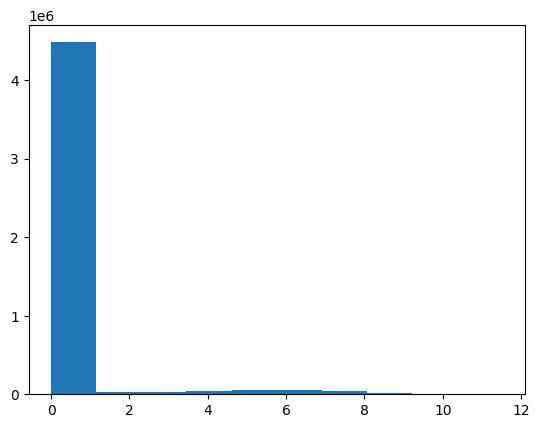

In [236]:
plt.hist(np.log(content_df['concentration'].fillna(0)+1));

This looks great, the vast majority of compounds will be very close to zero concentrations, whilst almost none are near 100% concentration.

## Investigating Duplicate `orig_food`s

For the recorded food in the food_df, and each of their matched citations, there are sometimes multiple 'original foods' ie. foods coming from the original databases. We could simply average them together, however there is one issue and that is the foods sometimes have vastly differing data eg. between food that is fresh, cooked, dried.

The largest of which is the USDA database, which we know already contains different versions of foods. Now, this database this won't be so much of a problem, because we already have the exact entries that we are trying to match, however it might be a problem for others.

This section explores the solutions to this, composing a selection function similar to that of the df joining functions in the previous join chapter.

In [237]:
content_df[content_df['food_name'].str.lower().str.contains('banana')]

food_name                                  source_name  \
food_id source_id                                                          
208     21594        banana                                         <NA>   
        21595        banana                                         <NA>   
        21595        banana                                         <NA>   
        1131         banana                                      Sucrose   
        753          banana                                      Ethanol   
...                     ...                                          ...   
        124816       banana                           PG(22:0/22:1(13Z))   
        124817       banana       CL(22:0/22:1(13Z)/22:1(13Z)/22:1(13Z))   
        124818       banana                     PGP(22:1(13Z)/22:1(13Z))   
        124819       banana                      PG(22:1(13Z)/22:1(13Z))   
        124820       banana  CL(22:1(13Z)/22:1(13Z)/22:1(13Z)/22:1(13Z))   

                   orig_content orig_unit  orig_min  orig_max orig_citation  \
food_id source_id                                                             
208     21594             100.0   mg/100g      <NA>      <NA>          <NA>   
        21595               0.0   mg/100g      <NA>      <NA>          <NA>   
        21595             100.0   mg/100g      <NA>      <NA>          <NA>   
        1131                0.0   mg/100g      <NA>      <NA>          <NA>   
        753                 0.0   mg/100g      <NA>      <NA>          <NA>   
...                         ...       ...       ...       ...           ...   
        124816             <NA>       NaN      <NA>      <NA>          <NA>   
        124817             <NA>       NaN      <NA>      <NA>          <NA>   
        124818             <NA>       NaN      <NA>      <NA>          <NA>   
        124819             <NA>       NaN      <NA>      <NA>          <NA>   
        124820             <NA>       NaN      <NA>      <NA>          <NA>   

                   citation citation_type       id source_type orig_food_id  \
food_id source_id                                                             
208     21594           DTU      DATABASE   131586    Compound           14   
        21595           DTU      DATABASE   131587    Compound           14   
        21595           DTU      DATABASE   131588    Compound           14   
        1131            DTU      DATABASE   131589    Compound           14   
        753             DTU      DATABASE   131590    Compound           14   
...                     ...           ...      ...         ...          ...   
        124816     PATHBANK     PREDICTED  4361683    Compound          NaN   
        124817     PATHBANK     PREDICTED  4362197    Compound          NaN   
        124818     PATHBANK     PREDICTED  4362711    Compound          NaN   
        124819     PATHBANK     PREDICTED  4363225    Compound          NaN   
        124820     PATHBANK     PREDICTED  4363739    Compound          NaN   

                        orig_food_common_name orig_food_scientific_name  \
food_id source_id                                                         
208     21594                      banana raw                      <NA>   
        21595                      banana raw                      <NA>   
        21595                      banana raw                      <NA>   
        1131                       banana raw                      <NA>   
        753                        banana raw                      <NA>   
...                                       ...                       ...   
        124816     lipid arabidopsis pathbank                      <NA>   
        124817     lipid arabidopsis pathbank                      <NA>   
        124818     lipid arabidopsis pathbank                      <NA>   
        124819     lipid arabidopsis pathbank                      <NA>   
        124820     lipid arabidopsis pathbank                      <NA>  

In [238]:
content_df[(content_df['food_name'] == 'banana') & (content_df['citation'] == 'USDA')]['orig_food_common_name'].unique()

<ArrowStringArray>
[                     'banana raw', 'banana dehydrated banana powder',
      'banana dwarf raw musa nana',                   'banana boiled']
Length: 4, dtype: string

### Showing Duplicate Source Entries

Here we are trying to show the duplicate entries from a citation source. This will be useful during the join to filter only for these entries, saving on compute.

In [239]:
pd.options.mode.chained_assignment = None  # default='warn'

In [240]:
results = {}
for citation in tqdm(content_df['citation'].unique()):
    results[citation] = {}
    citation_selection = content_df[content_df['citation'] == citation]['orig_food_common_name']
    citation_selection.fillna('', inplace=True)
    citation_selection = citation_selection.apply(lambda x: x.replace(',',';'))
    results[citation] = citation_selection.groupby(axis=0, level=0).agg(set)

100%|██████████| 352/352 [00:40<00:00,  8.60it/s]


In [241]:
duplicate_citations = [k for k, v in results.items() if (v.apply(len) > 1).sum() > 0]
print(len(duplicate_citations), duplicate_citations)
with open('../data/globals/molecule/duplicate_citations.json', 'w') as f:
    json.dump({'duplicate_citations': duplicate_citations}, f, ensure_ascii=False)

79 ['DTU', 'USDA', 'PHENOL EXPLORER', 'DUKE', 'MANUAL', '12744680', '12797757', '17071511', '18778075', "Bernalte, M. J., Hernandez, M. T., Vidal-Aragon, M. C. & Sabio, E. (1999) Physical, chemical, flavor and sensory characteristics of two sweet cherry varieties grown in 'Valle del Jerte' (Spain). Journal of Food Quality, 22, 403-416", 'Charles F. Forney and Michael A. Jordan. Induction of Volatile Compounds in Broccoli by Postharvest Hot-Water Dips. J. Agric. Food Chem. 1998, 46, 5295-5301', 'F. Vallejo, F. Tomas-Barberan, C. Garcia-Viguera. Glucosinolates and vitamin C content in edible parts of broccoli florets after domestic cooking. Eur Food Res Technol (2002) 215:310-316', 'Hans-Ulrich Humpf and Peter Schreier. Bound aroma compounds from the fruit and the leaves of blackberry (Rubus laciniata L.) J. Agrie. FoodChem. 1991, 39. 1830-1832 https://pubs.acs.org/doi/pdf/10.1021/jf00010a028', 'Mans Boelens, Pieter J. de Valois, Henk J. Wobben, and Arne van der Gen. Volatile Flavor Comp

### Showing Duplicate Compound Entries

In [242]:
content_df.loc[287].duplicated().head(20)

source_id
21594    False
21595    False
21595    False
1131     False
753      False
3513     False
13393    False
13831    False
13831    False
14616    False
21596    False
12735    False
12814    False
565      False
565      False
12360    False
8417     False
12163    False
1014     False
1014     False
dtype: bool

In [243]:
content_df.drop(['duplicated'], axis=1, inplace=True, errors='ignore')

In [244]:
content_df['duplicated'] = False
for food_idx in tqdm(content_df.index.get_level_values(0).unique()):
    selected_df = content_df.loc[food_idx,:]
    content_df.loc[food_idx, 'duplicated'] = selected_df.index.duplicated(keep='first')

content_df[content_df['duplicated'] == True].shape

  0%|          | 0/814 [00:00<?, ?it/s]

/tmp/ipykernel_10599/3869640213.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  content_df.loc[food_idx, 'duplicated'] = selected_df.index.duplicated(keep='first')
100%|██████████| 814/814 [00:13<00:00, 59.34it/s]


(1248580, 30)

In [245]:
example_df = content_df.loc[287]
example_df.shape

(5980, 30)

In [246]:
example_df[example_df['duplicated'] == True].shape

(275, 30)

In [247]:
example_df[example_df['duplicated'] == True].head(10)

,food_name,source_name,orig_content,orig_unit,orig_min,orig_max,orig_citation,citation,citation_type,id,source_type,orig_food_id,orig_food_common_name,orig_food_scientific_name,orig_food_part,orig_source_id,orig_source_name,creator_id,updater_id,created_at,updated_at,orig_method,orig_unit_expression,standard_content,preparation_type,export,selected_source_name,unit_cleaned,concentration,duplicated
source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21595,alfalfa,<NA>,0.0,mg/100g,<NA>,<NA>,<NA>,DTU,DATABASE,128667,Compound,868,alfalfa seed,<NA>,<NA>,6,"Fatty acids, total poly-unsaturated",<NA>,<NA>,2014-11-05 14:54:39 UTC,2019-12-11 20:28:23 UTC,<NA>,<NA>,0.0,other,0,"Fatty acids, total mono-unsaturated",mg/100g,0.0,True
13831,alfalfa,Retinol,0.0,mg/100g,<NA>,<NA>,<NA>,DTU,DATABASE,128673,Compound,868,alfalfa seed,<NA>,<NA>,15,Vitamin A (retinol),<NA>,<NA>,2014-11-05 14:54:39 UTC,2019-12-11 20:28:23 UTC,<NA>,<NA>,0.0,other,0,Retinol,mg/100g,0.0,True
565,alfalfa,alpha-Tocopherol,0.0,mg/100g,<NA>,<NA>,<NA>,DTU,DATABASE,128679,Compound,868,alfalfa seed,<NA>,<NA>,27,"Vitamin E, alpha tocopherol",<NA>,<NA>,2014-11-05 14:54:39 UTC,2019-12-11 20:28:23 UTC,<NA>,<NA>,0.0,other,0,alpha-Tocopherol,mg/100g,0.0,True
1014,alfalfa,Nicotinic acid,0.0,mg/100g,<NA>,<NA>,<NA>,DTU,DATABASE,128685,Compound,868,alfalfa seed,<NA>,<NA>,40,"Niacin, from tryptophan",<NA>,<NA>,2014-11-05 14:54:39 UTC,2019-12-11 20:28:23 UTC,<NA>,<NA>,0.0,other,0,Nicotinic acid,mg/100g,0.0,True
1224,alfalfa,L-Ascorbic acid,0.0,mg/100g,<NA>,<NA>,<NA>,DTU,DATABASE,128692,Compound,868,alfalfa seed,<NA>,<NA>,51,"Vitamin C, L-ascorbic acid",<NA>,<NA>,2014-11-05 14:54:40 UTC,2019-12-11 20:28:23 UTC,<NA>,<NA>,0.0,other,0,L-Ascorbic acid,mg/100g,0.0,True
21594,alfalfa,<NA>,100.0,mg/100g,<NA>,<NA>,<NA>,DTU,DATABASE,128707,Compound,683,alfalfa seed sprouted raw,<NA>,<NA>,4,"Fatty acids, total saturated",<NA>,<NA>,2014-11-05 14:54:40 UTC,2019-12-11 20:28:23 UTC,<NA>,<NA>,100.0,raw,0,"Fatty acids, total saturated",mg/100g,100.0,True
21595,alfalfa,<NA>,100.0,mg/100g,<NA>,<NA>,<NA>,DTU,DATABASE,128708,Compound,683,alfalfa seed sprouted raw,<NA>,<NA>,5,"Fatty acids, total mono-unsaturated",<NA>,<NA>,2014-11-05 14:54:40 UTC,2019-12-11 20:28:23 UTC,<NA>,<NA>,100.0,raw,0,"Fatty acids, total mono-unsaturated",mg/100g,100.0,True
21595,alfalfa,<NA>,400.0,mg/100g,<NA>,<NA>,<NA>,DTU,DATABASE,128709,Compound,683,alfalfa seed sprouted raw,<NA>,<NA>,6,"Fatty acids, total poly-unsaturated",<NA>,<NA>,2014-11-05 14:54:40 UTC,2019-12-11 20:28:23 UTC,<NA>,<NA>,400.0,raw,0,"Fatty acids, total mono-unsaturated",mg/100g,400.0,True
1131,alfalfa,Sucrose,0.0,mg/100g,<NA>,<NA>,<NA>,DTU,DATABASE,128710,Compound,683,alfalfa seed sprouted raw,<NA>,<NA>,9,"Carbohydrates, added sugar (sucrose)",<NA>,<NA>,2014-11-05 14:54:40 UTC,2019-12-11 20:28:23 UTC,<NA>,<NA>,0.0,raw,0,Sucrose,mg/100g,0.0,True


In [248]:
example_df.loc[1131]

,food_name,source_name,orig_content,orig_unit,orig_min,orig_max,orig_citation,citation,citation_type,id,source_type,orig_food_id,orig_food_common_name,orig_food_scientific_name,orig_food_part,orig_source_id,orig_source_name,creator_id,updater_id,created_at,updated_at,orig_method,orig_unit_expression,standard_content,preparation_type,export,selected_source_name,unit_cleaned,concentration,duplicated
source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1131,alfalfa,Sucrose,0.0,mg/100g,<NA>,<NA>,<NA>,DTU,DATABASE,128668,Compound,868,alfalfa seed,<NA>,<NA>,9,"Carbohydrates, added sugar (sucrose)",<NA>,<NA>,2014-11-05 14:54:39 UTC,2019-12-11 20:28:23 UTC,<NA>,<NA>,0.0,other,0,Sucrose,mg/100g,0.0,False
1131,alfalfa,Sucrose,0.0,mg/100g,<NA>,<NA>,<NA>,DTU,DATABASE,128710,Compound,683,alfalfa seed sprouted raw,<NA>,<NA>,9,"Carbohydrates, added sugar (sucrose)",<NA>,<NA>,2014-11-05 14:54:40 UTC,2019-12-11 20:28:23 UTC,<NA>,<NA>,0.0,raw,0,Sucrose,mg/100g,0.0,True
1131,alfalfa,Sucrose,0.0,mg/100g,<NA>,<NA>,<NA>,DTU,DATABASE,128753,Compound,683,alfalfa seed sprouted raw,<NA>,<NA>,132,Sucrose,<NA>,<NA>,2014-11-05 14:54:41 UTC,2019-12-11 20:28:23 UTC,<NA>,<NA>,0.0,raw,0,Sucrose,mg/100g,0.0,True
1131,alfalfa,Sucrose,0.0,mg/100g,<NA>,<NA>,<NA>,USDA,DATABASE,386385,Compound,11001,alfalfa seed sprouted raw,<NA>,<NA>,210,Sucrose,<NA>,<NA>,2014-11-05 15:55:24 UTC,2019-12-11 20:47:32 UTC,<NA>,<NA>,0.0,raw,0,Sucrose,mg/100g,0.0,True
1131,alfalfa,Sucrose,0.0,mg/100 g,<NA>,<NA>,<NA>,DTU,DATABASE,1739504,Compound,868.0,alfalfa seed,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,2019-08-03 15:31:02 UTC,2019-08-03 15:31:02 UTC,<NA>,<NA>,0.0,other,1,Sucrose,mg/100g,0.0,True
1131,alfalfa,Sucrose,0.0,mg/100 g,<NA>,<NA>,<NA>,DTU,DATABASE,1739548,Compound,868.0,alfalfa seed,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,2019-08-03 15:31:03 UTC,2019-08-03 15:31:03 UTC,<NA>,<NA>,0.0,other,1,Sucrose,mg/100g,0.0,True
1131,alfalfa,Sucrose,0.0,mg/100 g,<NA>,<NA>,<NA>,DTU,DATABASE,1739549,Compound,868.0,alfalfa seed,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,2019-08-03 15:31:03 UTC,2019-08-03 15:31:03 UTC,<NA>,<NA>,0.0,other,1,Sucrose,mg/100g,0.0,True
1131,alfalfa,Sucrose,0.0,mg/100 g,<NA>,<NA>,<NA>,DTU,DATABASE,1739613,Compound,683.0,alfalfa seed sprouted raw,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,2019-08-03 15:31:05 UTC,2019-08-03 15:31:05 UTC,<NA>,<NA>,0.0,raw,1,Sucrose,mg/100g,0.0,True
1131,alfalfa,Sucrose,0.0,mg/100 g,<NA>,<NA>,<NA>,DTU,DATABASE,1739657,Compound,683.0,alfalfa seed sprouted raw,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,2019-08-03 15:31:05 UTC,2019-08-03 15:31:05 UTC,<NA>,<NA>,0.0,raw,1,Sucrose,mg/100g,0.0,True


## Selecting `orig_food_part`

Similarly to the above, for many of the `orig_foods` there is also an `orig_food_part`. Again, taking averages of these isn't the best as some parts of the food are not eaten and have vastly different composition. Eg. fruit vs stem.

In [249]:
content_df[content_df['orig_food_part'].notnull()].value_counts('citation')

citation
DUKE                                                                                                                                                                                                                                                                                                39199
Timo Hirvi and Erkki Honkanen. The arome of blueberries. J. Sci. Food Agric. 1983, 34, 992-998. DOI: 10.1002/jsfa.2740340916                                                                                                                                                                           48
S.Hakkinen, M. Heinonen, S. Karenlampi, H. Mykkanen, J. Ruuskanen, R. Torronen. Screening of selected flavonoids and phenolic acids in 19 berries. Food Research International 32 (1999) 345-353. https://www.sciencedirect.com/science/article/pii/S0963996999000952                                  35
17071511                                                                                         

Out of these studies, which of these actually contain duplicate values for its food parts?

In [250]:
content_df[content_df['orig_food_part'].notnull()].groupby('citation').apply(lambda df: df.groupby('orig_food_id').apply(lambda d: d['orig_food_part'].nunique() > 1))

food_name source_name  orig_content orig_unit  orig_min  \
citation orig_food_id                                                           
DUKE     328.0             <NA>        <NA>          <NA>       NaN      <NA>   
         357.0             <NA>        <NA>          <NA>       NaN      <NA>   
         1                 <NA>        <NA>          <NA>       NaN      <NA>   
         1005              <NA>        <NA>          <NA>       NaN      <NA>   
         101               <NA>        <NA>          <NA>       NaN      <NA>   
...                         ...         ...           ...       ...       ...   
         957               <NA>        <NA>          <NA>       NaN      <NA>   
         96                <NA>        <NA>          <NA>       NaN      <NA>   
         986               <NA>        <NA>          <NA>       NaN      <NA>   
         992               <NA>        <NA>          <NA>       NaN      <NA>   
         995               <NA>        <NA>          <NA>       NaN      <NA>   

                       orig_max orig_citation citation citation_type    id  \
citation orig_food_id                                                        
DUKE     328.0             <NA>          <NA>      NaN          <NA>  <NA>   
         357.0             <NA>          <NA>      NaN          <NA>  <NA>   
         1                 <NA>          <NA>      NaN          <NA>  <NA>   
         1005              <NA>          <NA>      NaN          <NA>  <NA>   
         101               <NA>          <NA>      NaN          <NA>  <NA>   
...                         ...           ...      ...           ...   ...   
         957               <NA>          <NA>      NaN          <NA>  <NA>   
         96                <NA>          <NA>      NaN          <NA>  <NA>   
         986               <NA>          <NA>      NaN          <NA>  <NA>   
         992               <NA>          <NA>      NaN          <NA>  <NA>   
         995               <NA>          <NA>      NaN          <NA>  <NA>   

                      source_type orig_food_id orig_food_common_name  \
citation orig_food_id                                                  
DUKE     328.0               <NA>          NaN                  <NA>   
         357.0               <NA>          NaN                  <NA>   
         1                   <NA>          NaN                  <NA>   
         1005                <NA>          NaN                  <NA>   
         101                 <NA>          NaN                  <NA>   
...                           ...          ...                   ...   
         957                 <NA>          NaN                  <NA>   
         96                  <NA>          NaN                  <NA>   
         986                 <NA>          NaN                  <NA>   
         992                 <NA>          NaN                  <NA>   
         995                 <NA>          NaN                  <NA>   

                      orig_food_scientific_name orig_food_part orig_source_id  \
citation orig_food_id                                                           
DUKE     328.0                             <NA>           <NA>            NaN   
         357.0                             <NA>           <NA>            NaN   
         1                                 <NA>           <NA>            NaN   
         1005                              <NA>           <NA>            NaN   
         101                               <NA>           <NA>            NaN   
...                                         ...            ...            ...   
         957                               <NA>           <NA>            NaN   
         96                                <NA>           <NA>            NaN   
         986                               <NA>           <NA>            NaN   
         992                               <NA>           <NA>            NaN   
         995                               <

Okay this is good, that means we just need to focus on a single citation.

In [251]:
df = content_df[content_df['citation'] == 'DUKE']

In [252]:
food_parts_df = df.groupby('orig_food_id').apply(lambda d: d['orig_food_part'].unique()).to_frame('food_parts')

In [253]:
id_food_name_map = pd.Series({orig_id: df[df['orig_food_id'] == orig_id].iloc[0]['food_name'] for orig_id in df['orig_food_id'].unique()})
food_parts_df['food_name'] = id_food_name_map

In [254]:
food_parts_df.head(40)

,food_parts,food_name
orig_food_id,,
328.0,[Fruit],green zucchini
357.0,"[Root, Shoot, Plant, Leaf, Seed, Tissue Cultur...",carrot
1,"[Fruit, Oil, Seed, Root, Flower, Leaf, Plant]",okra
1005,[Leaf],spinach
101,"[Seed, Oil, Plant, Leaf, Sprout Seedling]",peanut
1010,"[Seed, Petiole, Testa, Plant, Leaf, Fruit, Flo...",cocoa bean
1016,"[Plant, Essential Oil, Leaf, Inflorescence, Sh...",common thyme
1017,"[Fruit, Flower, Wood, Leaf, Bark]",linden
1019,"[Plant, Root, Seed]",common salsify


This looks to be a study of plants. We eat different parts of plants, but I think what we could do here is select it in an ordered availability.

ie.

In [255]:
def select_food_part(food_parts):
    if len(food_parts) == 1: # no selection needed
        return food_parts[0]
    for part in ['Fruit', 'Seed', 'Root', 'Leaf', 'Herb', 'Plant']:
        if part in food_parts:
            return part

In [256]:
food_parts_df['selected'] = food_parts_df['food_parts'].apply(select_food_part)
food_parts_df[food_parts_df['selected'].isnull()]

,food_parts,food_name,selected
orig_food_id,,,


In [257]:
df = df.join(food_parts_df['selected'], on='orig_food_id')
df

food_name                   source_name  orig_content  \
food_id source_id                                                           
4       1014             kiwi                Nicotinic acid          1.75   
        1111             kiwi                Chinese tannin         950.0   
        1170             kiwi               (-)-Quinic acid          <NA>   
        1224             kiwi               L-Ascorbic acid         356.0   
        1931             kiwi                 Succinic acid          <NA>   
...                       ...                           ...           ...   
1021    22002      herbal tea  Stigmasta-7,24(28)-dien-3-ol          <NA>   
939     22014       black tea            trans-Geranic acid          <NA>   
940     22014       green tea            trans-Geranic acid          <NA>   
957     22014         red tea            trans-Geranic acid          <NA>   
1021    22014      herbal tea            trans-Geranic acid          <NA>   

                  orig_unit  orig_min  orig_max orig_citation citation  \
food_id source_id                                                        
4       1014        mg/100g       0.5       3.0          <NA>     DUKE   
        1111        mg/100g     950.0     950.0          <NA>     DUKE   
        1170           <NA>      <NA>      <NA>          <NA>     DUKE   
        1224        mg/100g      75.0     637.0          <NA>     DUKE   
        1931           <NA>      <NA>      <NA>          <NA>     DUKE   
...                     ...       ...       ...           ...      ...   
1021    22002           NaN      <NA>      <NA>          <NA>     DUKE   
939     22014           NaN      <NA>      <NA>          <NA>     DUKE   
940     22014           NaN      <NA>      <NA>          <NA>     DUKE   
957     22014           NaN      <NA>      <NA>          <NA>     DUKE   
1021    22014           NaN      <NA>      <NA>          <NA>     DUKE   

                  citation_type       id source_type orig_food_id  \
food_id source_id                                                   
4       1014           DATABASE   687891    Compound           29   
        1111           DATABASE   687892    Compound           29   
        1170           DATABASE   687893    Compound           29   
        1224           DATABASE   687894    Compound           29   
        1931           DATABASE   687895    Compound           29   
...                         ...      ...         ...          ...   
1021    22002          DATABASE  2222262    Compound          198   
939     22014          DATABASE  2222263    Compound          198   
940     22014          DATABASE  2222264    Compound          198   
957     22014          DATABASE  2222265    Compound          198   
1021    22014          DATABASE  2222266    Compound          198   

                  orig_food_common_name  \
food_id source_id                         
4       1014                       kiwi   
        1111                       kiwi   
        1170                       kiwi   
        1224                       kiwi   
        1931                       kiwi   
...                                 ...   
1021    22002                       tea   
939     22014                       tea   
940     22014                       tea   
957     22014                       tea   
1021    22014                       tea   

                                      orig_food_scientific_name  \
food_id source_id                                                 
4       1014       Actinidia chinensis PLANCHON [Actinidiaceae]   
        1111       Actinidia chinensis PLANCHON [Actinidiaceae]   
        1170       Actinidia chinensis PLANCHON [Actinidiaceae]   
        1224       Actinidia chinensis PLANCHON [Actinidiaceae]   
        1931       Actinidia chinensis PLANCHON [Actinidiaceae]   
...                                                         ...   
1021    22002          Camellia sinensis (L.) KUNTZE [Theacea

In [258]:
idxs = df[~(df['orig_food_part'] == df['selected'])].index
content_df.drop(idxs, inplace=True)
content_df.shape

(4664512, 30)

## Export Column Selection

In [259]:
content_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4664512 entries, (287, 21594) to (1026, 13358)
Data columns (total 30 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   food_name                  string 
 1   source_name                string 
 2   orig_content               Float64
 3   orig_unit                  object 
 4   orig_min                   Float64
 5   orig_max                   Float64
 6   orig_citation              string 
 7   citation                   object 
 8   citation_type              string 
 9   id                         Int64  
 10  source_type                string 
 11  orig_food_id               object 
 12  orig_food_common_name      string 
 13  orig_food_scientific_name  string 
 14  orig_food_part             string 
 15  orig_source_id             object 
 16  orig_source_name           string 
 17  creator_id                 Float64
 18  updater_id                 Float64
 19  created_at               

In [260]:
content_df = content_df[['food_name', 'selected_source_name', 'concentration', 'orig_citation', 'citation', 'orig_food_id', 'orig_food_common_name', 'orig_food_part']]
content_df = content_df.rename({'selected_source_name': 'source_name'}, axis=1)
content_df 

food_name  \
food_id source_id                           
287     21594                     alfalfa   
        21595                     alfalfa   
        21595                     alfalfa   
        1131                      alfalfa   
        753                       alfalfa   
...                                   ...   
611     139988             rock ptarmigan   
624     139988     columbidae dove pigeon   
1025    15423                 baking soda   
1026    15423               baking powder   
        13358               baking powder   

                                           source_name concentration  \
food_id source_id                                                      
287     21594             Fatty acids, total saturated           0.0   
        21595      Fatty acids, total mono-unsaturated           0.0   
        21595      Fatty acids, total mono-unsaturated           0.0   
        1131                                   Sucrose           0.0   
        753                                    Ethanol           0.0   
...                                                ...           ...   
611     139988           TG(a-17:0/a-21:0/a-25:0)[rac]          <NA>   
624     139988           TG(a-17:0/a-21:0/a-25:0)[rac]          <NA>   
1025    15423                Sodium hydrogen carbonate      100000.0   
1026    15423                Sodium hydrogen carbonate       30000.0   
        13358                  Calcium phosphate (1:1)       10000.0   

                  orig_citation     citation orig_food_id  \
food_id source_id                                           
287     21594              <NA>          DTU          868   
        21595              <NA>          DTU          868   
        21595              <NA>          DTU          868   
        1131               <NA>          DTU          868   
        753                <NA>          DTU          868   
...                         ...          ...          ...   
611     139988             <NA>         HMDB          NaN   
624     139988             <NA>         HMDB          NaN   
1025    15423              <NA>  MANUAL_HAND          NaN   
1026    15423              <NA>  MANUAL_HAND          NaN   
        13358              <NA>  MANUAL_HAND          NaN   

                            orig_food_common_name orig_food_part  
food_id source_id                                                 
287     21594                        alfalfa seed           <NA>  
        21595                        alfalfa seed           <NA>  
        21595                        alfalfa seed           <NA>  
        1131                         alfalfa seed           <NA>  
        753                          alfalfa seed           <NA>  
...                                           ...            ...  
611     139988     endogenous compound human hmdb           <NA>  
624     139988     endogenous compound human hmdb           <NA>  
1025    15423                                               <NA>  
1026    15423                                               <NA>  
        13358                                               <NA>  

[4664512 rows x 8 columns]

In [261]:
content_df = content_df.convert_dtypes()
content_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4664512 entries, (287, 21594) to (1026, 13358)
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   food_name              string 
 1   source_name            string 
 2   concentration          Float64
 3   orig_citation          string 
 4   citation               string 
 5   orig_food_id           object 
 6   orig_food_common_name  string 
 7   orig_food_part         string 
dtypes: Float64(1), object(1), string(6)
memory usage: 536.8+ MB


In [262]:
content_df['orig_food_id'] = content_df['orig_food_id'].astype(str)

## Formatting dtypes

### orig_food_id

As this column will be used in the next section, we want to format it appropriately to increase efficiency.

In [263]:
def is_number(s):
    if pd.isnull(s): return False
    for w in s.split('.'):
        if not w.isnumeric():
            return False
    return True

In [264]:
print(list(content_df[~content_df['orig_food_id'].apply(is_number)]['orig_food_id'].unique()))

['616|618', 'nan', 'WI5000', 'WI1600', 'WI6500', 'WI2700', 'WI1000', 'WI2200', 'WI4600', 'WI3500', 'WI4700', 'WI1500', 'WI4000', 'WI2000', 'WI3000', 'WI3200', 'WI4400', 'WI1800', 'WI3700', 'WI4200', 'WI3800', 'WI2500', 'WI6700', 'WI7200', 'WI7900', 'WI7000']


#### "|"

In [265]:
content_df[content_df['orig_food_id'].str.contains("\|")]

,,food_name,source_name,concentration,orig_citation,citation,orig_food_id,orig_food_common_name,orig_food_part
food_id,source_id,,,,,,,,
112,2680,spearmint,Hesperidin,<NA>,<NA>,DUKE,616|618,biblical mint | hortela da folha miuda,Plant


It looks like the issue here is when this involves an or "|" sign.

In [266]:
content_df[content_df['orig_food_id'] == "616|618"]

,,food_name,source_name,concentration,orig_citation,citation,orig_food_id,orig_food_common_name,orig_food_part
food_id,source_id,,,,,,,,
112,2680,spearmint,Hesperidin,<NA>,<NA>,DUKE,616|618,biblical mint | hortela da folha miuda,Plant


Does DUKE have content with id's 616 or 618?

In [267]:
content_df[(content_df['citation'] == 'DUKE') & (content_df['orig_food_id'] == '618')].head()

food_name source_name  concentration orig_citation  \
food_id source_id                                                       
112     446        spearmint  L-Tyrosine           <NA>          <NA>   
        465        spearmint      Valine           <NA>          <NA>   
        474        spearmint    L-Lysine           <NA>          <NA>   
        484        spearmint     Glycine           <NA>          <NA>   
        556        spearmint   L-Alanine           <NA>          <NA>   

                  citation orig_food_id   orig_food_common_name orig_food_part  
food_id source_id                                                               
112     446           DUKE          618  hortela da folha miuda           Leaf  
        465           DUKE          618  hortela da folha miuda           Leaf  
        474           DUKE          618  hortela da folha miuda           Leaf  
        484           DUKE          618  hortela da folha miuda           Leaf  
        556           DUKE          618  hortela da folha miuda           Leaf

What is this either/or deal. Has the food_db parsing included this information in both ingredients?

In [268]:
results = {}
for source in content_df[content_df['orig_food_id'] == "616|618"].index.get_level_values(1):
    selected_df = content_df[content_df.index.get_level_values(1) == source]
    results[source] = (selected_df[selected_df['orig_food_id'] == str(616)].empty, selected_df[(selected_df['orig_food_id'] == str(618))].empty)

results

{2680: (True, True)}

In [269]:
df = content_df[content_df['orig_food_id'] == "616|618"]
df

,,food_name,source_name,concentration,orig_citation,citation,orig_food_id,orig_food_common_name,orig_food_part
food_id,source_id,,,,,,,,
112,2680,spearmint,Hesperidin,<NA>,<NA>,DUKE,616|618,biblical mint | hortela da folha miuda,Plant


In [270]:
for id in [616, 618]:
    existing_source_idxs = content_df.index[(content_df['citation'] == 'DUKE') & (content_df['orig_food_id'] == str(id))].get_level_values(1)
    df_copy = df.copy(deep=True)
    df_copy = df_copy[~df_copy.index.get_level_values(1).isin(existing_source_idxs)]
    df_copy['orig_food_id'] = str(id)
    df_copy['orig_food_common_name'] = content_df[(content_df['citation'] == 'DUKE') & (content_df['orig_food_id'] == str(id))].iloc[0]['orig_food_common_name']
    content_df = pd.concat([content_df, df_copy])

content_df.drop(df.index, axis=0, inplace=True)

#### "nan"

In [271]:
content_df['orig_food_id'].replace('nan', '', inplace=True)

#### W*

In [272]:
content_df[content_df['orig_food_id'].str.startswith('W')].value_counts('citation')

citation
DFC CODES    19972
Name: count, dtype: int64

In [273]:
content_df[content_df['citation'] == 'DFC CODES'].value_counts('orig_food_id')

orig_food_id
WI4600    5649
WI3500    2199
WI5000    2119
WI3800    1461
WI1600    1422
WI1000    1114
WI4400     930
WI6500     767
WI2700     759
WI2200     622
WI4000     615
WI2000     406
WI3000     386
WI3700     265
WI2500     222
WI4200     199
WI3200     197
WI1800     153
WI4700     117
WI1500     106
WI7200     105
WI7900      99
WI7000      40
WI6700      20
Name: count, dtype: int64

We can just reset these food_ids for our own use. 

In [274]:
food_id_map = {v: str(k) for k, v in enumerate(content_df[content_df['citation'] == 'DFC CODES']['orig_food_id'].unique())}
food_id_map

{'WI5000': '0',
 'WI1600': '1',
 'WI6500': '2',
 'WI2700': '3',
 'WI1000': '4',
 'WI2200': '5',
 'WI4600': '6',
 'WI3500': '7',
 'WI4700': '8',
 'WI1500': '9',
 'WI4000': '10',
 'WI2000': '11',
 'WI3000': '12',
 'WI3200': '13',
 'WI4400': '14',
 'WI1800': '15',
 'WI3700': '16',
 'WI4200': '17',
 'WI3800': '18',
 'WI2500': '19',
 'WI6700': '20',
 'WI7200': '21',
 'WI7900': '22',
 'WI7000': '23'}

In [275]:
content_df.loc[content_df['citation'] == 'DFC CODES', 'orig_food_id'] = content_df[content_df['citation'] == 'DFC CODES']['orig_food_id'].replace(food_id_map)

In [276]:
content_df[content_df['citation'] == 'DFC CODES']['orig_food_id'].unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype=object)

In [277]:
content_df['orig_food_id'] = content_df['orig_food_id'].astype('string')

In [278]:
content_df[content_df['citation'] == 'DFC CODES']['orig_food_id'].astype(str)

food_id  source_id
897      367           0
885      370           1
894      373           2
904      375           3
273      377           4
                      ..
58       21463        14
         21484        14
         21560        14
         21565        14
         21570        14
Name: orig_food_id, Length: 19972, dtype: object

#### Finalising

In [279]:
content_df[~content_df['orig_food_id'].str.isnumeric()]['orig_food_id'].unique()

<StringArray>
[       '',   '470.0',   '328.0',   '402.0', '11477.0', '11478.0', '11479.0',
 '11480.0', '11481.0', '11861.0',
 ...
 '42290.0',  '1089.0',  '1084.0',  '1083.0',  '1151.0',  '1078.0',  '1081.0',
  '1174.0',  '1211.0',  '2129.0']
Length: 1240, dtype: string

In [280]:
content_df['orig_food_id'].replace(str(pd.NA), np.nan, inplace=True)
content_df['orig_food_id'].replace('', np.nan, inplace=True)
content_df['orig_food_id'] = content_df['orig_food_id'].astype('Float64').astype('Int64')

In [281]:
content_df['orig_food_id']

food_id  source_id
287      21594         868
         21595         868
         21595         868
         1131          868
         753           868
                      ... 
611      139988       <NA>
624      139988       <NA>
1025     15423        <NA>
1026     15423        <NA>
         13358        <NA>
Name: orig_food_id, Length: 4664511, dtype: Int64

### Remaining

In [282]:
content_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4664511 entries, (287, 21594) to (1026, 13358)
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   food_name              string 
 1   source_name            string 
 2   concentration          Float64
 3   orig_citation          string 
 4   citation               string 
 5   orig_food_id           Int64  
 6   orig_food_common_name  object 
 7   orig_food_part         string 
dtypes: Float64(1), Int64(1), object(1), string(5)
memory usage: 451.4+ MB


In [283]:
content_df['orig_food_common_name'] = content_df['orig_food_common_name'].astype('string')

In [284]:
content_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4664511 entries, (287, 21594) to (1026, 13358)
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   food_name              string 
 1   source_name            string 
 2   concentration          Float64
 3   orig_citation          string 
 4   citation               string 
 5   orig_food_id           Int64  
 6   orig_food_common_name  string 
 7   orig_food_part         string 
dtypes: Float64(1), Int64(1), string(6)
memory usage: 451.4 MB


## Syncing DFs (2)

The DFs would have fallen out of sync through the various filters that were applied on the content_df.

In [285]:
content_df_foods = content_df.index.get_level_values(0).unique()
food_df_foods = food_df.index.unique()

missing_content_df_foods = [food for food in content_df_foods if food not in food_df_foods]
missing_food_df_foods = [food for food in food_df_foods if food not in content_df_foods]

print(len(missing_content_df_foods), missing_content_df_foods)
print(len(missing_food_df_foods), missing_food_df_foods)

0 []
16 [528, 921, 922, 923, 924, 969, 970, 972, 973, 974, 975, 976, 977, 978, 979, 1006]


In [286]:
food_df.loc[missing_food_df_foods]['name']

id
528                                 pacific halibut
921     cow milk pasteurized vitamin + added 0% fat
922     cow milk pasteurized vitamin + added 1% fat
923     cow milk pasteurized vitamin + added 2% fat
924     cow milk pasteurized vitamin added 325% fat
969                                     almond milk
970                                    coconut milk
972                                   sunflower oil
973                                     coconut oil
974                                      peanut oil
975                                  cottonseed oil
976                                        corn oil
977                                     avocado oil
978                                   grapeseed oil
979                                      sesame oil
1006                              japanese sea bass
Name: name, dtype: object

Are these important? Particularly looking for ingredients which might not have an alternative.

In [287]:
food_df['name'][food_df['name'].str.contains('oil')]

id
605              oil palm
801     oil-seed camellia
804           cooking oil
894               fat oil
941             olive oil
944           linseed oil
945          rapeseed oil
946           soybean oil
954            canola oil
972         sunflower oil
973           coconut oil
974            peanut oil
975        cottonseed oil
976              corn oil
977           avocado oil
978         grapeseed oil
979            sesame oil
1022             fish oil
Name: name, dtype: object

These do have alternatives, so I think this should be fine.

In [288]:
food_df = food_df[~food_df.index.isin(missing_food_df_foods)]

In [289]:
food_df.shape

(814, 8)

## Ordering Index

Considerable indexing efficiency improvements.

In [290]:
content_df = content_df.sort_index()

# Postprocessing

## Additional Information

When doing joins and selections on foods, it's handy to have as much information to select our most preferred matches. The quantity/quality of the contents of food is important here. Lets have this as a statistic.

In [291]:
def get_content_df_size(food):
    return content_df.loc[food.name].shape[0]

food_df['n_content'] = food_df.apply(get_content_df_size, axis=1)

# Splitting Foods by Preparation Variations

One thing here is that we'd want to expand on the ingredients on variations which change them eg. dried, cooked, ground. This can be done by searching each food's sources for these keywords, and separating these out into their own entries.

In [292]:
food_id = food_df.index[food_df['name'].str.lower().str.contains('apricot')]
food_contents = content_df.loc[food_id]
food_contents[food_contents['orig_food_common_name'].str.lower().str.contains('dried')]

food_name                               source_name  \
food_id source_id                                                       
144     446         apricot                                L-Tyrosine   
        446         apricot                                L-Tyrosine   
        446         apricot                                L-Tyrosine   
        446         apricot                                L-Tyrosine   
        446         apricot                                L-Tyrosine   
...                     ...                                       ...   
        21981       apricot                                     C24:0   
        21981       apricot                                     C24:0   
        21989       apricot  7Z,10Z,13Z,16Z,19Z-Docosapentaenoic acid   
        23049       apricot                                 Cobalamin   
        24096       apricot                           D-Aspartic acid   

                   concentration orig_citation citation  orig_food_id  \
food_id source_id                                                       
144     446                 36.0          <NA>      DTU             1   
        446                 39.0          <NA>     USDA          9032   
        446                 14.0          <NA>     USDA          9033   
        446                 27.0          <NA>     USDA          9034   
        446                 36.0          <NA>      DTU             1   
...                          ...           ...      ...           ...   
        21981                0.0          <NA>      DTU             1   
        21981                0.0          <NA>     USDA          9032   
        21989                0.0          <NA>      DTU             1   
        23049                0.0          <NA>      DTU             1   
        24096              580.0          <NA>      DTU             1   

                                               orig_food_common_name  \
food_id source_id                                                      
144     446                                            apricot dried   
        446                          apricot dried sulfured uncooked   
        446        apricot dried sulfured stewed without added sugar   
        446                apricot dried sulfured stewed added sugar   
        446                                            apricot dried   
...                                                              ...   
        21981                                          apricot dried   
        21981                        apricot dried sulfured uncooked   
        21989                                          apricot dried   
        23049                                          apricot dried   
        24096                                          apricot dried   

                  orig_food_part  
food_id source_id                 
144     446                 <NA>  
        446                 <NA>  
        446                 <NA>  
        446                 <NA>  
        446                 <NA>  
...                          ...  
        21981               <NA>  
        21981               <NA>  
        21989               <NA>  
        23049               <NA>  
        24096               <NA>  

[312 rows x 8 columns]

In [293]:
keywords = ['dried', 'cook']
grouped = content_df.copy(deep=True)
grouped['orig_food_common_name'] = grouped['orig_food_common_name'].str.lower()

def split_foods_on_keywords(content_df, keywords):

    grouped = content_df.copy(deep=True)
    grouped['orig_food_common_name'] = grouped['orig_food_common_name'].str.lower()

    for keyword in keywords:
        grouped = grouped.groupby('food_id', as_index=True).apply(
            lambda item: item.groupby(item['orig_food_common_name'].str.contains(keyword), as_index=False).apply(lambda item: item)
        )
        grouped = grouped.droplevel(2)
        grouped.index = grouped.index.rename(['food_id', f'keyword_match_{keyword}', 'source_id'])
        grouped = grouped.reset_index().set_index(['food_id', 'source_id'])

    return grouped

split_foods_df = split_foods_on_keywords(content_df, keywords)
split_foods_df

keyword_match_cook  keyword_match_dried      food_name  \
food_id source_id                                                           
1       236                         0                    0       angelica   
        316                         0                    0       angelica   
        432                         0                    0       angelica   
        442                         0                    0       angelica   
        446                         0                    0       angelica   
...                               ...                  ...            ...   
1024    124819                      0                    0  tostada shell   
        124820                      0                    0  tostada shell   
1025    15423                       0                    0    baking soda   
1026    13358                       0                    0  baking powder   
        15423                       0                    0  baking powder   

                                                   source_name  concentration  \
food_id source_id                                                               
1       236                           5-p-Coumaroylquinic acid           <NA>   
        316                     3,4-Dihydroxyphenylacetic acid           <NA>   
        432                                        Moupinamide           <NA>   
        442                                 2'-Hydroxydaidzein           <NA>   
        446                                         L-Tyrosine           <NA>   
...                                                        ...            ...   
1024    124819                         PG(22:1(13Z)/22:1(13Z))           <NA>   
        124820     CL(22:1(13Z)/22:1(13Z)/22:1(13Z)/22:1(13Z))           <NA>   
1025    15423                        Sodium hydrogen carbonate       100000.0   
1026    13358                          Calcium phosphate (1:1)        10000.0   
        15423                        Sodium hydrogen carbonate        30000.0   

                  orig_citation     citation  orig_food_id  \
food_id source_id                                            
1       236                <NA>       MANUAL          <NA>   
        316                <NA>       MANUAL          <NA>   
        432                <NA>       MANUAL          <NA>   
        442                <NA>       MANUAL          <NA>   
        446                <NA>       MANUAL          <NA>   
...                         ...          ...           ...   
1024    124819             <NA>     PATHBANK          <NA>   
        124820             <NA>     PATHBANK          <NA>   
1025    15423              <NA>  MANUAL_HAND          <NA>   
1026    13358              <NA>  MANUAL_HAND          <NA>   
        15423              <NA>  MANUAL_HAND          <NA>   

                        orig_food_common_name orig_food_part  
food_id source_id                                             
1       236                                             <NA>  
        316                                             <NA>  
        432                                             <NA>  
        442                                             <NA>  
        446                                             <NA>  
...                                       ...            ...  
1024    124819     lipid arabidopsis pathbank           <NA>  
        124820     lipid arabidopsis pathbank           <NA>  
1025    15423                                           <NA>  
1026    13358                                           <NA>  
        15423                                           <NA>  

[4664511 rows x 10 columns]

In [294]:
assert split_foods_df.shape[0] == content_df.shape[0]
assert not split_foods_df[split_foods_df['keyword_match_dried'] == 1].empty

In [295]:
def reindex_split_foods(split_foods_df, keywords):    

    reindexed = split_foods_df.copy(deep=True)
    reindexed['food_id_new'] = reindexed.index.get_level_values(0)

    for keyword in keywords:

        # reindexing based on unique 'food_id' and 'keyword_match'
        reindexed = reindexed.reset_index().set_index(['food_id_new',f'keyword_match_{keyword}'])
        keyword_names = reindexed[~reindexed.index.duplicated()]
        keyword_names = keyword_names.reset_index()
        keyword_names.index.rename('food_id_new_keyword', inplace=True)
        index_mapping = keyword_names.reset_index().set_index(['food_id_new', f'keyword_match_{keyword}'])['food_id_new_keyword']

        reindexed = reindexed.reset_index().set_index(['food_id_new', f'keyword_match_{keyword}']).join(index_mapping)
        reindexed = reindexed.reset_index().drop('food_id_new', axis=1).rename({'food_id_new_keyword': 'food_id_new'}, axis=1).set_index(['food_id_new', 'source_id'])

    return reindexed

reindexed_split_foods_df = reindex_split_foods(split_foods_df, keywords)
reindexed_split_foods_df

keyword_match_cook  keyword_match_dried  food_id  \
food_id_new source_id                                                     
0           236                         0                    0        1   
            316                         0                    0        1   
            432                         0                    0        1   
            442                         0                    0        1   
            446                         0                    0        1   
...                                   ...                  ...      ...   
1158        124819                      0                    0     1024   
            124820                      0                    0     1024   
1159        15423                       0                    0     1025   
1160        13358                       0                    0     1026   
            15423                       0                    0     1026   

                           food_name  \
food_id_new source_id                  
0           236             angelica   
            316             angelica   
            432             angelica   
            442             angelica   
            446             angelica   
...                              ...   
1158        124819     tostada shell   
            124820     tostada shell   
1159        15423        baking soda   
1160        13358      baking powder   
            15423      baking powder   

                                                       source_name  \
food_id_new source_id                                                
0           236                           5-p-Coumaroylquinic acid   
            316                     3,4-Dihydroxyphenylacetic acid   
            432                                        Moupinamide   
            442                                 2'-Hydroxydaidzein   
            446                                         L-Tyrosine   
...                                                            ...   
1158        124819                         PG(22:1(13Z)/22:1(13Z))   
            124820     CL(22:1(13Z)/22:1(13Z)/22:1(13Z)/22:1(13Z))   
1159        15423                        Sodium hydrogen carbonate   
1160        13358                          Calcium phosphate (1:1)   
            15423                        Sodium hydrogen carbonate   

                       concentration orig_citation     citation  orig_food_id  \
food_id_new source_id                                                           
0           236                 <NA>          <NA>       MANUAL          <NA>   
            316                 <NA>          <NA>       MANUAL          <NA>   
            432                 <NA>          <NA>       MANUAL          <NA>   
            442                 <NA>          <NA>       MANUAL          <NA>   
            446                 <NA>          <NA>       MANUAL          <NA>   
...                              ...           ...          ...           ...   
1158        124819              <NA>          <NA>     PATHBANK          <NA>   
            124820              <NA>          <NA>     PATHBANK          <NA>   
1159        15423           100000.0          <NA>  MANUAL_HAND          <NA>   
1160        13358            10000.0          <NA>  MANUAL_HAND          <NA>   
            15423            30000.0          <NA>  MANUAL_HAND          <NA>   

                            orig_food_common_name orig_food_part  
food_id_new source_id                                             
0           236                                             <NA>  
            316                                             <NA>  
            432                                             <NA>  
            442                                             <NA>  
            446                                             <NA>  
...                                           ...            ...  
1158        124819     li

In [296]:
original_food_ids = reindexed_split_foods_df.reset_index()[['food_id_new','food_id']]

In [297]:
def rename_split_foods(split_foods_df, keywords):    

    renamed = split_foods_df.reset_index(1).copy(deep=True)
    renamed['food_name_new'] = renamed['food_name']

    for keyword in keywords:

        index_mapping = renamed[~renamed.index.duplicated()][['food_name_new',f'keyword_match_{keyword}']]
        index_mapping = index_mapping.apply(
            lambda item: f" {f'{keyword} ' if item[f'keyword_match_{keyword}'] else ''}" + item['food_name_new'], axis=1
        )
        index_mapping = index_mapping.rename('food_name_new').astype('string')

        renamed = renamed.drop('food_name_new',axis=1).join(index_mapping)

    return renamed

renamed_split_foods_df = rename_split_foods(reindexed_split_foods_df, keywords)
renamed_split_foods_df.reset_index().set_index(['food_id_new', 'source_id'])

keyword_match_cook  keyword_match_dried  food_id  \
food_id_new source_id                                                     
0           236                         0                    0        1   
            316                         0                    0        1   
            432                         0                    0        1   
            442                         0                    0        1   
            446                         0                    0        1   
...                                   ...                  ...      ...   
1158        124819                      0                    0     1024   
            124820                      0                    0     1024   
1159        15423                       0                    0     1025   
1160        13358                       0                    0     1026   
            15423                       0                    0     1026   

                           food_name  \
food_id_new source_id                  
0           236             angelica   
            316             angelica   
            432             angelica   
            442             angelica   
            446             angelica   
...                              ...   
1158        124819     tostada shell   
            124820     tostada shell   
1159        15423        baking soda   
1160        13358      baking powder   
            15423      baking powder   

                                                       source_name  \
food_id_new source_id                                                
0           236                           5-p-Coumaroylquinic acid   
            316                     3,4-Dihydroxyphenylacetic acid   
            432                                        Moupinamide   
            442                                 2'-Hydroxydaidzein   
            446                                         L-Tyrosine   
...                                                            ...   
1158        124819                         PG(22:1(13Z)/22:1(13Z))   
            124820     CL(22:1(13Z)/22:1(13Z)/22:1(13Z)/22:1(13Z))   
1159        15423                        Sodium hydrogen carbonate   
1160        13358                          Calcium phosphate (1:1)   
            15423                        Sodium hydrogen carbonate   

                       concentration orig_citation     citation  orig_food_id  \
food_id_new source_id                                                           
0           236                 <NA>          <NA>       MANUAL          <NA>   
            316                 <NA>          <NA>       MANUAL          <NA>   
            432                 <NA>          <NA>       MANUAL          <NA>   
            442                 <NA>          <NA>       MANUAL          <NA>   
            446                 <NA>          <NA>       MANUAL          <NA>   
...                              ...           ...          ...           ...   
1158        124819              <NA>          <NA>     PATHBANK          <NA>   
            124820              <NA>          <NA>     PATHBANK          <NA>   
1159        15423           100000.0          <NA>  MANUAL_HAND          <NA>   
1160        13358            10000.0          <NA>  MANUAL_HAND          <NA>   
            15423            30000.0          <NA>  MANUAL_HAND          <NA>   

                            orig_food_common_name orig_food_part  \
food_id_new source_id                                              
0           236                                             <NA>   
            316                                             <NA>   
            432                                             <NA>   
            442                                             <NA>   
            446                                             <NA>   
...                                           ...            ...   
1158        12481

There is a bit more work to be done here, but for a MVP this will work. 

- Evaluate new foods content sizes 
- Look into merging content measurements between similar foods - compare water quantity and use that to scale the merges?
- Investigate foods that require filtering - eg. 'vegetarian food'
    - This can be done by looking into what doesn't get joined to the recipes
    - Also manually - only 1000 entries would take 1hr.
- Look into other food variations
    - Look at basic food's orig_food_names to see what else can be split

In [298]:
content_df = renamed_split_foods_df.reset_index().drop(['food_name']+list(renamed_split_foods_df.columns[renamed_split_foods_df.columns.str.startswith('keyword_match')]), axis=1) \
    .rename({'food_id': 'base_food_id', 'food_id_new':'food_id', 'food_name_new':'food_name'}, axis=1).set_index(['food_id','source_id'])

# Saving

In [299]:
content_df.head()

base_food_id                     source_name  \
food_id source_id                                                 
0       236                   1        5-p-Coumaroylquinic acid   
        316                   1  3,4-Dihydroxyphenylacetic acid   
        432                   1                     Moupinamide   
        442                   1              2'-Hydroxydaidzein   
        446                   1                      L-Tyrosine   

                   concentration orig_citation citation  orig_food_id  \
food_id source_id                                                       
0       236                 <NA>          <NA>   MANUAL          <NA>   
        316                 <NA>          <NA>   MANUAL          <NA>   
        432                 <NA>          <NA>   MANUAL          <NA>   
        442                 <NA>          <NA>   MANUAL          <NA>   
        446                 <NA>          <NA>   MANUAL          <NA>   

                  orig_food_common_name orig_food_part   food_name  
food_id source_id                                                   
0       236                                       <NA>    angelica  
        316                                       <NA>    angelica  
        432                                       <NA>    angelica  
        442                                       <NA>    angelica  
        446                                       <NA>    angelica

In [300]:
content_df.to_feather("../data/local/molecule/full/content/1_processed.feather")
content_df.shape

(4664511, 9)

In [301]:
food_df.head()

,name,name_scientific,description,wikipedia_id,food_group,food_subgroup,food_type,category,n_content
id,,,,,,,,,
1,angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,Angelica,Herbs and Spices,Herbs,Type 1,specific,5609
4,kiwi,Actinidia chinensis,"The kiwifruit, often shortened to kiwi in many...",Kiwifruit,Fruits,Tropical fruits,Type 1,specific,5987
5,allium,Allium,Allium haematochiton is a species of wild onio...,Allium haematochiton,Vegetables,Onion-family vegetables,Type 1,specific,7668
6,garden onion,Allium cepa,The onion (Allium cepa) (Latin 'cepa' = onion)...,Onion,Vegetables,Onion-family vegetables,Type 1,specific,14791
7,leek,Allium porrum,"The leek is a vegetable that belongs, along wi...",Leek,Vegetables,Onion-family vegetables,Type 1,specific,11330


In [302]:
food_df.to_feather("../data/local/molecule/full/food/1_processed.feather")
food_df.shape

(814, 9)

In [303]:
compound_df.head()

,public_id,name,moldb_iupac,state,annotation_quality,description,cas_number,moldb_inchikey,moldb_inchi,moldb_smiles,moldb_mono_mass,kingdom,superklass,klass,subklass
id,,,,,,,,,,,,,,,
4,FDB000004,Cyanidin 3-(6''-acetyl-galactoside),<NA>,low,Constituent of the leaves of Nymphaea alba [CC...,350602-26-5,[H][C@]1(COC(C)=O)O[C@@]([H])(OC2=CC3=C(O)C=C(...,InChI=1S/C23H22O12/c1-9(24)32-8-18-19(29)20(30...,491.118951,HBXXDBKJLPLXPR-DLBZZEGUSA-O,"3-{[(2S,3R,4S,5R,6R)-6-[(acetyloxy)methyl]-3,4...",Organic compounds,Phenylpropanoids and polyketides,Flavonoids,Flavonoid glycosides
13,FDB000013,Cyanidin 3-(6''-succinyl-glucoside),<NA>,low,Constituent of Phragmites australis [CCD]. Cya...,216692-08-9,[H][C@]1(COC(=O)CCC(O)=O)O[C@@]([H])(OC2=CC3=C...,InChI=1S/C25H24O14/c26-11-6-14(28)12-8-17(24(3...,549.124431,MIYGQTFETYBMKF-WVXUANQFSA-O,"7-methoxy-2,2-dimethyl-2H-chromene-6-carboxyli...",Organic compounds,Phenylpropanoids and polyketides,Flavonoids,Flavonoid glycosides
14,FDB000014,Pelargonidin 3-(6''-succinyl-glucoside),liquid,low,Pelargonidin 3-(6''-succinyl-glucoside) is a m...,<NA>,[H][C@]1(COC(=O)CCC(O)=O)O[C@@]([H])(OC2=CC3=C...,InChI=1S/C25H24O13/c26-12-3-1-11(2-4-12)24-17(...,533.129516,UBUSYXLSGMWUJJ-WVXUANQFSA-O,"3-{[(2S,3R,4S,5S,6R)-6-{[(3-carboxypropanoyl)o...",<NA>,<NA>,<NA>,<NA>
24,FDB000024,Petunidin 3-O-(6''-acetyl-galactoside),<NA>,low,Petunidin 3-o-(6''-acetyl-galactoside) is a me...,<NA>,[H][C@]1(COC(C)=O)OC(OC2=C([O+]=C3C=C(O)C=C(O)...,InChI=1S/C24H24O13/c1-9(25)34-8-18-20(30)21(31...,521.129516,GPUBWXUQPURXOQ-SKKXNPCDSA-O,"3-{[(3R,4S,5R,6R)-6-[(acetyloxy)methyl]-3,4,5-...",<NA>,<NA>,<NA>,<NA>
25,FDB000025,Peonidin 3-(6''-acetyl-galactoside),<NA>,low,Peonidin 3-(6''-acetyl-galactoside) is a membe...,75-07-0,[H][C@]1(COC(C)=O)OC(OC2=C([O+]=C3C=C(O)C=C(O)...,InChI=1S/C24H24O12/c1-10(25)33-9-19-20(29)21(3...,505.134601,MBSKDCPWFSMEFD-ZKVZURMCSA-O,"3-{[(3R,4S,5R,6R)-6-[(acetyloxy)methyl]-3,4,5-...",<NA>,<NA>,<NA>,<NA>


In [304]:
compound_df.to_feather('../data/local/molecule/full/compound/1_processed.feather')
compound_df.shape

(70477, 15)